In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

# Load the TensorBoard notebook extension
# Restart the jupyter notebook if you just installed TF 2.0 Beta
%load_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
import datetime
from tqdm import tqdm
import logging
import random

In [3]:
!rm -rf ./logs/

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [4]:
%%capture
!pip3 install -e gym-go

In [5]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='heuristic')

In [6]:
BOARD_SIZE = 7

# Machine Learning Models
Actor-Critic method

In [7]:
from tensorflow.keras import layers

In [8]:
class ActorCritic(tf.keras.Model):
    def __init__(self, mode):
        super().__init__()
        
        assert mode == 'actor' or mode == 'critic'
        
        self.mode = mode
        
        self.main = tf.keras.Sequential([
            layers.Conv2D(input_shape=(BOARD_SIZE, BOARD_SIZE, 4), bias_initializer="ones", 
                          filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=1, kernel_size=5, padding="same", 
                          activation="sigmoid" if mode == "actor" else None),
            layers.Reshape((BOARD_SIZE, BOARD_SIZE))
        ])
             
        self.pass_decision = tf.keras.Sequential([
            layers.Conv2D(input_shape=(BOARD_SIZE, BOARD_SIZE, 4), 
                          filters=16, kernel_size=3, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=BOARD_SIZE, padding="valid"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=1, kernel_size=1, padding="valid", 
                          activation="sigmoid" if mode == 'actor' else None),
            layers.Reshape((1,)),
        ])
    def call(self, inputs):
        action_distr = self.main(inputs)
            
        # Mask out invalid moves
        action_distr = (1-inputs[:,:,:,2]) * action_distr
        
        pass_decision = self.pass_decision(inputs)
        return action_distr, pass_decision

In [9]:
actor = ActorCritic(mode='actor')

In [10]:
actor.load_weights('tmp/actor.h5')

In [11]:
critic = ActorCritic(mode='critic')

In [12]:
critic.load_weights('tmp/critic.h5')

In [13]:
import os
def copy_actor_critic(model, mode):
    if not os.path.exists('tmp'):
        os.mkdir('tmp/')
        
    model.save_weights('tmp/tmp_model.h5')
    clone = ActorCritic(mode=mode)
    clone.load_weights('tmp/tmp_model.h5')
    return clone

In [14]:
opponent = copy_actor_critic(actor, 'actor')
target_critic = copy_actor_critic(critic, 'critic')

In [15]:
state = go_env.reset()
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [16]:
def plot_state(state, channels_last=False):
    plt.figure()
    for i, (layer, name) in enumerate(zip([state[[0,1,3]].transpose(1,2,0).astype(np.float), state[2]] if not channels_last else 
                                          [state[:,:,[0,1,3]].astype(np.float), state[:,:,2]], 
                                          ['board', 'invalid'])):
        plt.subplot(1,4,i+1)
        plt.title(name)
        plt.imshow(layer)
    plt.tight_layout()

Tensorflow expects images to be `channels last`. 

This can be adapted to with `tranpose`.


Ensure the `transpose` function doesn't change anything visually

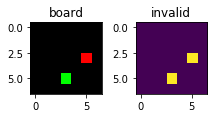

In [17]:
plot_state(state, channels_last=False)

In [18]:
state = state.transpose(1,2,0).reshape(1, BOARD_SIZE, BOARD_SIZE, 4)

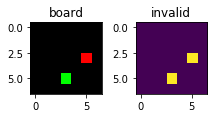

In [19]:
plot_state(state[0], channels_last=True)

### Initialization of models should be random

In [20]:
board_probs, pass_decision = actor(state.astype(np.float32))

In [21]:
board_vals, pass_vals = critic(state.astype(np.float32))

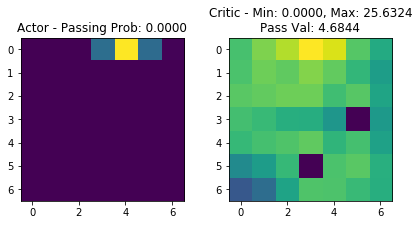

In [22]:
plt.subplot(1,2,1)
plt.title('Actor - Passing Prob: {:.4f}'.format(pass_decision[0][0]))
plt.imshow(board_probs[0])
plt.subplot(1,2,2)
plt.title('Critic - Min: {:.4f}, Max: {:.4f}\nPass Val: {:.4f}'.
          format(tf.math.reduce_min(board_vals[0]), 
                 tf.math.reduce_max(board_vals[0]), 
                 pass_vals[0][0]))
plt.imshow(board_vals[0])
plt.tight_layout()

# Training Setup

### Hyperparameters

In [23]:
NUM_EPISODES = 1000
BATCH_SIZE = 128
REPLAY_MEM_SIZE = 3e3
OPPONENT_UPDATE = 100 
EPSILON = 1
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.1
GAMMA = 0.95
TARGET_UPDATE = 1 # number of episodes to update the target critic model

In [24]:
from collections import deque

In [25]:
replay_mem = deque(maxlen=int(REPLAY_MEM_SIZE))

### Metrics and Tensorboard

Metrics

In [26]:
actor_metrics = {}
for metric_key in ['loss']:
    actor_metrics[metric_key] = tf.keras.metrics.Mean('actor_{}'.format(metric_key), dtype=tf.float32)

critic_metrics = {}
for metric_key in ['loss']:
    critic_metrics[metric_key] = tf.keras.metrics.Mean('critic_{}'.format(metric_key), dtype=tf.float32)

Tensorboard

In [27]:
summary_writers = {}
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
for summary_key in ['main']:
    log_dir = 'logs/actor_critic/{}/{}'.format(current_time, summary_key)
    summary_writers[summary_key] = tf.summary.create_file_writer(log_dir)

### Functions

In [28]:
from sklearn import preprocessing
def random_weighted_action(state, pass_prob, board_weights):
    # Decide with 1 / BOARD_SIZE ** 2 chance to pass (pass if we have to)
    if np.random.uniform() < pass_prob or np.isnan(board_weights).any() or np.sum(board_weights) <= 0:
        action = None
    else:
        board_weights_sum = np.sum(board_weights)
        board_weights = tf.reshape(board_weights, (1,BOARD_SIZE**2))
        board_weights = preprocessing.normalize(board_weights, norm='l1')
        board_weights = board_weights.reshape((BOARD_SIZE**2,))
        action_1d = np.random.choice(np.arange(BOARD_SIZE**2), p=board_weights)
        action = (action_1d // BOARD_SIZE, action_1d % BOARD_SIZE)
    return action

In [29]:
def get_action(policy, state, epsilon):
    """
    Gets an action based on exploration/exploitation
    """
    epsilon_choice = np.random.uniform()
    if epsilon_choice < EPSILON:
        # Random move
        logging.debug("Exploring a random move")
        board_weights = 1 - state[2]
        board_weights = board_weights / np.sum(board_weights)
        action = random_weighted_action(state, 
                        pass_prob=1/BOARD_SIZE**2, 
                        board_weights=board_weights)
    else:
        # policy makes a move
        logging.debug("Exploiting policy's move")
        if state.shape[0] == 4:
            state = state.transpose(1,2,0)
        act_prob_distr, pass_decision = policy(state
                                               .reshape(1, BOARD_SIZE, BOARD_SIZE, 4)
                                               .astype(np.float32))
        
        action = random_weighted_action(state, pass_prob=pass_decision, 
                                        board_weights=act_prob_distr)
        
    return action

In [30]:
def get_value_for_action(board_values, passing_values, actions):
    '''
    Get value from board_values based on action, or take the passing_values if the action is None
    '''
    action_values = tf.gather_nd(board_values, [(i, a[0], a[1]) if a is not None 
                                                    else (i, 0, 0) 
                                                    for i, a in enumerate(actions)])
    action_values = tf.where([a is not None for a in actions], action_values, passing_values)
    return action_values

In [31]:
def get_batch_obs(size=BATCH_SIZE):
    '''
    Get a batch of orig_states, actions, states, rewards, terminals as np array out of replay memory
    '''
    batch = random.sample(replay_mem, size)
    batch = list(zip(*batch))
    orig_states = np.array(list(batch[0]), dtype=np.float32).transpose(0,3,2,1)
    actions = np.array(list(batch[1]))
    states = np.array(list(batch[2]), dtype=np.float32).transpose(0,3,2,1)
    rewards = np.array(list(batch[3]), dtype=np.float32)
    terminals = np.array(list(batch[4]), dtype=np.uint8)
    return orig_states, actions, states, rewards, terminals
    

In [32]:
def calculate_state_vals(states, policy, actval_func):
    '''
    Get the expected value of states
    '''
    board_prob_distrs, passing_probs = policy(states)
    board_val_distrs, passing_vals = actval_func(states)
    
    passing_probs = tf.reshape(passing_probs, (-1,))
    passing_vals = tf.reshape(passing_vals, (-1,))
    
    # state value is the expected critic value based on the actor's policy
    state_vals = tf.reduce_sum(board_prob_distrs * board_val_distrs, axis=[1,2])
    state_vals = passing_probs * passing_vals + (1 - passing_probs) * state_vals
    return state_vals

In [33]:
critic_optimizer = tf.keras.optimizers.Adam(1e-5)
def update_critic():
    """
    Optimizes the critic in one step and updates the critic loss metric
    """
    
    mse = tf.keras.losses.MeanSquaredError()
    
    states, actions, next_states, rewards, terminals  = get_batch_obs()
    
    # get expected values for next state
    next_state_vals = calculate_state_vals(next_states, actor, target_critic)
    
    with tf.GradientTape() as tape:
        board_val_distrs, passing_vals = critic(states)
        passing_vals = tf.reshape(passing_vals, (-1,))
        action_vals = get_value_for_action(board_val_distrs, passing_vals, actions)
        val_loss = mse(rewards + GAMMA * next_state_vals * (1-terminals), action_vals)
    
    critic_metrics['loss'](val_loss)
    
    # compute and apply gradients
    gradients = tape.gradient(val_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(gradients, critic.trainable_variables))

In [34]:
actor_optimizer = tf.keras.optimizers.Adam(1e-5)
def update_actor():
    """
    Optimizes the actor in one step and updates the critic loss metric
    """
    
    mse = tf.keras.losses.MeanSquaredError()
    
    states, actions, next_states, rewards, terminals = get_batch_obs()
    
    # State values
    state_vals = calculate_state_vals(states, actor, critic)
    
    # Next state values
    next_state_vals = calculate_state_vals(next_states, actor, critic)
    
    # Advantage values
    avntg_vals = (rewards + GAMMA * next_state_vals * (1-terminals)) - state_vals
    
    with tf.GradientTape() as tape:
        board_prob_distrs, passing_probs = actor(states)
        passing_probs = tf.reshape(passing_probs, (-1,))
        action_probs = get_value_for_action(board_prob_distrs, passing_probs, actions)
        avntg_loss = - tf.math.log(action_probs + 1e-6) * avntg_vals
        avntg_loss = tf.math.reduce_mean(avntg_loss)
    
    # log the loss in tensorboard
    actor_metrics['loss'](avntg_loss)
        
    # compute and apply gradients
    gradients = tape.gradient(avntg_loss, actor.trainable_variables)
    actor_optimizer.apply_gradients(zip(gradients, actor.trainable_variables))

In [35]:
def train(episode):
    """
    Plays out a game, and iteratively updates the models at each step
    """
    global EPSILON
    
    # Basic setup
    done = False
    num_of_turns = 0
    state = go_env.reset()
    max_steps = BOARD_SIZE**3
    rewards = []
    
    while not done and num_of_turns <= max_steps:
        # Copy state for memory
        orig_state = np.copy(state)
        
        action = get_action(actor, state, EPSILON)
        if action is None:
            logging.debug("Black (actor) passed")
            
        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        rewards.append(reward)
        
        # Add to memory
        replay_mem.append((orig_state, action, state, reward, done))
        
        # Update the critic and then actor if we have enough events
        if len(replay_mem) >= BATCH_SIZE:
            update_critic()        
            update_actor()
    
            # Update exploration/exploitation
            if EPSILON > EPSILON_MIN:
                EPSILON *= EPSILON_DECAY
                logging.debug("Epsilon decayed to {}".format(EPSILON))
            
        if done:
            break
            
        # opponent makes a move
        # swap the black and white layers
        temp = np.copy(state[0])
        state[0] = state[1]
        state[1] = temp
        # get action from opponent
        action = get_action(opponent, state, epsilon=0)
        if action is None:
            logging.debug("White (opponent) passed")

        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        rewards.append(reward)
    
    # Game ended
    return num_of_turns, rewards

# Train

In [36]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [37]:
%tensorboard --logdir logs/actor_critic

Reusing TensorBoard on port 6007 (pid 38920), started 13:30:15 ago. (Use '!kill 38920' to kill it.)

  0%|          | 0/1000 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
I0708 21:42:09.543591 4554798528 <ipython-input-38-6ec7be6f7e32>:10] Updated opponent
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the 

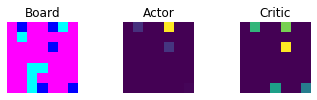

  0%|          | 1/1000 [00:02<34:00,  2.04s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_laun

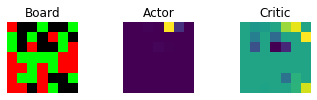

  0%|          | 2/1000 [00:38<3:26:56, 12.44s/it]

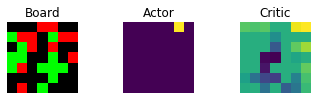

  0%|          | 3/1000 [01:44<7:50:11, 28.30s/it]

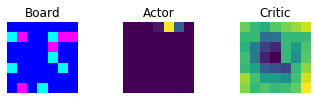

  0%|          | 4/1000 [01:55<6:27:09, 23.32s/it]

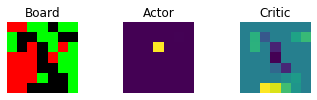

  0%|          | 5/1000 [02:08<5:33:51, 20.13s/it]

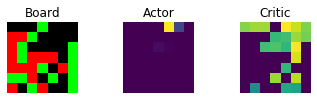

  1%|          | 6/1000 [02:20<4:54:23, 17.77s/it]

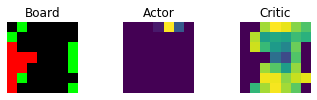

  1%|          | 7/1000 [02:32<4:25:10, 16.02s/it]

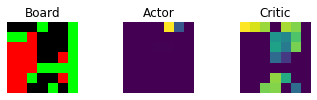

  1%|          | 8/1000 [02:41<3:50:00, 13.91s/it]

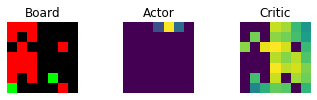

  1%|          | 9/1000 [03:00<4:16:01, 15.50s/it]

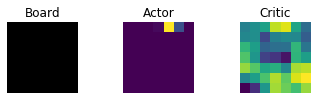

  1%|          | 10/1000 [03:13<4:04:08, 14.80s/it]

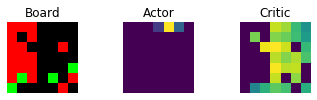

  1%|          | 11/1000 [03:34<4:31:05, 16.45s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


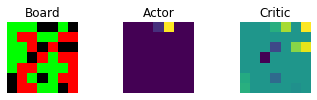

  1%|          | 12/1000 [04:13<6:24:05, 23.33s/it]

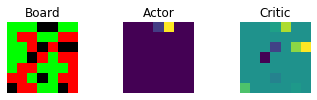

  1%|▏         | 13/1000 [04:53<7:43:56, 28.20s/it]

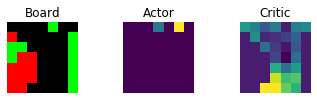

  1%|▏         | 14/1000 [05:14<7:07:27, 26.01s/it]

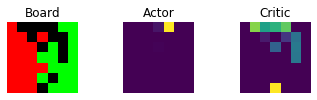

  2%|▏         | 15/1000 [05:33<6:35:41, 24.10s/it]

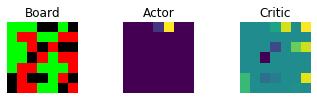

  2%|▏         | 16/1000 [05:54<6:16:27, 22.95s/it]

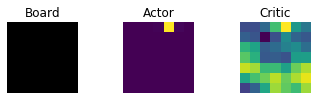

  2%|▏         | 17/1000 [06:15<6:06:42, 22.38s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


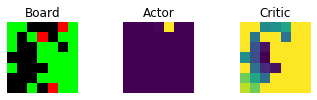

  2%|▏         | 18/1000 [06:54<7:31:34, 27.59s/it]

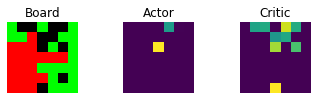

  2%|▏         | 19/1000 [07:11<6:39:39, 24.44s/it]

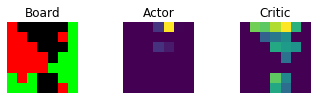

  2%|▏         | 20/1000 [07:24<5:41:16, 20.89s/it]

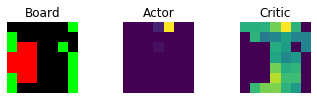

  2%|▏         | 21/1000 [07:37<5:01:49, 18.50s/it]

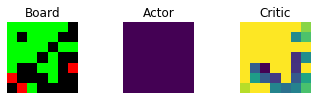

  2%|▏         | 22/1000 [08:00<5:24:31, 19.91s/it]

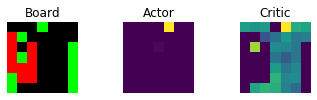

  2%|▏         | 23/1000 [08:20<5:24:41, 19.94s/it]

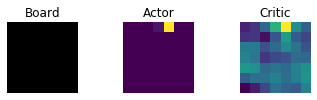

  2%|▏         | 24/1000 [08:40<5:22:34, 19.83s/it]

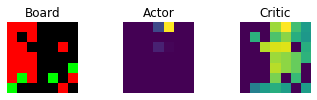

  2%|▎         | 25/1000 [09:14<6:33:22, 24.21s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


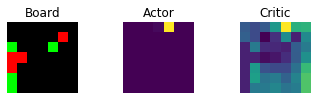

  3%|▎         | 26/1000 [09:35<6:15:56, 23.16s/it]

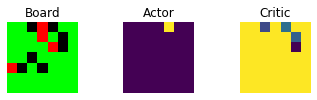

  3%|▎         | 27/1000 [09:55<5:58:54, 22.13s/it]

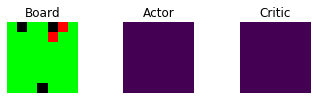

  3%|▎         | 28/1000 [10:10<5:26:34, 20.16s/it]

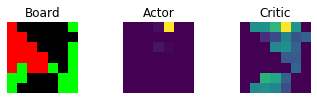

  3%|▎         | 29/1000 [10:30<5:22:51, 19.95s/it]

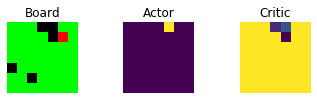

  3%|▎         | 30/1000 [10:51<5:27:10, 20.24s/it]

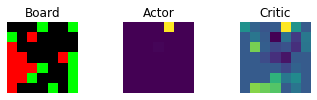

  3%|▎         | 31/1000 [11:10<5:23:54, 20.06s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


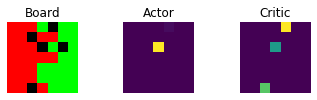

  3%|▎         | 32/1000 [11:32<5:29:49, 20.44s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


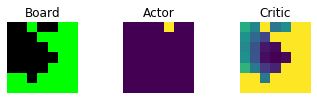

  3%|▎         | 33/1000 [11:52<5:29:21, 20.44s/it]

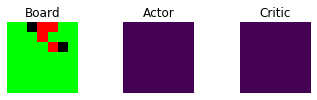

  3%|▎         | 34/1000 [12:13<5:33:33, 20.72s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


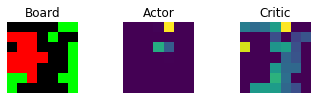

  4%|▎         | 35/1000 [12:34<5:34:50, 20.82s/it]

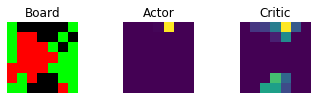

  4%|▎         | 36/1000 [12:47<4:57:03, 18.49s/it]

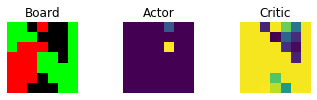

  4%|▎         | 37/1000 [13:08<5:05:23, 19.03s/it]

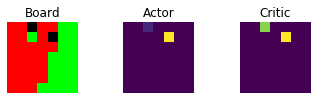

  4%|▍         | 38/1000 [13:28<5:10:11, 19.35s/it]

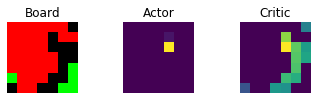

  4%|▍         | 39/1000 [13:50<5:25:07, 20.30s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


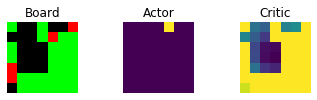

  4%|▍         | 40/1000 [14:10<5:22:56, 20.18s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


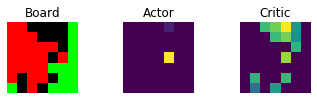

  4%|▍         | 41/1000 [14:30<5:18:56, 19.95s/it]

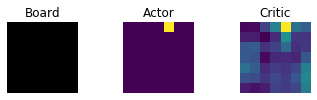

  4%|▍         | 42/1000 [14:44<4:50:04, 18.17s/it]

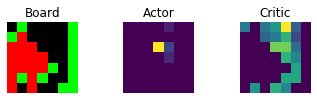

  4%|▍         | 43/1000 [14:57<4:27:02, 16.74s/it]

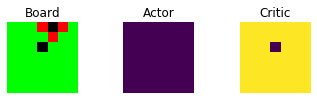

  4%|▍         | 44/1000 [15:11<4:10:51, 15.74s/it]

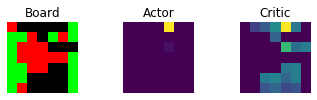

  4%|▍         | 45/1000 [15:20<3:39:53, 13.81s/it]

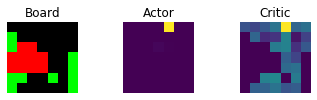

  5%|▍         | 46/1000 [15:35<3:45:05, 14.16s/it]

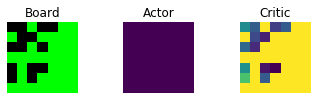

  5%|▍         | 47/1000 [16:05<4:59:41, 18.87s/it]

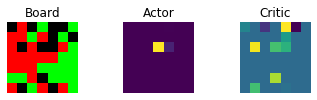

  5%|▍         | 48/1000 [16:38<6:08:48, 23.24s/it]

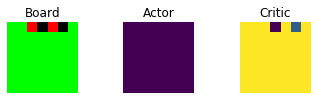

  5%|▍         | 49/1000 [16:51<5:17:03, 20.00s/it]

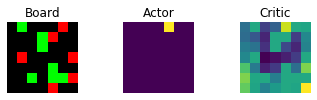

  5%|▌         | 50/1000 [17:10<5:15:21, 19.92s/it]

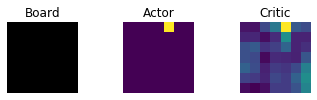

  5%|▌         | 51/1000 [17:22<4:37:20, 17.53s/it]

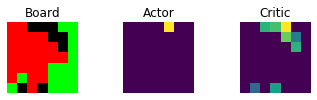

  5%|▌         | 52/1000 [17:42<4:49:40, 18.33s/it]

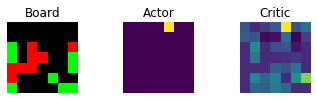

  5%|▌         | 53/1000 [17:56<4:26:30, 16.89s/it]

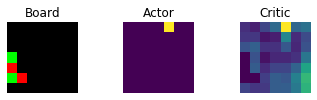

  5%|▌         | 54/1000 [18:16<4:40:00, 17.76s/it]

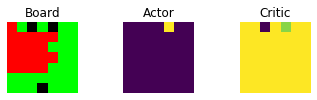

  6%|▌         | 55/1000 [18:33<4:38:26, 17.68s/it]

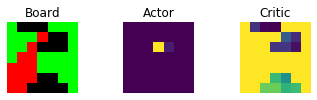

  6%|▌         | 56/1000 [18:47<4:22:01, 16.65s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


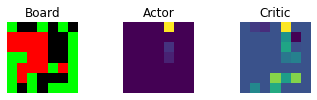

  6%|▌         | 57/1000 [19:07<4:35:16, 17.51s/it]

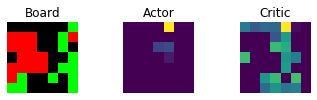

  6%|▌         | 58/1000 [19:26<4:42:29, 17.99s/it]

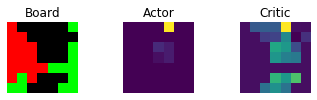

  6%|▌         | 59/1000 [19:39<4:20:15, 16.59s/it]

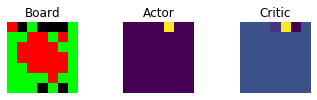

  6%|▌         | 60/1000 [19:59<4:32:32, 17.40s/it]

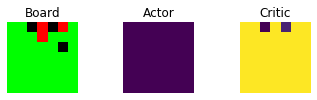

  6%|▌         | 61/1000 [20:18<4:39:49, 17.88s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


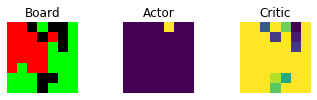

  6%|▌         | 62/1000 [20:37<4:47:33, 18.39s/it]

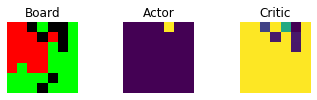

  6%|▋         | 63/1000 [20:50<4:22:24, 16.80s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


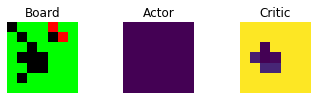

  6%|▋         | 64/1000 [21:11<4:42:03, 18.08s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


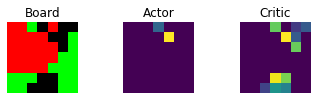

  6%|▋         | 65/1000 [21:49<6:14:14, 24.02s/it]

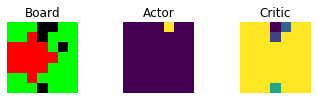

  7%|▋         | 66/1000 [22:09<5:51:27, 22.58s/it]

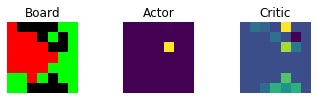

  7%|▋         | 67/1000 [22:22<5:08:47, 19.86s/it]

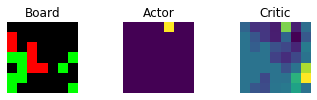

  7%|▋         | 68/1000 [22:41<5:05:58, 19.70s/it]

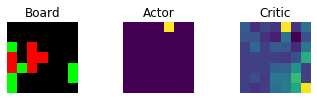

  7%|▋         | 69/1000 [22:54<4:34:03, 17.66s/it]

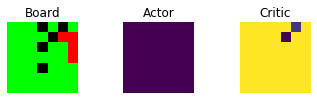

  7%|▋         | 70/1000 [23:15<4:47:48, 18.57s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


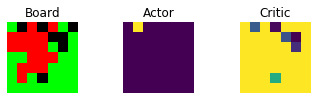

  7%|▋         | 71/1000 [23:35<4:52:56, 18.92s/it]

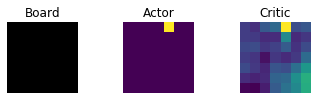

  7%|▋         | 72/1000 [23:50<4:33:57, 17.71s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


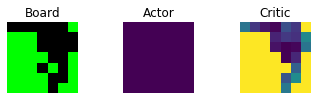

  7%|▋         | 73/1000 [24:10<4:47:02, 18.58s/it]

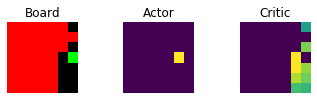

  7%|▋         | 74/1000 [24:24<4:22:32, 17.01s/it]

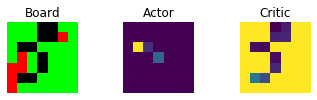

  8%|▊         | 75/1000 [24:43<4:33:33, 17.74s/it]

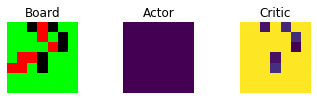

  8%|▊         | 76/1000 [24:57<4:16:45, 16.67s/it]

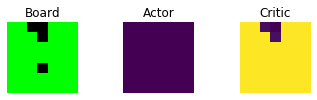

  8%|▊         | 77/1000 [25:12<4:05:39, 15.97s/it]

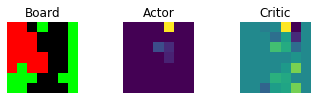

  8%|▊         | 78/1000 [25:31<4:23:12, 17.13s/it]

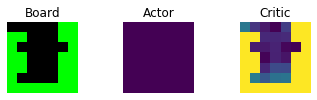

  8%|▊         | 79/1000 [25:43<3:59:06, 15.58s/it]

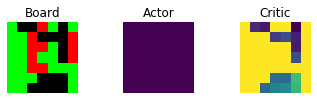

  8%|▊         | 80/1000 [26:04<4:23:00, 17.15s/it]

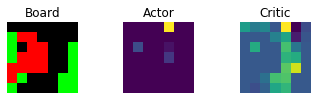

  8%|▊         | 81/1000 [26:24<4:36:03, 18.02s/it]

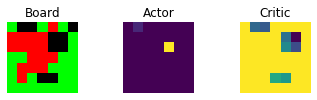

  8%|▊         | 82/1000 [26:37<4:12:27, 16.50s/it]

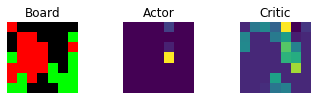

  8%|▊         | 83/1000 [26:51<4:01:37, 15.81s/it]

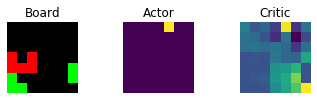

  8%|▊         | 84/1000 [27:23<5:12:32, 20.47s/it]

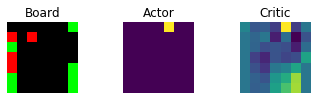

  8%|▊         | 85/1000 [27:43<5:12:19, 20.48s/it]

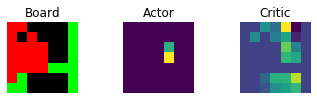

  9%|▊         | 86/1000 [28:03<5:07:47, 20.20s/it]

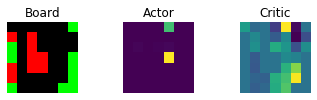

  9%|▊         | 87/1000 [28:17<4:38:28, 18.30s/it]

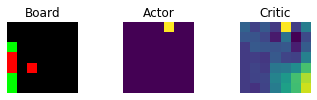

  9%|▉         | 88/1000 [28:30<4:14:54, 16.77s/it]

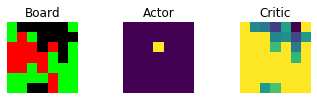

  9%|▉         | 89/1000 [28:43<3:57:15, 15.63s/it]

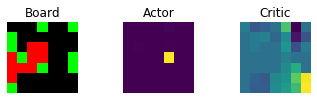

  9%|▉         | 90/1000 [29:03<4:18:46, 17.06s/it]

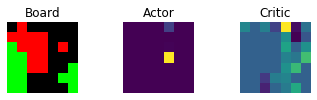

  9%|▉         | 91/1000 [29:23<4:30:52, 17.88s/it]

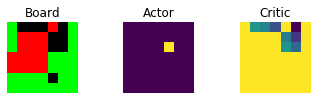

  9%|▉         | 92/1000 [29:32<3:51:33, 15.30s/it]

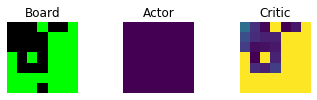

  9%|▉         | 93/1000 [29:46<3:42:43, 14.73s/it]

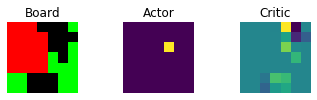

  9%|▉         | 94/1000 [30:05<4:03:53, 16.15s/it]

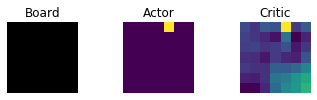

 10%|▉         | 95/1000 [30:27<4:27:58, 17.77s/it]

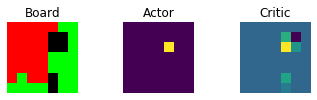

 10%|▉         | 96/1000 [30:46<4:36:08, 18.33s/it]

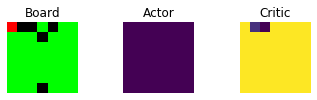

 10%|▉         | 97/1000 [31:25<6:06:11, 24.33s/it]

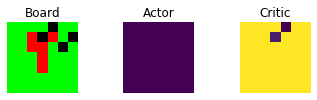

 10%|▉         | 98/1000 [31:45<5:45:38, 22.99s/it]

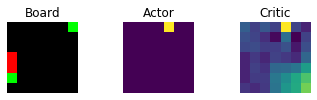

 10%|▉         | 99/1000 [32:01<5:16:09, 21.05s/it]

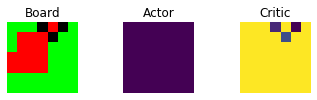

 10%|█         | 100/1000 [32:21<5:08:50, 20.59s/it]I0708 22:14:30.578732 4554798528 <ipython-input-38-6ec7be6f7e32>:10] Updated opponent


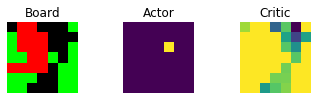

 10%|█         | 101/1000 [32:24<3:50:33, 15.39s/it]

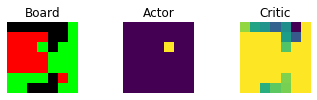

 10%|█         | 102/1000 [32:31<3:13:54, 12.96s/it]

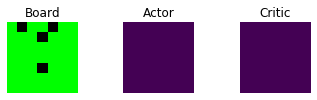

 10%|█         | 103/1000 [32:34<2:28:20,  9.92s/it]

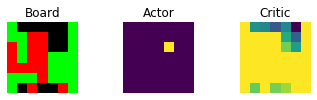

 10%|█         | 104/1000 [32:37<1:58:27,  7.93s/it]

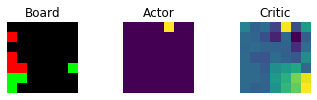

 10%|█         | 105/1000 [32:40<1:35:49,  6.42s/it]

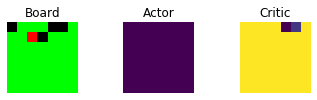

 11%|█         | 106/1000 [32:44<1:23:42,  5.62s/it]

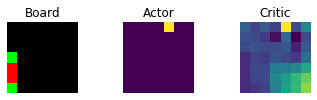

 11%|█         | 107/1000 [32:48<1:16:33,  5.14s/it]

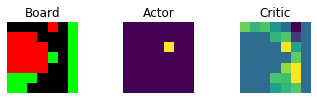

 11%|█         | 108/1000 [32:51<1:08:15,  4.59s/it]

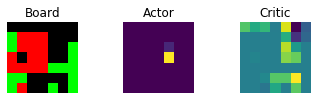

 11%|█         | 109/1000 [32:56<1:07:40,  4.56s/it]

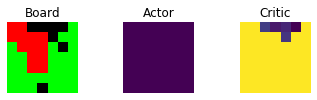

 11%|█         | 110/1000 [32:59<1:00:04,  4.05s/it]

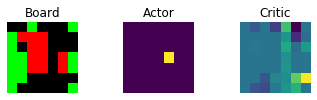

 11%|█         | 111/1000 [33:03<1:01:55,  4.18s/it]

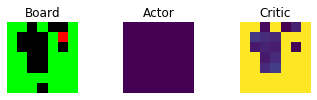

 11%|█         | 112/1000 [33:06<56:12,  3.80s/it]  

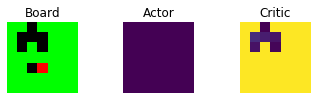

 11%|█▏        | 113/1000 [33:09<52:01,  3.52s/it]

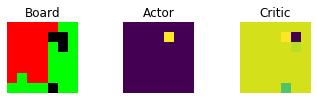

 11%|█▏        | 114/1000 [33:12<49:06,  3.33s/it]

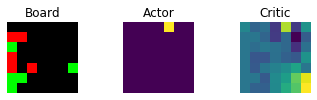

 12%|█▏        | 115/1000 [33:14<45:13,  3.07s/it]

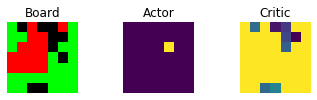

 12%|█▏        | 116/1000 [33:17<44:17,  3.01s/it]

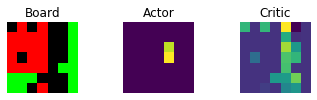

 12%|█▏        | 117/1000 [33:20<43:40,  2.97s/it]

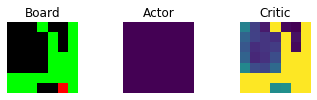

 12%|█▏        | 118/1000 [33:23<43:11,  2.94s/it]

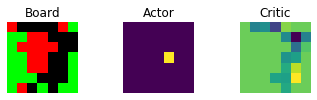

 12%|█▏        | 119/1000 [33:26<42:55,  2.92s/it]

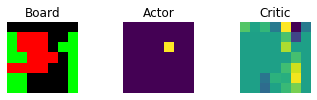

 12%|█▏        | 120/1000 [33:32<58:31,  3.99s/it]

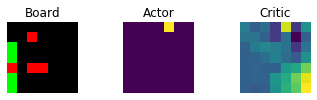

 12%|█▏        | 121/1000 [33:35<55:17,  3.77s/it]

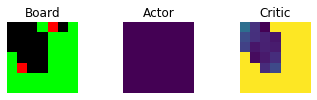

 12%|█▏        | 122/1000 [33:38<49:42,  3.40s/it]

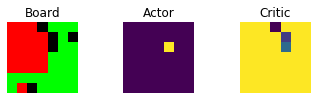

 12%|█▏        | 123/1000 [33:41<47:32,  3.25s/it]

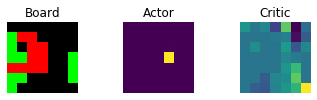

 12%|█▏        | 124/1000 [33:44<46:05,  3.16s/it]

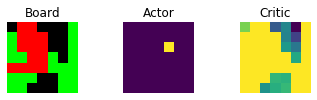

 12%|█▎        | 125/1000 [33:47<46:45,  3.21s/it]

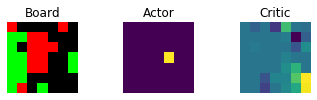

 13%|█▎        | 126/1000 [33:50<45:17,  3.11s/it]

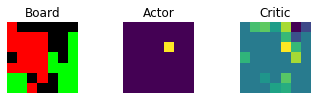

 13%|█▎        | 127/1000 [33:53<44:21,  3.05s/it]

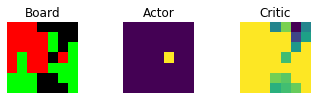

 13%|█▎        | 128/1000 [33:56<43:31,  2.99s/it]

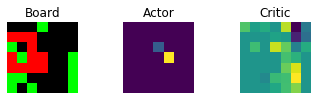

 13%|█▎        | 129/1000 [33:59<43:00,  2.96s/it]

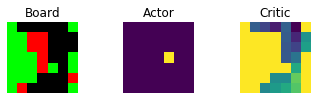

 13%|█▎        | 130/1000 [34:01<40:54,  2.82s/it]

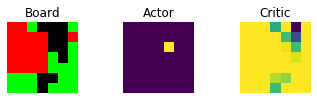

 13%|█▎        | 131/1000 [34:04<39:21,  2.72s/it]

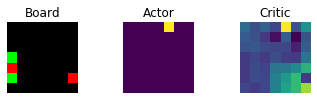

 13%|█▎        | 132/1000 [34:07<43:52,  3.03s/it]

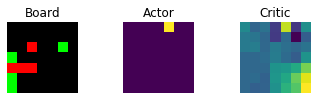

 13%|█▎        | 133/1000 [34:10<43:16,  2.99s/it]

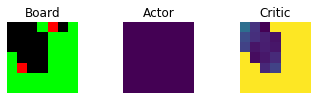

 13%|█▎        | 134/1000 [34:13<42:51,  2.97s/it]

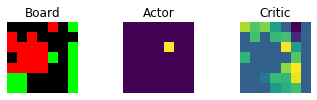

 14%|█▎        | 135/1000 [34:16<40:39,  2.82s/it]

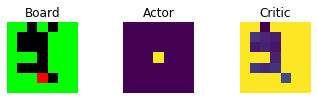

 14%|█▎        | 136/1000 [34:19<42:39,  2.96s/it]

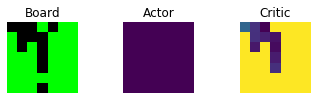

 14%|█▎        | 137/1000 [34:22<43:55,  3.05s/it]

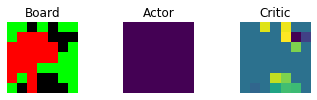

 14%|█▍        | 138/1000 [34:25<43:07,  3.00s/it]

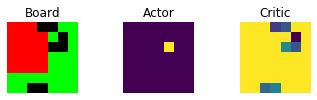

 14%|█▍        | 139/1000 [34:29<46:07,  3.21s/it]

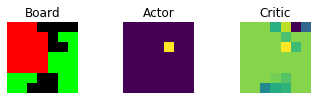

 14%|█▍        | 140/1000 [34:32<44:37,  3.11s/it]

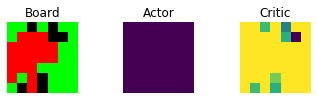

 14%|█▍        | 141/1000 [34:35<45:19,  3.17s/it]

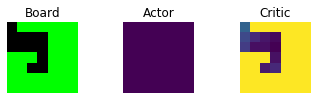

 14%|█▍        | 142/1000 [34:37<42:20,  2.96s/it]

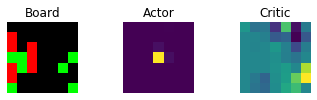

 14%|█▍        | 143/1000 [34:40<41:55,  2.94s/it]

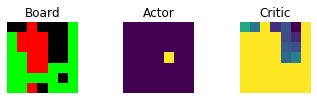

 14%|█▍        | 144/1000 [34:44<43:33,  3.05s/it]

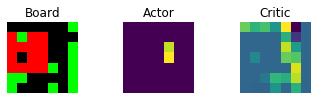

 14%|█▍        | 145/1000 [34:47<44:29,  3.12s/it]

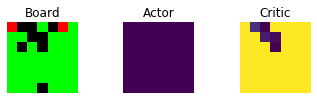

 15%|█▍        | 146/1000 [34:50<45:03,  3.17s/it]

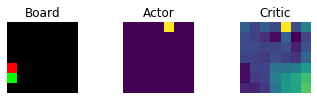

 15%|█▍        | 147/1000 [34:53<43:41,  3.07s/it]

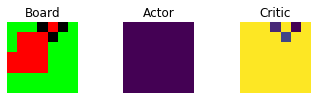

 15%|█▍        | 148/1000 [34:56<41:06,  2.89s/it]

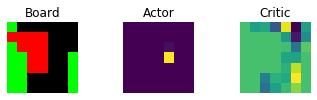

 15%|█▍        | 149/1000 [34:58<39:17,  2.77s/it]

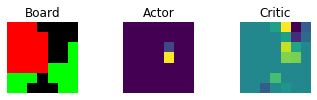

 15%|█▌        | 150/1000 [35:01<39:36,  2.80s/it]

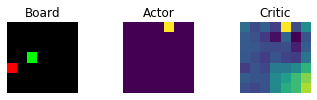

 15%|█▌        | 151/1000 [35:04<39:49,  2.81s/it]

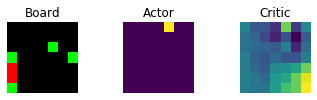

 15%|█▌        | 152/1000 [35:07<40:02,  2.83s/it]

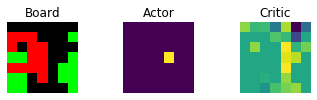

 15%|█▌        | 153/1000 [35:09<40:07,  2.84s/it]

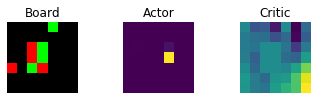

 15%|█▌        | 154/1000 [35:12<40:21,  2.86s/it]

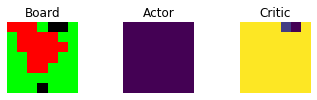

 16%|█▌        | 155/1000 [35:16<42:00,  2.98s/it]

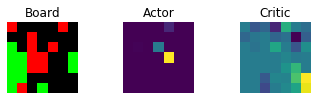

 16%|█▌        | 156/1000 [35:19<41:39,  2.96s/it]

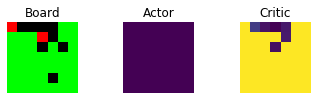

 16%|█▌        | 157/1000 [35:22<42:55,  3.05s/it]

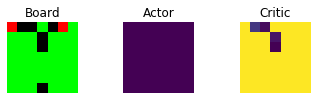

 16%|█▌        | 158/1000 [35:24<40:28,  2.88s/it]

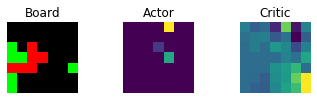

 16%|█▌        | 159/1000 [35:27<40:24,  2.88s/it]

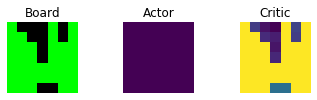

 16%|█▌        | 160/1000 [35:30<41:58,  3.00s/it]

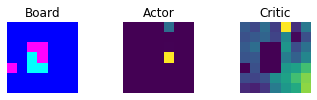

 16%|█▌        | 161/1000 [35:34<46:01,  3.29s/it]

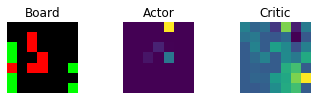

 16%|█▌        | 162/1000 [35:37<44:21,  3.18s/it]

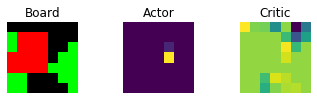

 16%|█▋        | 163/1000 [35:41<44:46,  3.21s/it]

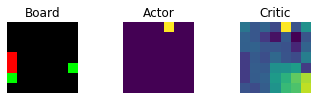

 16%|█▋        | 164/1000 [35:44<46:57,  3.37s/it]

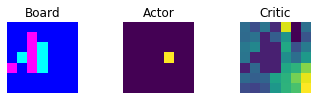

 16%|█▋        | 165/1000 [35:47<44:58,  3.23s/it]

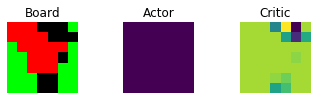

 17%|█▋        | 166/1000 [35:50<43:30,  3.13s/it]

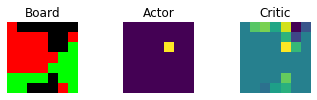

 17%|█▋        | 167/1000 [35:54<45:57,  3.31s/it]

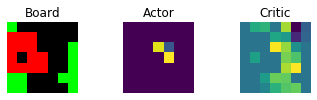

 17%|█▋        | 168/1000 [35:58<47:37,  3.43s/it]

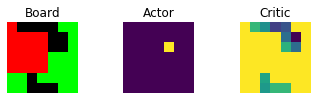

 17%|█▋        | 169/1000 [36:01<46:56,  3.39s/it]

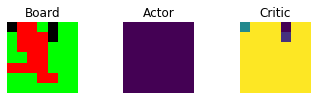

 17%|█▋        | 170/1000 [36:05<48:20,  3.49s/it]

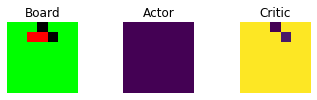

 17%|█▋        | 171/1000 [36:08<45:51,  3.32s/it]

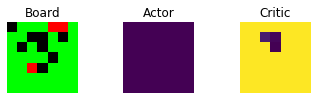

 17%|█▋        | 172/1000 [36:11<45:40,  3.31s/it]

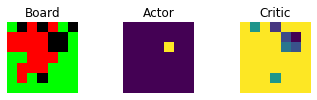

 17%|█▋        | 173/1000 [36:14<43:48,  3.18s/it]

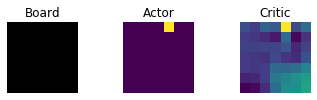

 17%|█▋        | 174/1000 [36:17<42:37,  3.10s/it]

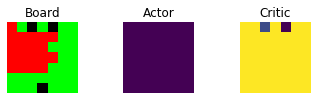

 18%|█▊        | 175/1000 [36:20<41:49,  3.04s/it]

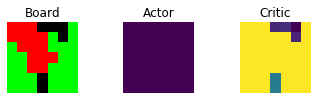

 18%|█▊        | 176/1000 [36:28<1:06:05,  4.81s/it]

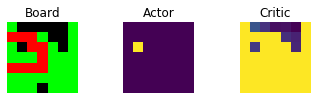

 18%|█▊        | 177/1000 [36:31<58:01,  4.23s/it]  

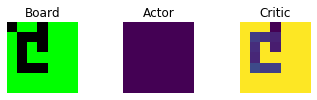

 18%|█▊        | 178/1000 [36:34<52:31,  3.83s/it]

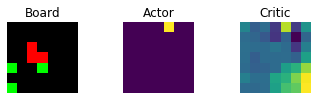

 18%|█▊        | 179/1000 [36:37<48:43,  3.56s/it]

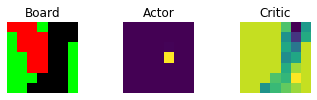

 18%|█▊        | 180/1000 [36:40<45:51,  3.36s/it]

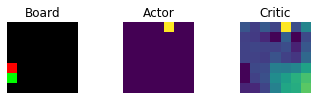

 18%|█▊        | 181/1000 [36:43<44:12,  3.24s/it]

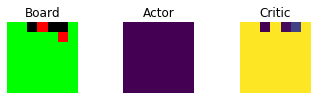

 18%|█▊        | 182/1000 [36:46<42:47,  3.14s/it]

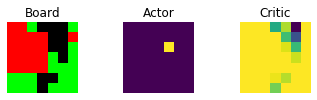

 18%|█▊        | 183/1000 [36:49<43:34,  3.20s/it]

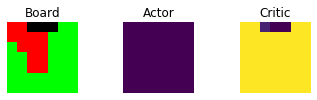

 18%|█▊        | 184/1000 [36:52<40:38,  2.99s/it]

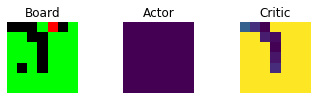

 18%|█▊        | 185/1000 [36:55<41:53,  3.08s/it]

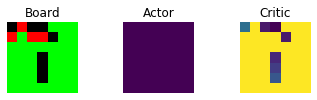

 19%|█▊        | 186/1000 [36:58<39:35,  2.92s/it]

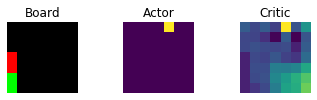

 19%|█▊        | 187/1000 [37:00<39:20,  2.90s/it]

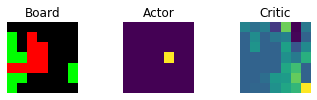

 19%|█▉        | 188/1000 [37:03<37:42,  2.79s/it]

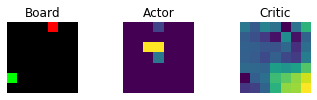

 19%|█▉        | 189/1000 [37:06<38:17,  2.83s/it]

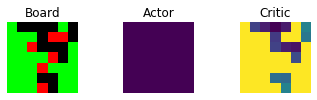

 19%|█▉        | 190/1000 [37:10<41:49,  3.10s/it]

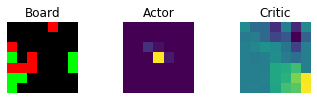

 19%|█▉        | 191/1000 [37:13<42:36,  3.16s/it]

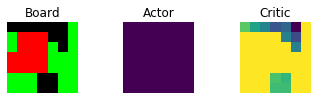

 19%|█▉        | 192/1000 [37:15<39:54,  2.96s/it]

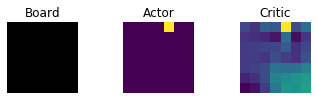

 19%|█▉        | 193/1000 [37:18<39:34,  2.94s/it]

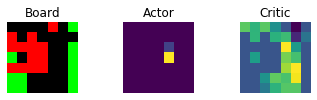

 19%|█▉        | 194/1000 [37:22<42:37,  3.17s/it]

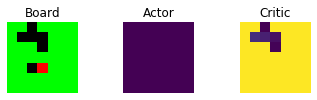

 20%|█▉        | 195/1000 [37:26<44:48,  3.34s/it]

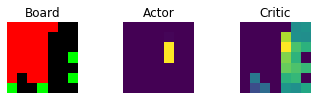

 20%|█▉        | 196/1000 [37:30<48:14,  3.60s/it]

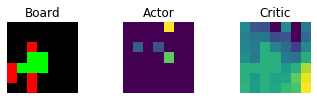

 20%|█▉        | 197/1000 [37:33<43:46,  3.27s/it]

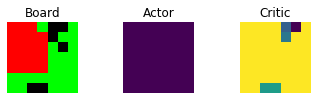

 20%|█▉        | 198/1000 [37:36<43:58,  3.29s/it]

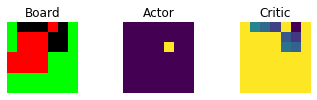

 20%|█▉        | 199/1000 [37:39<44:00,  3.30s/it]

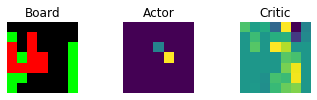

 20%|██        | 200/1000 [37:42<40:51,  3.06s/it]I0708 22:19:51.746262 4554798528 <ipython-input-38-6ec7be6f7e32>:10] Updated opponent


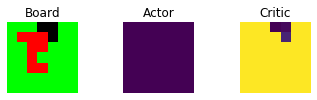

 20%|██        | 201/1000 [37:45<43:32,  3.27s/it]

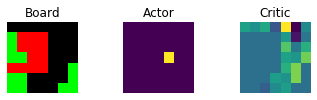

 20%|██        | 202/1000 [37:49<45:30,  3.42s/it]

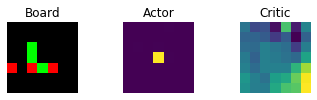

 20%|██        | 203/1000 [37:53<48:09,  3.63s/it]

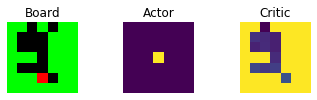

 20%|██        | 204/1000 [37:57<46:48,  3.53s/it]

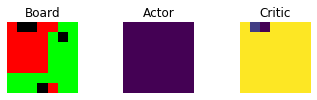

 20%|██        | 205/1000 [38:00<44:24,  3.35s/it]

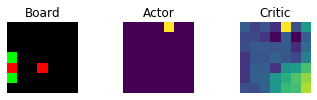

 21%|██        | 206/1000 [38:03<44:17,  3.35s/it]

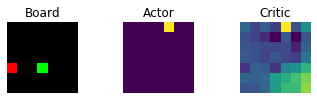

 21%|██        | 207/1000 [38:06<42:39,  3.23s/it]

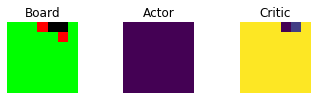

 21%|██        | 208/1000 [38:16<1:08:49,  5.21s/it]

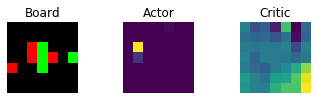

 21%|██        | 209/1000 [38:22<1:12:25,  5.49s/it]

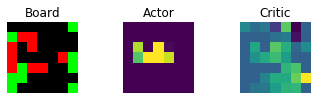

 21%|██        | 210/1000 [38:32<1:29:22,  6.79s/it]

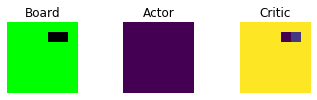

 21%|██        | 211/1000 [38:40<1:34:40,  7.20s/it]

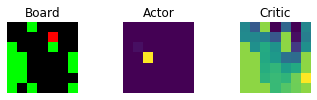

 21%|██        | 212/1000 [38:47<1:32:37,  7.05s/it]

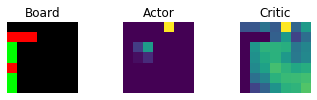

 21%|██▏       | 213/1000 [38:52<1:27:38,  6.68s/it]

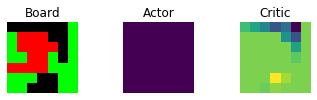

 21%|██▏       | 214/1000 [38:58<1:23:59,  6.41s/it]

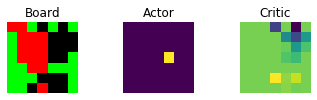

 22%|██▏       | 215/1000 [39:02<1:14:55,  5.73s/it]

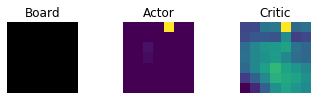

 22%|██▏       | 216/1000 [39:07<1:10:12,  5.37s/it]

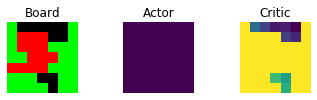

 22%|██▏       | 217/1000 [39:12<1:09:47,  5.35s/it]

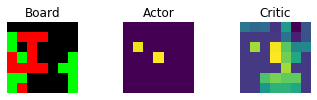

 22%|██▏       | 218/1000 [39:16<1:04:47,  4.97s/it]

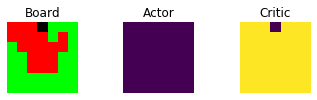

 22%|██▏       | 219/1000 [39:21<1:04:28,  4.95s/it]

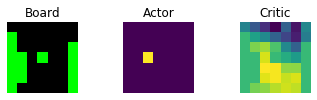

 22%|██▏       | 220/1000 [39:26<1:02:34,  4.81s/it]

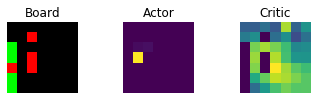

 22%|██▏       | 221/1000 [39:30<1:01:30,  4.74s/it]

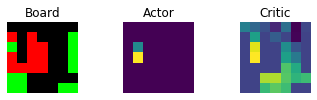

 22%|██▏       | 222/1000 [39:36<1:04:20,  4.96s/it]

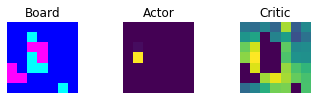

 22%|██▏       | 223/1000 [39:41<1:04:10,  4.96s/it]

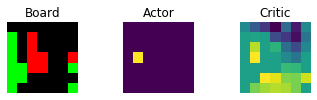

 22%|██▏       | 224/1000 [39:45<1:02:38,  4.84s/it]

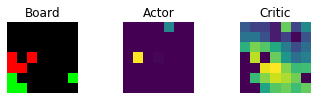

 22%|██▎       | 225/1000 [39:50<1:03:07,  4.89s/it]

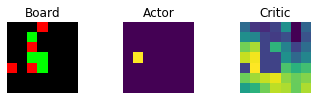

 23%|██▎       | 226/1000 [39:55<1:03:07,  4.89s/it]

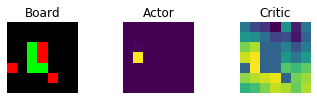

 23%|██▎       | 227/1000 [40:00<1:01:35,  4.78s/it]

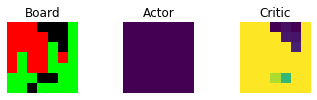

 23%|██▎       | 228/1000 [40:05<1:03:44,  4.95s/it]

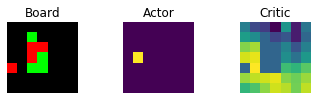

 23%|██▎       | 229/1000 [40:10<1:05:22,  5.09s/it]

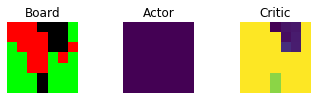

 23%|██▎       | 230/1000 [40:16<1:07:57,  5.30s/it]

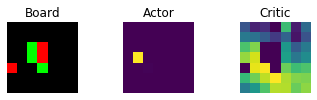

 23%|██▎       | 231/1000 [40:22<1:09:42,  5.44s/it]

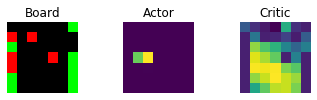

 23%|██▎       | 232/1000 [40:27<1:09:12,  5.41s/it]

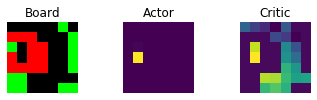

 23%|██▎       | 233/1000 [40:33<1:12:11,  5.65s/it]

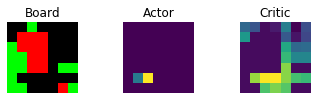

 23%|██▎       | 234/1000 [40:40<1:14:13,  5.81s/it]

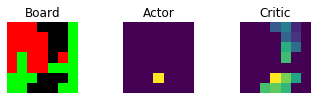

 24%|██▎       | 235/1000 [40:47<1:21:01,  6.35s/it]

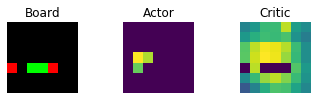

 24%|██▎       | 236/1000 [40:55<1:25:19,  6.70s/it]

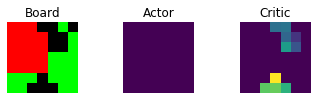

 24%|██▎       | 237/1000 [41:01<1:23:09,  6.54s/it]

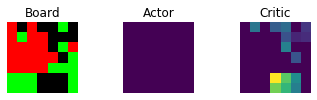

 24%|██▍       | 238/1000 [41:08<1:26:07,  6.78s/it]

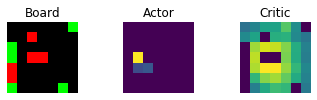

 24%|██▍       | 239/1000 [41:14<1:20:33,  6.35s/it]

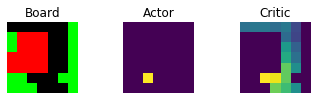

 24%|██▍       | 240/1000 [41:19<1:16:36,  6.05s/it]

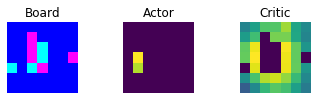

 24%|██▍       | 241/1000 [41:25<1:15:33,  5.97s/it]

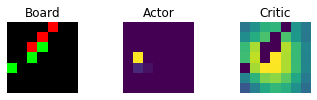

 24%|██▍       | 242/1000 [41:30<1:13:08,  5.79s/it]

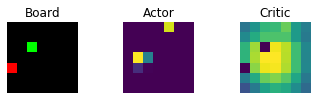

 24%|██▍       | 243/1000 [41:35<1:08:25,  5.42s/it]

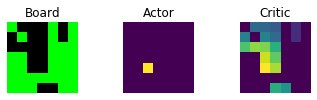

 24%|██▍       | 244/1000 [41:40<1:06:48,  5.30s/it]

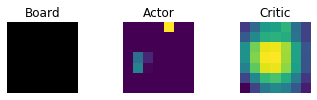

 24%|██▍       | 245/1000 [41:45<1:07:23,  5.36s/it]

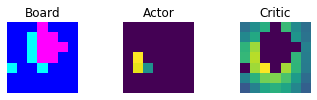

 25%|██▍       | 246/1000 [41:51<1:07:38,  5.38s/it]

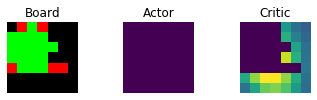

 25%|██▍       | 247/1000 [41:54<1:01:24,  4.89s/it]

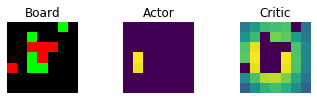

 25%|██▍       | 248/1000 [41:58<58:27,  4.66s/it]  

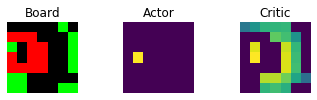

 25%|██▍       | 249/1000 [42:02<55:01,  4.40s/it]

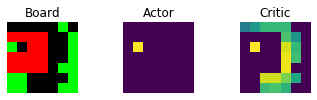

 25%|██▌       | 250/1000 [42:06<54:06,  4.33s/it]

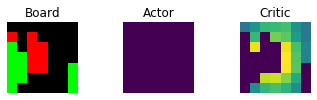

 25%|██▌       | 251/1000 [42:10<51:55,  4.16s/it]

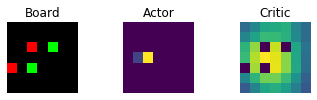

 25%|██▌       | 252/1000 [42:15<55:02,  4.42s/it]

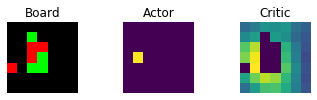

 25%|██▌       | 253/1000 [42:19<54:11,  4.35s/it]

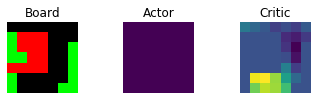

 25%|██▌       | 254/1000 [42:23<51:55,  4.18s/it]

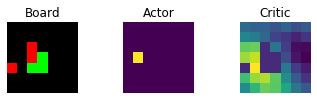

 26%|██▌       | 255/1000 [42:27<51:45,  4.17s/it]

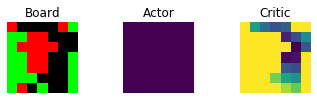

 26%|██▌       | 256/1000 [42:32<53:21,  4.30s/it]

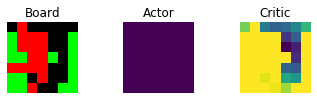

 26%|██▌       | 257/1000 [42:35<49:49,  4.02s/it]

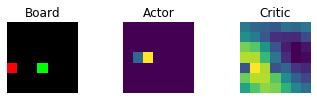

 26%|██▌       | 258/1000 [42:39<48:50,  3.95s/it]

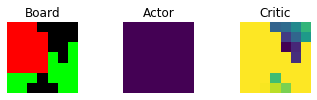

 26%|██▌       | 259/1000 [42:43<50:00,  4.05s/it]

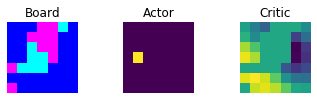

 26%|██▌       | 260/1000 [42:47<49:19,  4.00s/it]

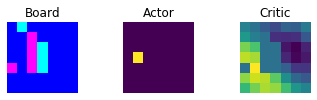

 26%|██▌       | 261/1000 [42:51<50:00,  4.06s/it]

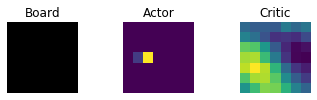

 26%|██▌       | 262/1000 [42:56<52:11,  4.24s/it]

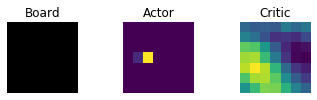

 26%|██▋       | 263/1000 [43:00<50:39,  4.12s/it]

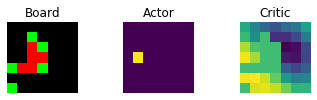

 26%|██▋       | 264/1000 [43:04<49:33,  4.04s/it]

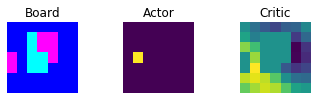

 26%|██▋       | 265/1000 [43:07<47:18,  3.86s/it]

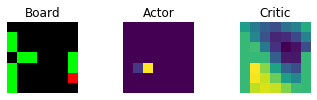

 27%|██▋       | 266/1000 [43:11<47:22,  3.87s/it]

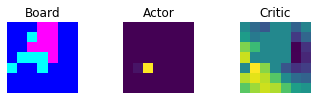

 27%|██▋       | 267/1000 [43:15<47:06,  3.86s/it]

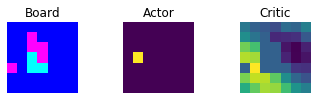

 27%|██▋       | 268/1000 [43:19<48:19,  3.96s/it]

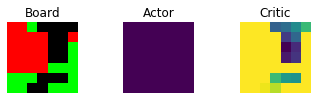

 27%|██▋       | 269/1000 [43:23<48:57,  4.02s/it]

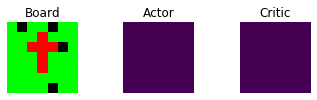

 27%|██▋       | 270/1000 [43:27<46:08,  3.79s/it]

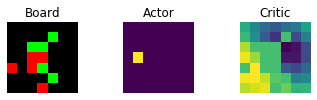

 27%|██▋       | 271/1000 [43:32<50:10,  4.13s/it]

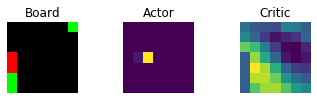

 27%|██▋       | 272/1000 [43:35<47:16,  3.90s/it]

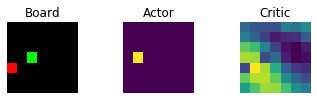

 27%|██▋       | 273/1000 [43:38<45:31,  3.76s/it]

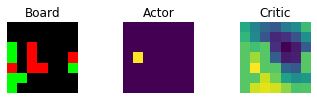

 27%|██▋       | 274/1000 [43:42<45:37,  3.77s/it]

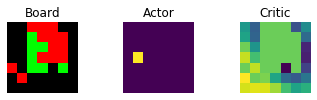

 28%|██▊       | 275/1000 [43:45<43:52,  3.63s/it]

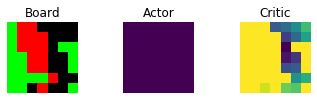

 28%|██▊       | 276/1000 [43:48<41:22,  3.43s/it]

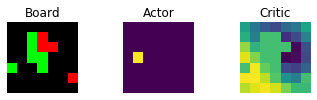

 28%|██▊       | 277/1000 [43:52<40:40,  3.38s/it]

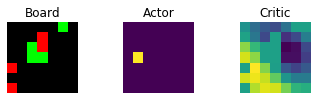

 28%|██▊       | 278/1000 [43:56<43:12,  3.59s/it]

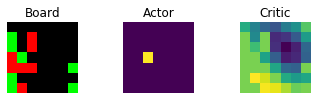

 28%|██▊       | 279/1000 [43:59<43:42,  3.64s/it]

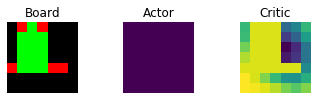

 28%|██▊       | 280/1000 [44:02<41:13,  3.44s/it]

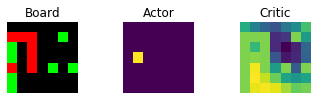

 28%|██▊       | 281/1000 [44:06<40:53,  3.41s/it]

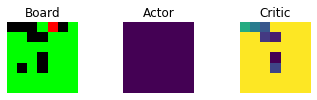

 28%|██▊       | 282/1000 [44:09<40:42,  3.40s/it]

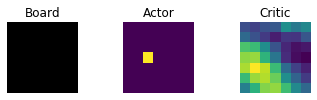

 28%|██▊       | 283/1000 [44:12<39:09,  3.28s/it]

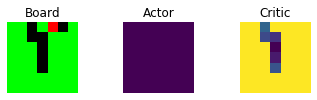

 28%|██▊       | 284/1000 [44:15<39:24,  3.30s/it]

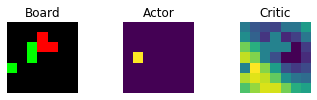

 28%|██▊       | 285/1000 [44:20<44:07,  3.70s/it]

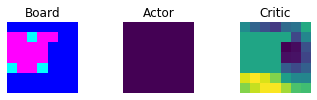

 29%|██▊       | 286/1000 [44:24<45:54,  3.86s/it]

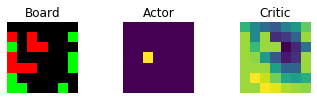

 29%|██▊       | 287/1000 [44:29<50:03,  4.21s/it]

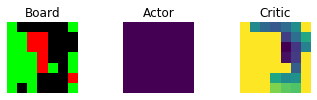

 29%|██▉       | 288/1000 [44:33<46:57,  3.96s/it]

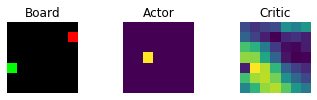

 29%|██▉       | 289/1000 [44:39<54:46,  4.62s/it]

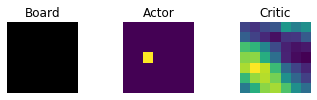

 29%|██▉       | 290/1000 [44:43<52:02,  4.40s/it]

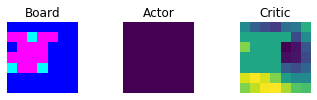

 29%|██▉       | 291/1000 [44:47<51:33,  4.36s/it]

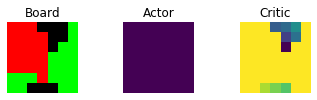

 29%|██▉       | 292/1000 [44:51<49:35,  4.20s/it]

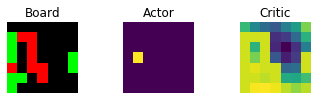

 29%|██▉       | 293/1000 [44:55<49:43,  4.22s/it]

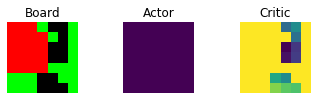

 29%|██▉       | 294/1000 [44:59<48:19,  4.11s/it]

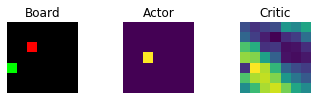

 30%|██▉       | 295/1000 [45:02<45:49,  3.90s/it]

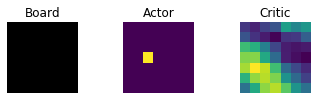

 30%|██▉       | 296/1000 [45:06<43:54,  3.74s/it]

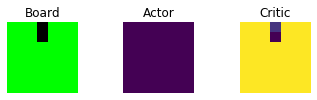

 30%|██▉       | 297/1000 [45:10<45:31,  3.89s/it]

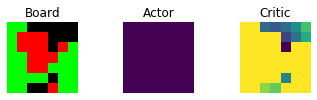

 30%|██▉       | 298/1000 [45:13<42:23,  3.62s/it]

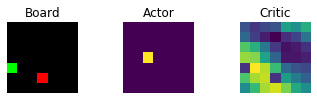

 30%|██▉       | 299/1000 [45:16<40:04,  3.43s/it]

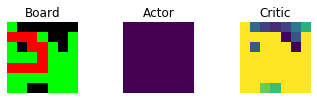

 30%|███       | 300/1000 [45:20<41:22,  3.55s/it]I0708 22:27:29.959430 4554798528 <ipython-input-38-6ec7be6f7e32>:10] Updated opponent


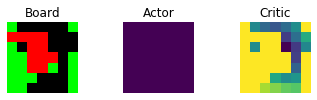

 30%|███       | 301/1000 [45:22<36:49,  3.16s/it]

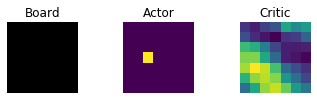

 30%|███       | 302/1000 [45:24<31:53,  2.74s/it]

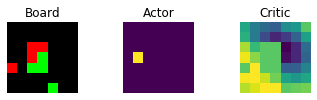

 30%|███       | 303/1000 [45:26<28:24,  2.45s/it]

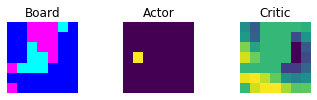

 30%|███       | 304/1000 [45:28<27:23,  2.36s/it]

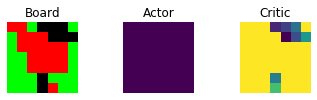

 30%|███       | 305/1000 [45:30<25:14,  2.18s/it]

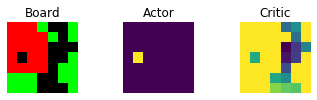

 31%|███       | 306/1000 [45:31<23:43,  2.05s/it]

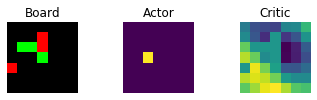

 31%|███       | 307/1000 [45:33<22:41,  1.96s/it]

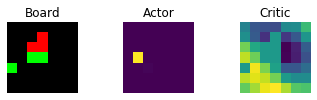

 31%|███       | 308/1000 [45:35<21:59,  1.91s/it]

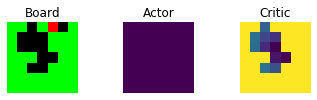

 31%|███       | 309/1000 [45:37<21:28,  1.86s/it]

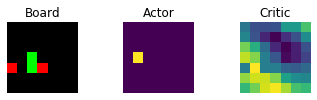

 31%|███       | 310/1000 [45:38<21:07,  1.84s/it]

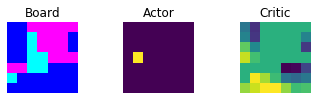

 31%|███       | 311/1000 [45:40<20:49,  1.81s/it]

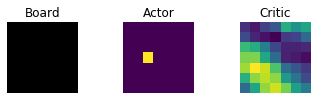

 31%|███       | 312/1000 [45:42<20:43,  1.81s/it]

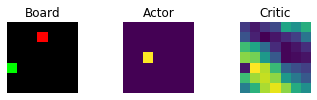

 31%|███▏      | 313/1000 [45:44<20:33,  1.79s/it]

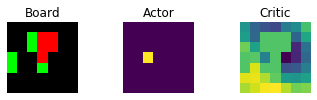

 31%|███▏      | 314/1000 [45:45<20:22,  1.78s/it]

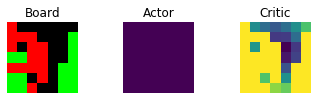

 32%|███▏      | 315/1000 [45:47<20:25,  1.79s/it]

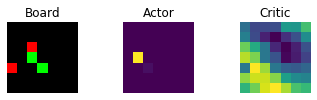

 32%|███▏      | 316/1000 [45:49<20:21,  1.79s/it]

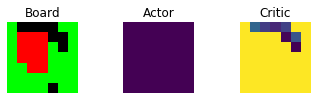

 32%|███▏      | 317/1000 [45:51<20:15,  1.78s/it]

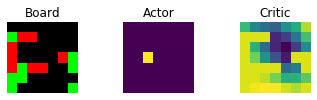

 32%|███▏      | 318/1000 [45:53<20:13,  1.78s/it]

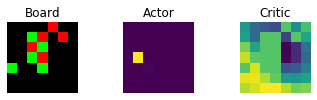

 32%|███▏      | 319/1000 [45:54<20:13,  1.78s/it]

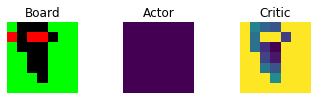

 32%|███▏      | 320/1000 [45:56<20:13,  1.78s/it]

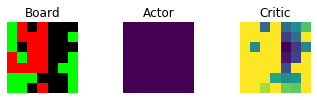

 32%|███▏      | 321/1000 [45:58<20:08,  1.78s/it]

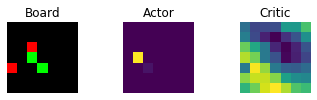

 32%|███▏      | 322/1000 [46:00<20:04,  1.78s/it]

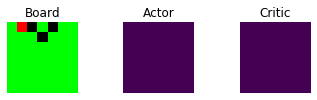

 32%|███▏      | 323/1000 [46:02<21:23,  1.90s/it]

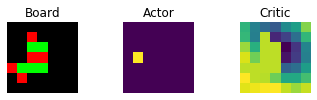

 32%|███▏      | 324/1000 [46:04<20:57,  1.86s/it]

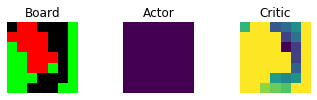

 32%|███▎      | 325/1000 [46:05<20:40,  1.84s/it]

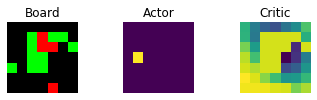

 33%|███▎      | 326/1000 [46:07<20:26,  1.82s/it]

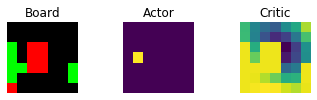

 33%|███▎      | 327/1000 [46:09<20:16,  1.81s/it]

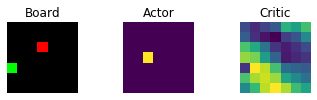

 33%|███▎      | 328/1000 [46:11<20:07,  1.80s/it]

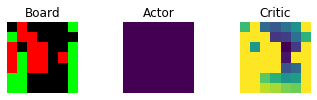

 33%|███▎      | 329/1000 [46:13<20:03,  1.79s/it]

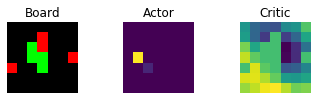

 33%|███▎      | 330/1000 [46:14<20:04,  1.80s/it]

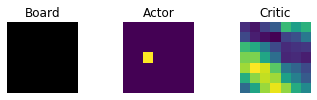

 33%|███▎      | 331/1000 [46:16<20:02,  1.80s/it]

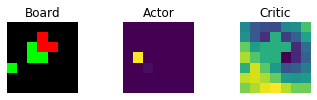

 33%|███▎      | 332/1000 [46:18<21:12,  1.90s/it]

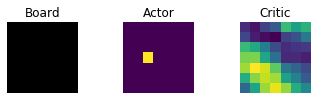

 33%|███▎      | 333/1000 [46:20<20:41,  1.86s/it]

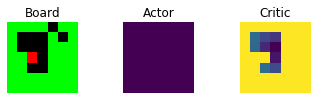

 33%|███▎      | 334/1000 [46:22<20:18,  1.83s/it]

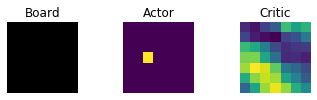

 34%|███▎      | 335/1000 [46:24<20:02,  1.81s/it]

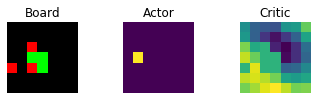

 34%|███▎      | 336/1000 [46:25<19:56,  1.80s/it]

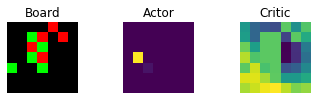

 34%|███▎      | 337/1000 [46:27<19:52,  1.80s/it]

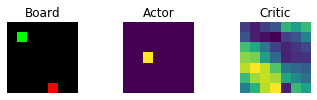

 34%|███▍      | 338/1000 [46:29<21:06,  1.91s/it]

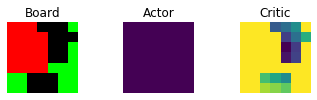

 34%|███▍      | 339/1000 [46:31<20:37,  1.87s/it]

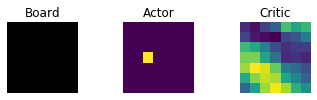

 34%|███▍      | 340/1000 [46:34<23:01,  2.09s/it]

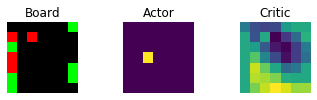

 34%|███▍      | 341/1000 [46:36<22:01,  2.00s/it]

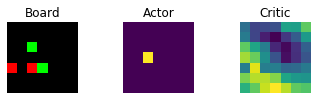

 34%|███▍      | 342/1000 [46:37<21:18,  1.94s/it]

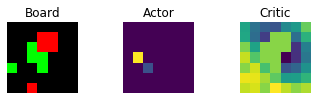

 34%|███▍      | 343/1000 [46:39<20:46,  1.90s/it]

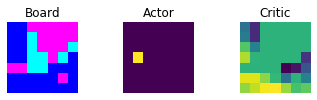

 34%|███▍      | 344/1000 [46:41<20:23,  1.86s/it]

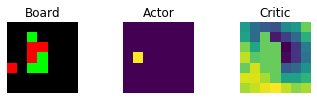

 34%|███▍      | 345/1000 [46:43<21:31,  1.97s/it]

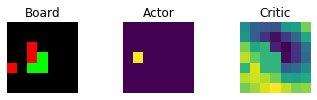

 35%|███▍      | 346/1000 [46:45<20:48,  1.91s/it]

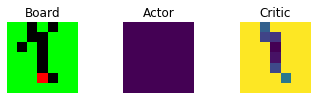

 35%|███▍      | 347/1000 [46:47<21:50,  2.01s/it]

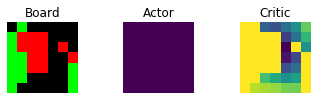

 35%|███▍      | 348/1000 [46:49<21:08,  1.95s/it]

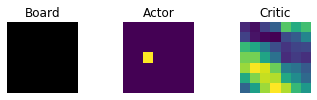

 35%|███▍      | 349/1000 [46:53<27:59,  2.58s/it]

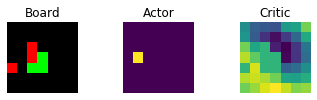

 35%|███▌      | 350/1000 [46:55<26:43,  2.47s/it]

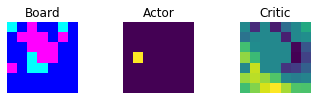

 35%|███▌      | 351/1000 [46:57<24:28,  2.26s/it]

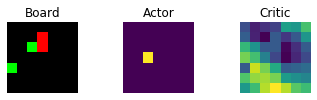

 35%|███▌      | 352/1000 [46:59<25:21,  2.35s/it]

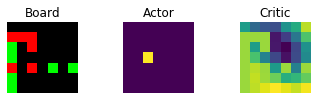

 35%|███▌      | 353/1000 [47:01<23:29,  2.18s/it]

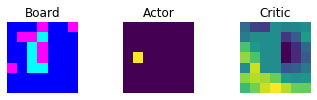

 35%|███▌      | 354/1000 [47:03<23:27,  2.18s/it]

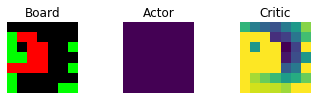

 36%|███▌      | 355/1000 [47:06<23:31,  2.19s/it]

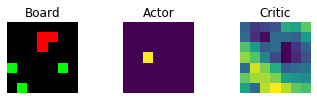

 36%|███▌      | 356/1000 [47:08<22:21,  2.08s/it]

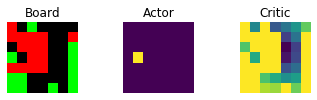

 36%|███▌      | 357/1000 [47:09<21:24,  2.00s/it]

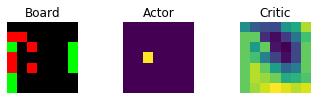

 36%|███▌      | 358/1000 [47:12<22:07,  2.07s/it]

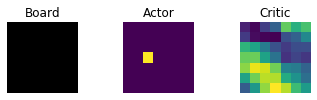

 36%|███▌      | 359/1000 [47:13<21:15,  1.99s/it]

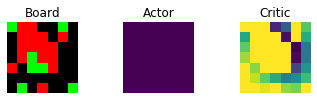

 36%|███▌      | 360/1000 [47:15<20:40,  1.94s/it]

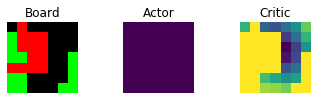

 36%|███▌      | 361/1000 [47:18<22:51,  2.15s/it]

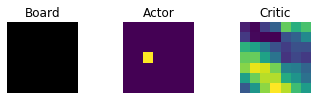

 36%|███▌      | 362/1000 [47:20<21:48,  2.05s/it]

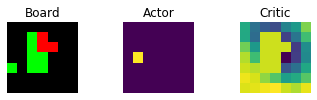

 36%|███▋      | 363/1000 [47:21<21:00,  1.98s/it]

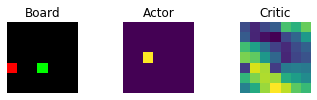

 36%|███▋      | 364/1000 [47:23<20:22,  1.92s/it]

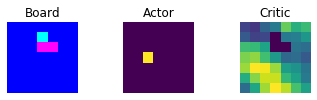

 36%|███▋      | 365/1000 [47:25<19:57,  1.89s/it]

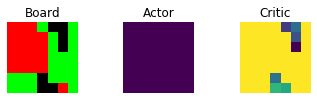

 37%|███▋      | 366/1000 [47:27<20:57,  1.98s/it]

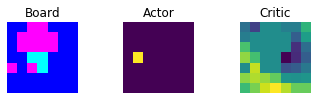

 37%|███▋      | 367/1000 [47:29<21:36,  2.05s/it]

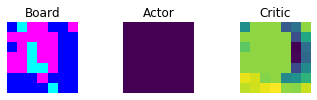

 37%|███▋      | 368/1000 [47:32<22:01,  2.09s/it]

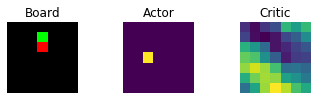

 37%|███▋      | 369/1000 [47:34<22:23,  2.13s/it]

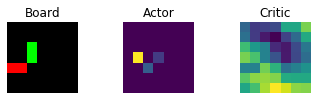

 37%|███▋      | 370/1000 [47:36<22:38,  2.16s/it]

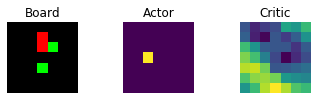

 37%|███▋      | 371/1000 [47:39<24:06,  2.30s/it]

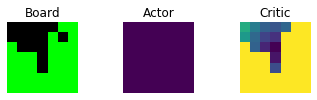

 37%|███▋      | 372/1000 [47:41<23:49,  2.28s/it]

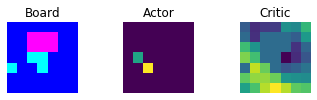

 37%|███▋      | 373/1000 [47:43<23:46,  2.28s/it]

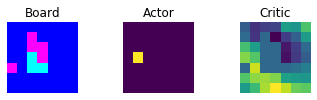

 37%|███▋      | 374/1000 [47:46<24:57,  2.39s/it]

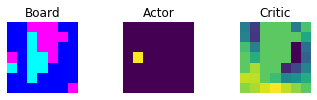

 38%|███▊      | 375/1000 [47:48<23:22,  2.24s/it]

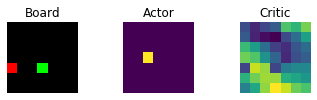

 38%|███▊      | 376/1000 [47:50<23:22,  2.25s/it]

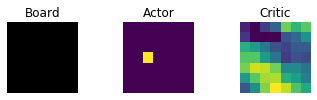

 38%|███▊      | 377/1000 [47:52<22:12,  2.14s/it]

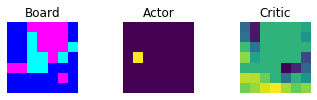

 38%|███▊      | 378/1000 [47:54<22:28,  2.17s/it]

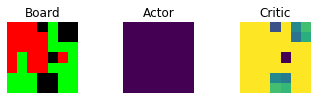

 38%|███▊      | 379/1000 [47:56<21:25,  2.07s/it]

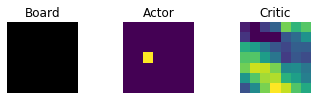

 38%|███▊      | 380/1000 [47:59<23:13,  2.25s/it]

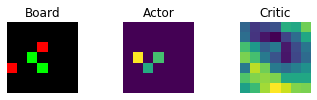

 38%|███▊      | 381/1000 [48:01<22:05,  2.14s/it]

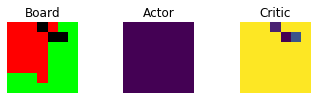

 38%|███▊      | 382/1000 [48:02<21:10,  2.06s/it]

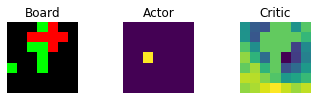

 38%|███▊      | 383/1000 [48:05<21:45,  2.12s/it]

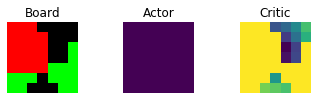

 38%|███▊      | 384/1000 [48:07<22:18,  2.17s/it]

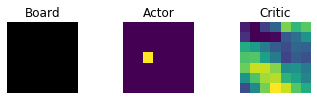

 38%|███▊      | 385/1000 [48:09<22:33,  2.20s/it]

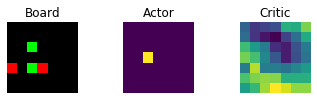

 39%|███▊      | 386/1000 [48:11<21:32,  2.10s/it]

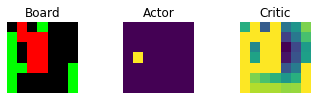

 39%|███▊      | 387/1000 [48:13<20:40,  2.02s/it]

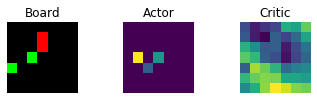

 39%|███▉      | 388/1000 [48:15<20:08,  1.97s/it]

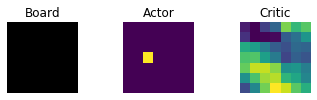

 39%|███▉      | 389/1000 [48:17<19:47,  1.94s/it]

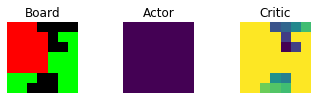

 39%|███▉      | 390/1000 [48:19<19:34,  1.93s/it]

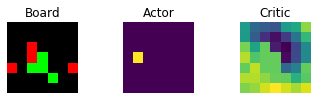

 39%|███▉      | 391/1000 [48:21<21:26,  2.11s/it]

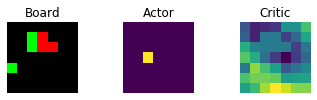

 39%|███▉      | 392/1000 [48:23<20:58,  2.07s/it]

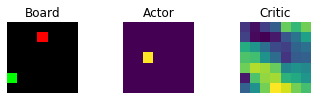

 39%|███▉      | 393/1000 [48:25<20:47,  2.05s/it]

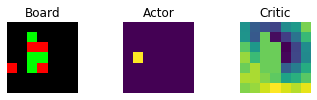

 39%|███▉      | 394/1000 [48:27<20:30,  2.03s/it]

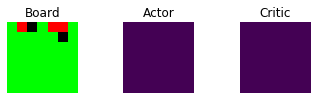

 40%|███▉      | 395/1000 [48:29<21:30,  2.13s/it]

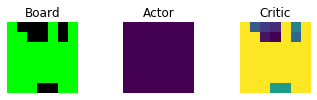

 40%|███▉      | 396/1000 [48:31<21:02,  2.09s/it]

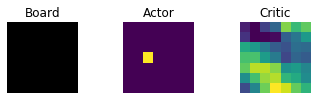

 40%|███▉      | 397/1000 [48:33<20:37,  2.05s/it]

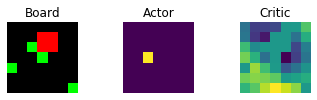

 40%|███▉      | 398/1000 [48:36<22:51,  2.28s/it]

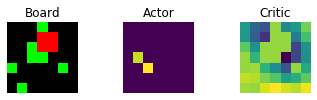

 40%|███▉      | 399/1000 [48:38<21:45,  2.17s/it]

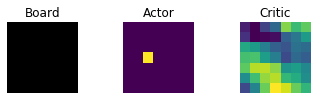

 40%|████      | 400/1000 [48:40<20:48,  2.08s/it]I0708 22:30:50.158479 4554798528 <ipython-input-38-6ec7be6f7e32>:10] Updated opponent


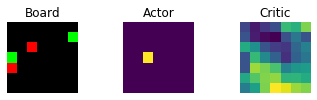

 40%|████      | 401/1000 [48:43<22:56,  2.30s/it]

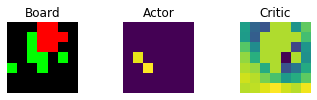

 40%|████      | 402/1000 [48:45<24:05,  2.42s/it]

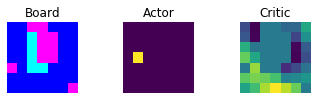

 40%|████      | 403/1000 [48:47<22:41,  2.28s/it]

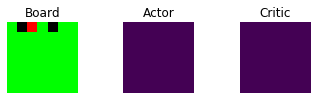

 40%|████      | 404/1000 [48:50<22:38,  2.28s/it]

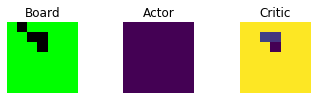

 40%|████      | 405/1000 [48:52<23:10,  2.34s/it]

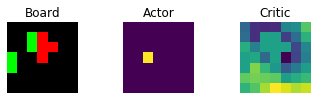

 41%|████      | 406/1000 [48:55<23:10,  2.34s/it]

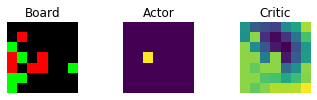

 41%|████      | 407/1000 [48:57<23:19,  2.36s/it]

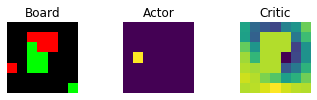

 41%|████      | 408/1000 [48:59<23:23,  2.37s/it]

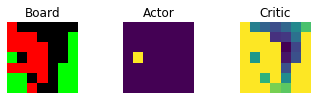

 41%|████      | 409/1000 [49:02<23:17,  2.36s/it]

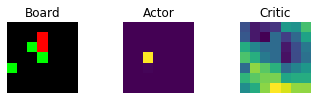

 41%|████      | 410/1000 [49:05<25:21,  2.58s/it]

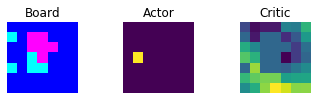

 41%|████      | 411/1000 [49:08<27:20,  2.78s/it]

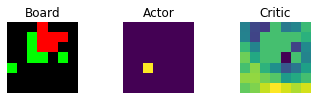

 41%|████      | 412/1000 [49:11<27:15,  2.78s/it]

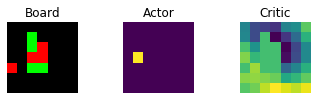

 41%|████▏     | 413/1000 [49:13<25:52,  2.65s/it]

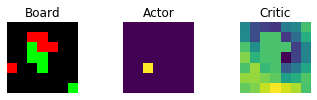

 41%|████▏     | 414/1000 [49:15<23:48,  2.44s/it]

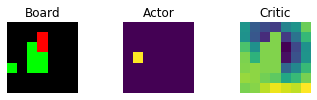

 42%|████▏     | 415/1000 [49:17<23:30,  2.41s/it]

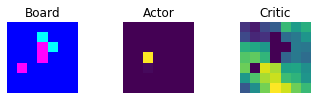

 42%|████▏     | 416/1000 [49:20<23:42,  2.44s/it]

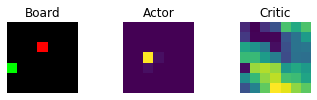

 42%|████▏     | 417/1000 [49:23<26:01,  2.68s/it]

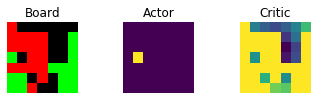

 42%|████▏     | 418/1000 [49:26<26:17,  2.71s/it]

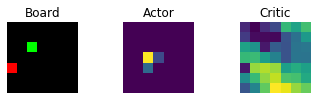

 42%|████▏     | 419/1000 [49:29<27:41,  2.86s/it]

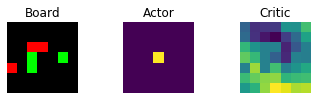

 42%|████▏     | 420/1000 [49:32<26:56,  2.79s/it]

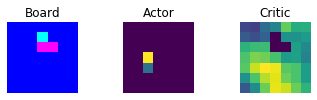

 42%|████▏     | 421/1000 [49:34<26:29,  2.75s/it]

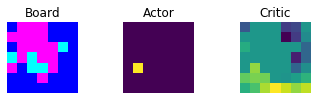

 42%|████▏     | 422/1000 [49:41<36:28,  3.79s/it]

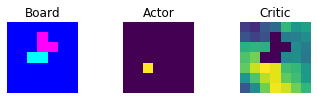

 42%|████▏     | 423/1000 [49:43<33:18,  3.46s/it]

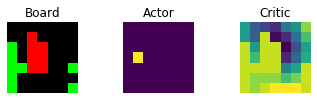

 42%|████▏     | 424/1000 [49:46<30:57,  3.23s/it]

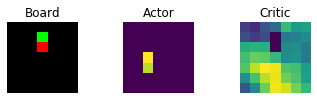

 42%|████▎     | 425/1000 [49:49<29:23,  3.07s/it]

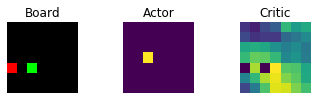

 43%|████▎     | 426/1000 [49:52<29:14,  3.06s/it]

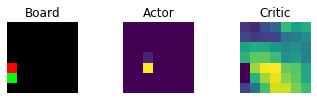

 43%|████▎     | 427/1000 [49:54<28:00,  2.93s/it]

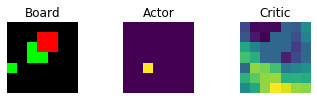

 43%|████▎     | 428/1000 [49:57<28:15,  2.96s/it]

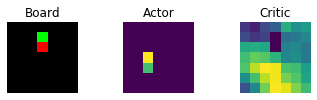

 43%|████▎     | 429/1000 [50:00<27:23,  2.88s/it]

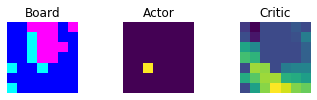

 43%|████▎     | 430/1000 [50:03<26:52,  2.83s/it]

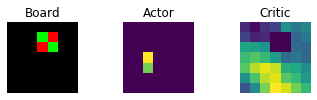

 43%|████▎     | 431/1000 [50:06<26:26,  2.79s/it]

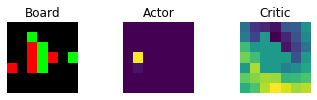

 43%|████▎     | 432/1000 [50:08<26:09,  2.76s/it]

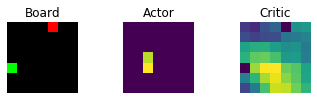

 43%|████▎     | 433/1000 [50:11<27:08,  2.87s/it]

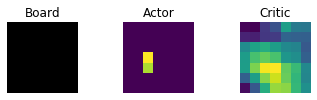

 43%|████▎     | 434/1000 [50:14<26:33,  2.82s/it]

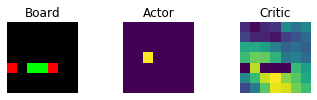

 44%|████▎     | 435/1000 [50:17<27:25,  2.91s/it]

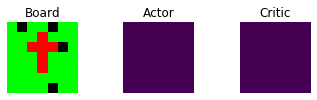

 44%|████▎     | 436/1000 [50:20<26:48,  2.85s/it]

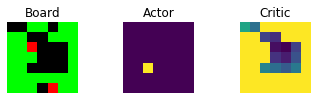

 44%|████▎     | 437/1000 [50:22<25:14,  2.69s/it]

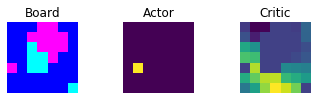

 44%|████▍     | 438/1000 [50:25<25:10,  2.69s/it]

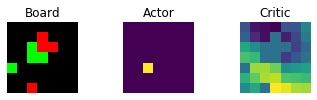

 44%|████▍     | 439/1000 [50:28<25:09,  2.69s/it]

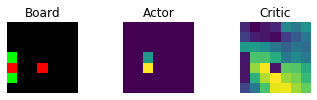

 44%|████▍     | 440/1000 [50:31<26:14,  2.81s/it]

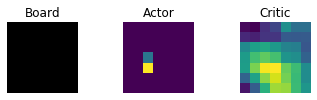

 44%|████▍     | 441/1000 [50:34<28:22,  3.05s/it]

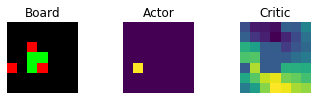

 44%|████▍     | 442/1000 [50:37<27:22,  2.94s/it]

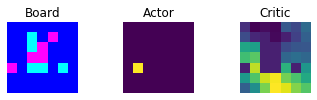

 44%|████▍     | 443/1000 [50:39<25:35,  2.76s/it]

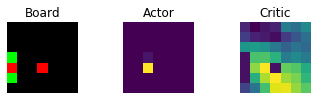

 44%|████▍     | 444/1000 [50:42<24:21,  2.63s/it]

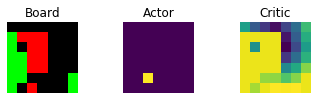

 44%|████▍     | 445/1000 [50:45<25:39,  2.77s/it]

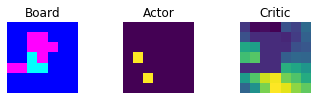

 45%|████▍     | 446/1000 [50:48<28:03,  3.04s/it]

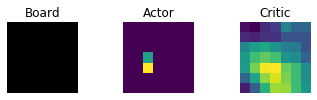

 45%|████▍     | 447/1000 [50:52<28:16,  3.07s/it]

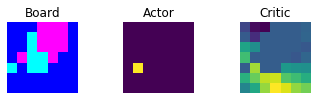

 45%|████▍     | 448/1000 [50:55<28:23,  3.09s/it]

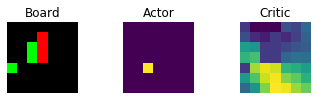

 45%|████▍     | 449/1000 [50:57<27:28,  2.99s/it]

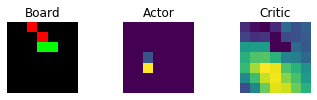

 45%|████▌     | 450/1000 [51:00<26:34,  2.90s/it]

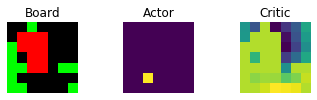

 45%|████▌     | 451/1000 [51:03<27:24,  3.00s/it]

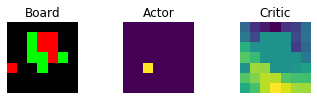

 45%|████▌     | 452/1000 [51:06<27:47,  3.04s/it]

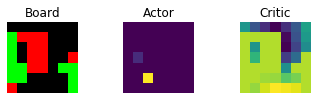

 45%|████▌     | 453/1000 [51:10<30:07,  3.30s/it]

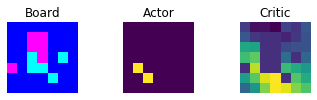

 45%|████▌     | 454/1000 [51:14<31:49,  3.50s/it]

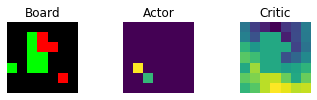

 46%|████▌     | 455/1000 [51:17<29:47,  3.28s/it]

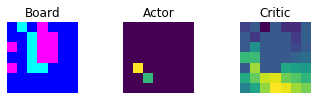

 46%|████▌     | 456/1000 [51:21<30:41,  3.39s/it]

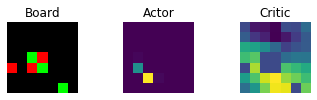

 46%|████▌     | 457/1000 [51:24<31:13,  3.45s/it]

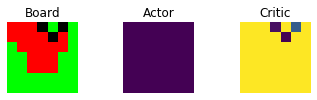

 46%|████▌     | 458/1000 [51:28<31:33,  3.49s/it]

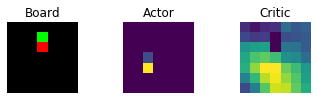

 46%|████▌     | 459/1000 [51:31<31:37,  3.51s/it]

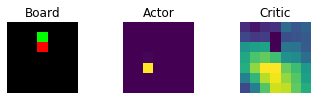

 46%|████▌     | 460/1000 [51:35<31:43,  3.53s/it]

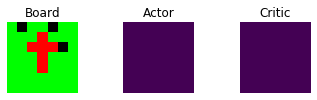

 46%|████▌     | 461/1000 [51:38<29:34,  3.29s/it]

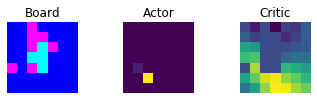

 46%|████▌     | 462/1000 [51:42<32:47,  3.66s/it]

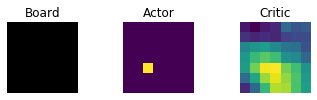

 46%|████▋     | 463/1000 [51:46<33:31,  3.75s/it]

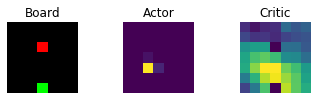

 46%|████▋     | 464/1000 [51:51<35:09,  3.94s/it]

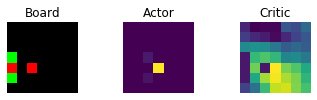

 46%|████▋     | 465/1000 [51:56<38:38,  4.33s/it]

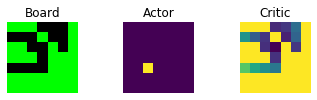

 47%|████▋     | 466/1000 [52:01<39:57,  4.49s/it]

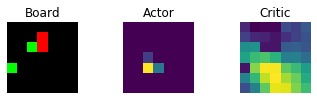

 47%|████▋     | 467/1000 [52:06<43:05,  4.85s/it]

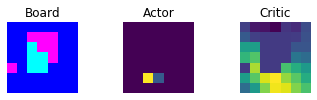

 47%|████▋     | 468/1000 [52:12<44:10,  4.98s/it]

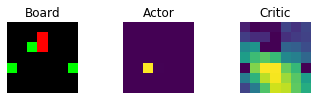

 47%|████▋     | 469/1000 [52:18<47:12,  5.33s/it]

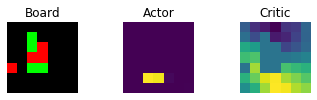

 47%|████▋     | 470/1000 [52:24<48:56,  5.54s/it]

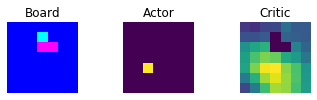

 47%|████▋     | 471/1000 [52:28<45:53,  5.21s/it]

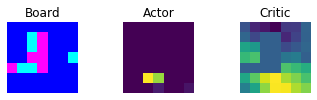

 47%|████▋     | 472/1000 [52:33<44:59,  5.11s/it]

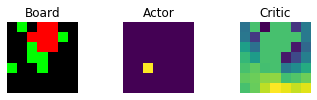

 47%|████▋     | 473/1000 [52:39<45:24,  5.17s/it]

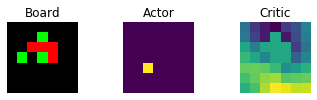

 47%|████▋     | 474/1000 [52:43<44:37,  5.09s/it]

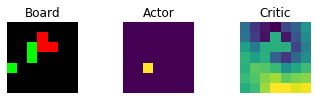

 48%|████▊     | 475/1000 [52:50<48:19,  5.52s/it]

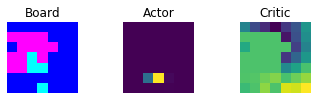

 48%|████▊     | 476/1000 [52:56<48:29,  5.55s/it]

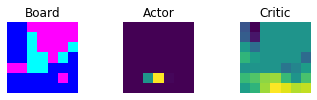

 48%|████▊     | 477/1000 [53:02<51:52,  5.95s/it]

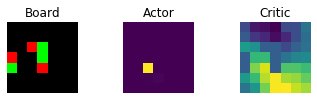

 48%|████▊     | 478/1000 [53:09<54:19,  6.24s/it]

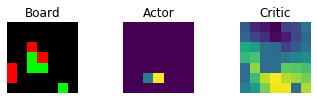

 48%|████▊     | 479/1000 [53:16<54:56,  6.33s/it]

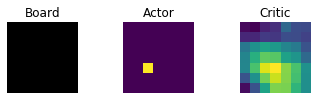

 48%|████▊     | 480/1000 [53:22<53:04,  6.12s/it]

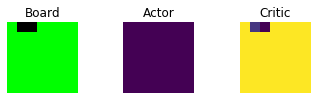

 48%|████▊     | 481/1000 [53:26<49:40,  5.74s/it]

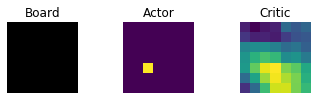

 48%|████▊     | 482/1000 [53:31<47:15,  5.47s/it]

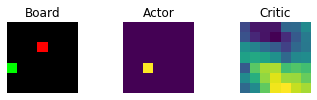

 48%|████▊     | 483/1000 [53:37<47:45,  5.54s/it]

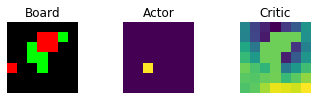

 48%|████▊     | 484/1000 [53:42<46:53,  5.45s/it]

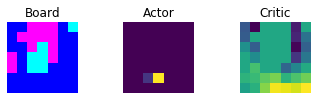

 48%|████▊     | 485/1000 [53:49<51:28,  6.00s/it]

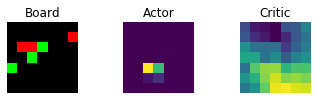

 49%|████▊     | 486/1000 [53:56<52:48,  6.16s/it]

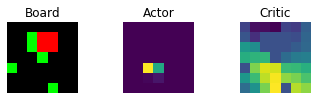

 49%|████▊     | 487/1000 [54:02<52:32,  6.14s/it]

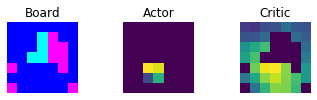

 49%|████▉     | 488/1000 [54:09<53:01,  6.21s/it]

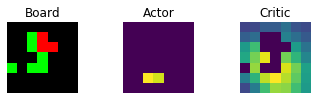

 49%|████▉     | 489/1000 [54:15<52:38,  6.18s/it]

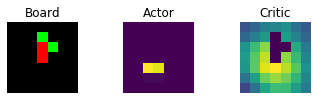

 49%|████▉     | 490/1000 [54:21<52:20,  6.16s/it]

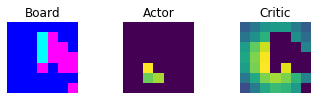

 49%|████▉     | 491/1000 [54:28<54:00,  6.37s/it]

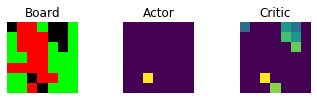

 49%|████▉     | 492/1000 [54:34<54:14,  6.41s/it]

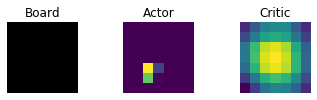

 49%|████▉     | 493/1000 [54:39<50:10,  5.94s/it]

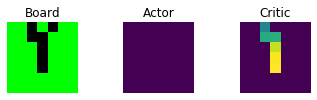

 49%|████▉     | 494/1000 [54:43<46:31,  5.52s/it]

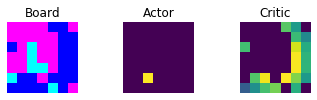

 50%|████▉     | 495/1000 [54:47<41:44,  4.96s/it]

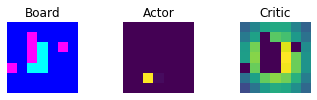

 50%|████▉     | 496/1000 [54:50<37:09,  4.42s/it]

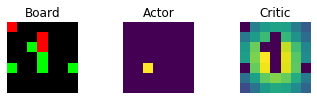

 50%|████▉     | 497/1000 [54:54<34:03,  4.06s/it]

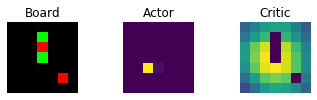

 50%|████▉     | 498/1000 [54:56<30:52,  3.69s/it]

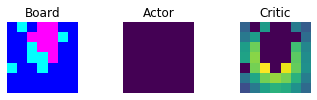

 50%|████▉     | 499/1000 [54:59<28:28,  3.41s/it]

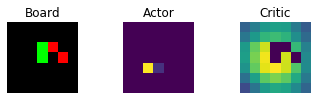

 50%|█████     | 500/1000 [55:01<24:49,  2.98s/it]I0708 22:37:11.411818 4554798528 <ipython-input-38-6ec7be6f7e32>:10] Updated opponent


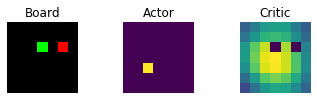

 50%|█████     | 501/1000 [55:03<23:09,  2.79s/it]

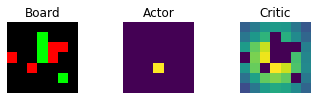

 50%|█████     | 502/1000 [55:05<19:57,  2.41s/it]

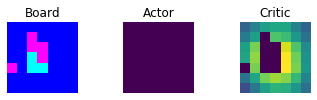

 50%|█████     | 503/1000 [55:07<18:47,  2.27s/it]

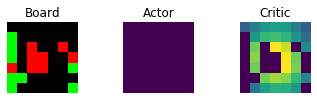

 50%|█████     | 504/1000 [55:08<17:00,  2.06s/it]

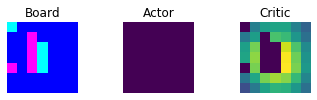

 50%|█████     | 505/1000 [55:10<15:44,  1.91s/it]

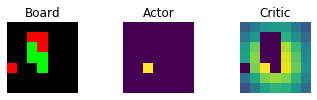

 51%|█████     | 506/1000 [55:12<14:53,  1.81s/it]

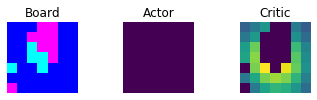

 51%|█████     | 507/1000 [55:13<14:16,  1.74s/it]

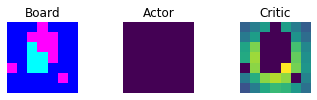

 51%|█████     | 508/1000 [55:15<13:38,  1.66s/it]

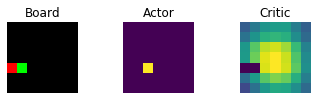

 51%|█████     | 509/1000 [55:16<13:14,  1.62s/it]

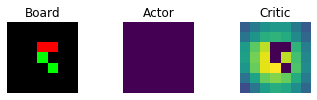

 51%|█████     | 510/1000 [55:21<22:01,  2.70s/it]

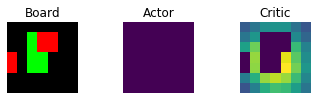

 51%|█████     | 511/1000 [55:23<18:14,  2.24s/it]

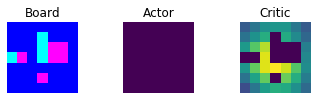

 51%|█████     | 512/1000 [55:24<16:21,  2.01s/it]

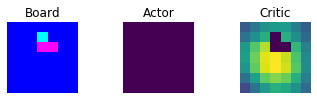

 51%|█████▏    | 513/1000 [55:26<15:59,  1.97s/it]

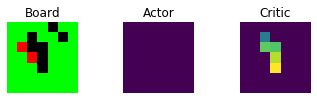

 51%|█████▏    | 514/1000 [55:27<14:59,  1.85s/it]

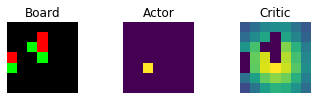

 52%|█████▏    | 515/1000 [55:29<14:21,  1.78s/it]

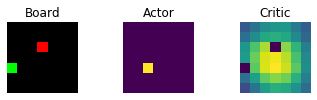

 52%|█████▏    | 516/1000 [55:31<13:49,  1.71s/it]

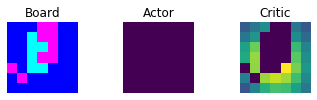

 52%|█████▏    | 517/1000 [55:32<12:20,  1.53s/it]

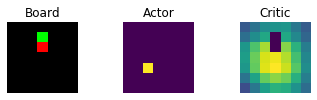

 52%|█████▏    | 518/1000 [55:33<12:16,  1.53s/it]

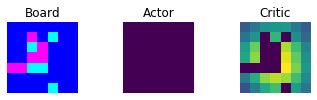

 52%|█████▏    | 519/1000 [55:34<11:13,  1.40s/it]

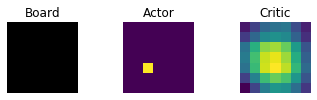

 52%|█████▏    | 520/1000 [55:36<11:27,  1.43s/it]

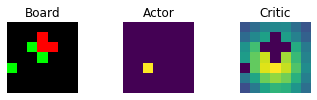

 52%|█████▏    | 521/1000 [55:37<11:39,  1.46s/it]

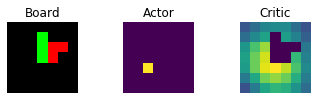

 52%|█████▏    | 522/1000 [55:39<10:49,  1.36s/it]

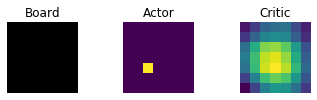

 52%|█████▏    | 523/1000 [55:40<11:20,  1.43s/it]

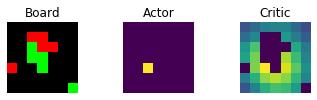

 52%|█████▏    | 524/1000 [55:42<11:36,  1.46s/it]

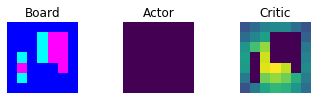

 52%|█████▎    | 525/1000 [55:43<10:45,  1.36s/it]

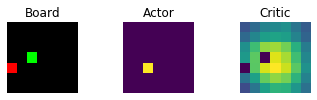

 53%|█████▎    | 526/1000 [55:44<11:07,  1.41s/it]

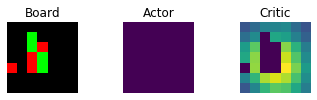

 53%|█████▎    | 527/1000 [55:46<11:25,  1.45s/it]

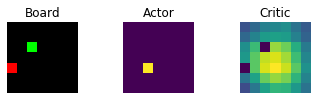

 53%|█████▎    | 528/1000 [55:47<11:37,  1.48s/it]

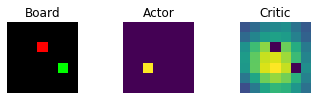

 53%|█████▎    | 529/1000 [55:49<11:42,  1.49s/it]

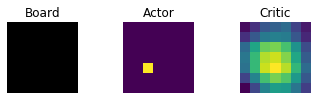

 53%|█████▎    | 530/1000 [55:50<11:45,  1.50s/it]

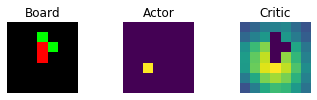

 53%|█████▎    | 531/1000 [55:52<11:47,  1.51s/it]

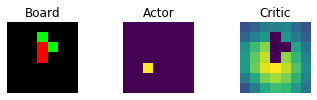

 53%|█████▎    | 532/1000 [55:53<11:03,  1.42s/it]

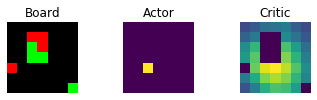

 53%|█████▎    | 533/1000 [55:55<11:20,  1.46s/it]

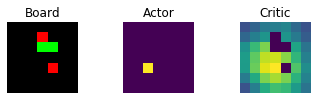

 53%|█████▎    | 534/1000 [55:56<11:31,  1.48s/it]

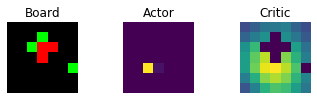

 54%|█████▎    | 535/1000 [55:58<12:32,  1.62s/it]

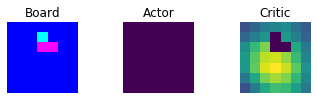

 54%|█████▎    | 536/1000 [56:00<12:18,  1.59s/it]

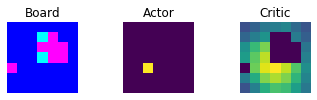

 54%|█████▎    | 537/1000 [56:01<12:09,  1.58s/it]

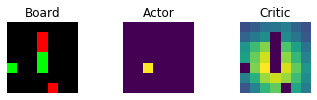

 54%|█████▍    | 538/1000 [56:03<12:01,  1.56s/it]

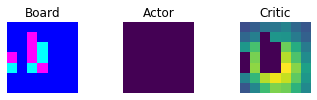

 54%|█████▍    | 539/1000 [56:04<11:57,  1.56s/it]

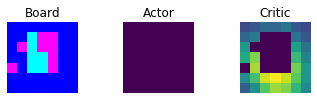

 54%|█████▍    | 540/1000 [56:06<11:51,  1.55s/it]

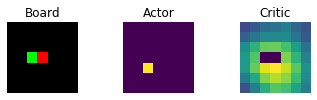

 54%|█████▍    | 541/1000 [56:08<12:42,  1.66s/it]

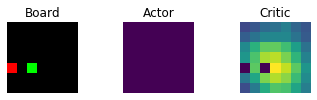

 54%|█████▍    | 542/1000 [56:09<12:24,  1.63s/it]

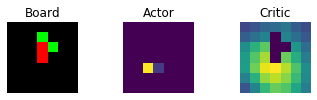

 54%|█████▍    | 543/1000 [56:11<12:11,  1.60s/it]

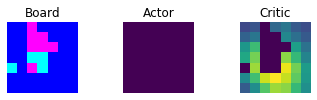

 54%|█████▍    | 544/1000 [56:12<12:01,  1.58s/it]

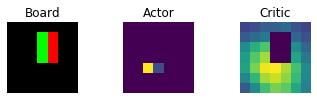

 55%|█████▍    | 545/1000 [56:14<11:52,  1.56s/it]

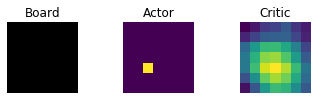

 55%|█████▍    | 546/1000 [56:15<11:44,  1.55s/it]

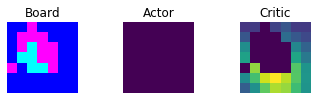

 55%|█████▍    | 547/1000 [56:17<11:38,  1.54s/it]

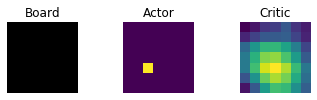

 55%|█████▍    | 548/1000 [56:18<11:33,  1.53s/it]

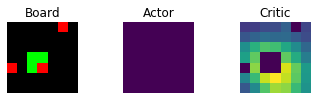

 55%|█████▍    | 549/1000 [56:20<11:37,  1.55s/it]

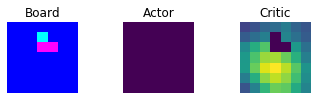

 55%|█████▌    | 550/1000 [56:22<11:31,  1.54s/it]

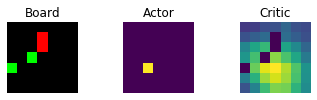

 55%|█████▌    | 551/1000 [56:23<11:37,  1.55s/it]

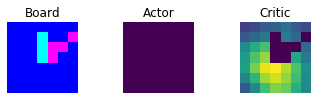

 55%|█████▌    | 552/1000 [56:25<11:33,  1.55s/it]

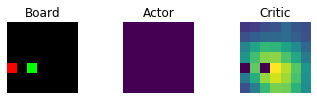

 55%|█████▌    | 553/1000 [56:27<12:25,  1.67s/it]

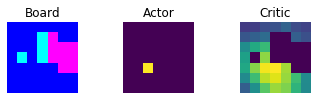

 55%|█████▌    | 554/1000 [56:28<12:08,  1.63s/it]

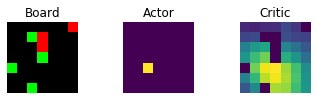

 56%|█████▌    | 555/1000 [56:30<11:54,  1.61s/it]

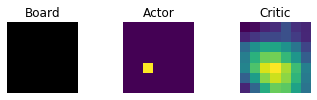

 56%|█████▌    | 556/1000 [56:31<11:44,  1.59s/it]

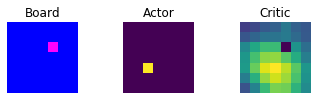

 56%|█████▌    | 557/1000 [56:33<11:38,  1.58s/it]

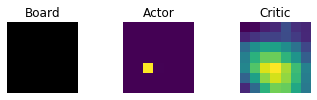

 56%|█████▌    | 558/1000 [56:34<11:34,  1.57s/it]

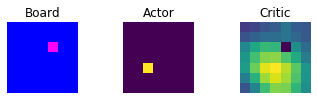

 56%|█████▌    | 559/1000 [56:36<12:23,  1.69s/it]

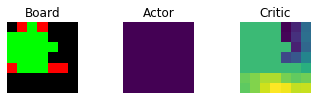

 56%|█████▌    | 560/1000 [56:38<12:57,  1.77s/it]

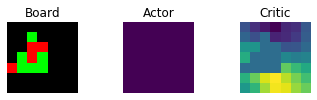

 56%|█████▌    | 561/1000 [56:40<12:26,  1.70s/it]

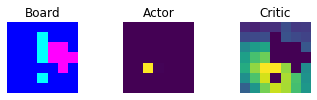

 56%|█████▌    | 562/1000 [56:42<13:57,  1.91s/it]

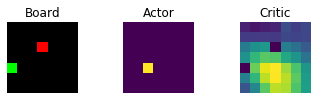

 56%|█████▋    | 563/1000 [56:44<14:00,  1.92s/it]

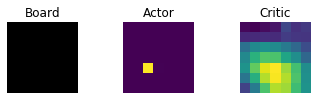

 56%|█████▋    | 564/1000 [56:47<15:01,  2.07s/it]

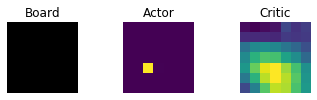

 56%|█████▋    | 565/1000 [56:49<15:40,  2.16s/it]

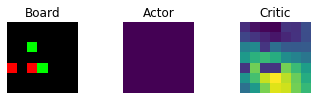

 57%|█████▋    | 566/1000 [56:51<15:18,  2.12s/it]

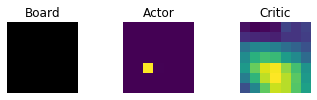

 57%|█████▋    | 567/1000 [56:53<15:01,  2.08s/it]

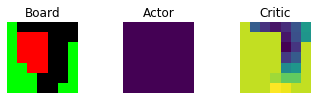

 57%|█████▋    | 568/1000 [56:55<15:35,  2.17s/it]

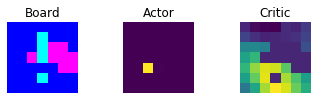

 57%|█████▋    | 569/1000 [56:57<15:10,  2.11s/it]

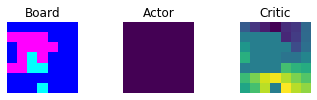

 57%|█████▋    | 570/1000 [56:59<14:50,  2.07s/it]

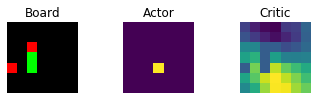

 57%|█████▋    | 571/1000 [57:01<14:34,  2.04s/it]

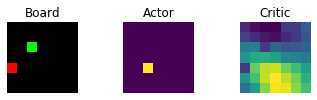

 57%|█████▋    | 572/1000 [57:03<14:22,  2.02s/it]

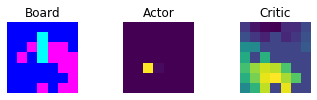

 57%|█████▋    | 573/1000 [57:05<14:13,  2.00s/it]

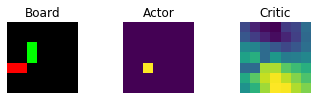

 57%|█████▋    | 574/1000 [57:07<14:12,  2.00s/it]

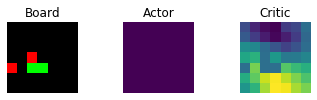

 57%|█████▊    | 575/1000 [57:10<14:53,  2.10s/it]

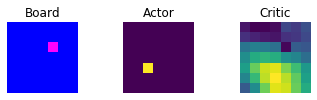

 58%|█████▊    | 576/1000 [57:12<14:37,  2.07s/it]

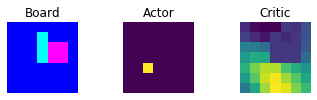

 58%|█████▊    | 577/1000 [57:14<14:28,  2.05s/it]

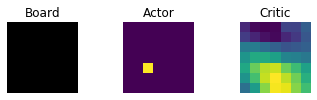

 58%|█████▊    | 578/1000 [57:16<14:21,  2.04s/it]

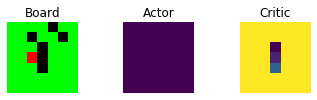

 58%|█████▊    | 579/1000 [57:18<14:17,  2.04s/it]

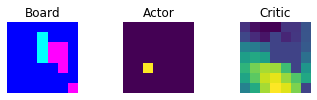

 58%|█████▊    | 580/1000 [57:20<14:13,  2.03s/it]

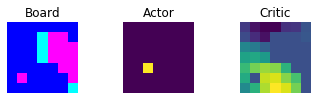

 58%|█████▊    | 581/1000 [57:22<14:10,  2.03s/it]

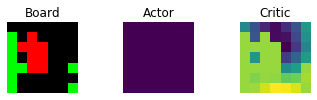

 58%|█████▊    | 582/1000 [57:24<14:56,  2.14s/it]

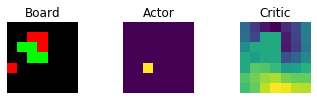

 58%|█████▊    | 583/1000 [57:26<14:39,  2.11s/it]

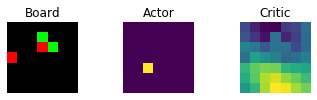

 58%|█████▊    | 584/1000 [57:28<14:24,  2.08s/it]

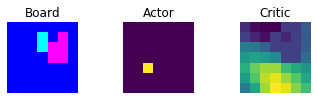

 58%|█████▊    | 585/1000 [57:30<14:15,  2.06s/it]

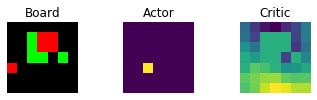

 59%|█████▊    | 586/1000 [57:32<14:08,  2.05s/it]

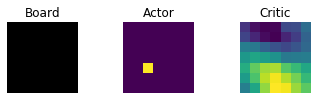

 59%|█████▊    | 587/1000 [57:34<13:59,  2.03s/it]

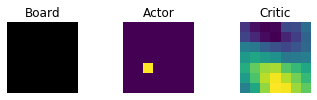

 59%|█████▉    | 588/1000 [57:36<13:57,  2.03s/it]

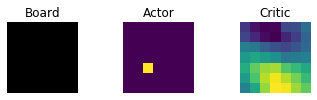

 59%|█████▉    | 589/1000 [57:38<13:59,  2.04s/it]

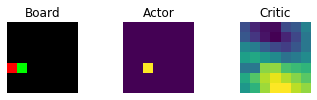

 59%|█████▉    | 590/1000 [57:41<14:46,  2.16s/it]

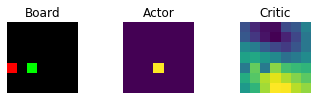

 59%|█████▉    | 591/1000 [57:43<14:20,  2.10s/it]

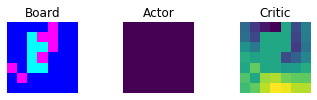

 59%|█████▉    | 592/1000 [57:45<14:00,  2.06s/it]

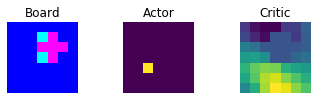

 59%|█████▉    | 593/1000 [57:47<13:54,  2.05s/it]

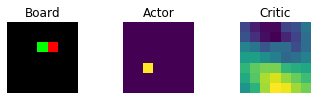

 59%|█████▉    | 594/1000 [57:49<13:47,  2.04s/it]

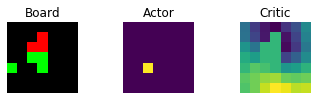

 60%|█████▉    | 595/1000 [57:51<14:31,  2.15s/it]

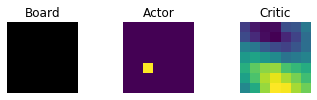

 60%|█████▉    | 596/1000 [57:54<15:06,  2.24s/it]

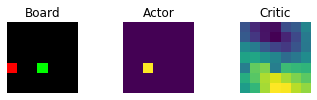

 60%|█████▉    | 597/1000 [57:56<14:38,  2.18s/it]

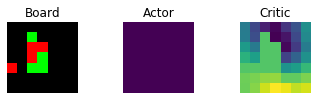

 60%|█████▉    | 598/1000 [57:58<14:13,  2.12s/it]

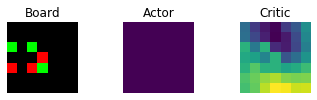

 60%|█████▉    | 599/1000 [58:00<14:01,  2.10s/it]

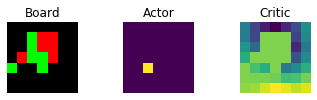

 60%|██████    | 600/1000 [58:02<13:50,  2.08s/it]I0708 22:40:11.964356 4554798528 <ipython-input-38-6ec7be6f7e32>:10] Updated opponent


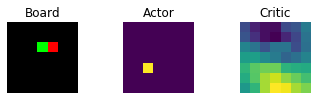

 60%|██████    | 601/1000 [58:04<15:21,  2.31s/it]

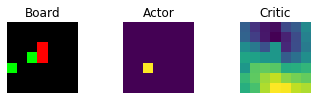

 60%|██████    | 602/1000 [58:07<15:35,  2.35s/it]

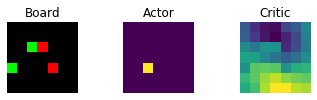

 60%|██████    | 603/1000 [58:09<15:44,  2.38s/it]

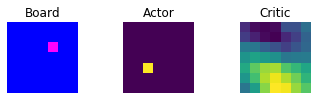

 60%|██████    | 604/1000 [58:11<14:14,  2.16s/it]

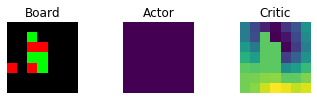

 60%|██████    | 605/1000 [58:13<13:04,  1.99s/it]

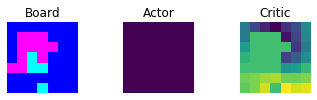

 61%|██████    | 606/1000 [58:14<12:15,  1.87s/it]

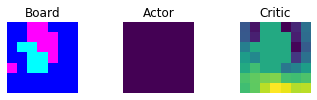

 61%|██████    | 607/1000 [58:16<11:48,  1.80s/it]

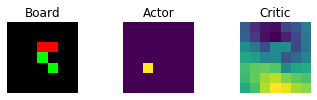

 61%|██████    | 608/1000 [58:18<12:17,  1.88s/it]

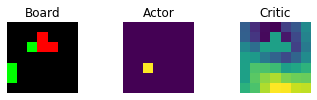

 61%|██████    | 609/1000 [58:20<12:34,  1.93s/it]

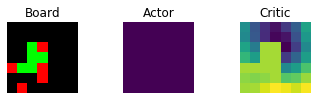

 61%|██████    | 610/1000 [58:22<12:39,  1.95s/it]

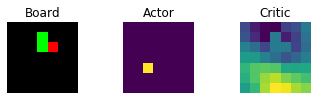

 61%|██████    | 611/1000 [58:24<12:41,  1.96s/it]

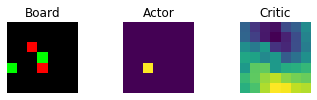

 61%|██████    | 612/1000 [58:26<12:37,  1.95s/it]

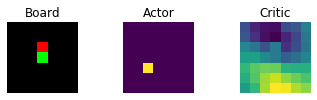

 61%|██████▏   | 613/1000 [58:27<11:51,  1.84s/it]

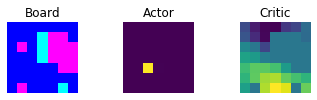

 61%|██████▏   | 614/1000 [58:29<11:17,  1.75s/it]

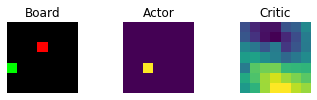

 62%|██████▏   | 615/1000 [58:31<10:57,  1.71s/it]

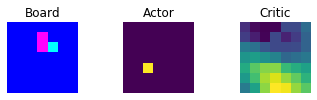

 62%|██████▏   | 616/1000 [58:36<18:57,  2.96s/it]

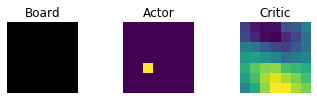

 62%|██████▏   | 617/1000 [58:38<17:01,  2.67s/it]

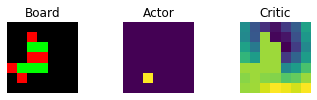

 62%|██████▏   | 618/1000 [58:41<17:14,  2.71s/it]

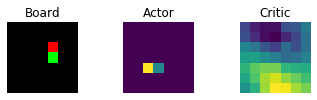

 62%|██████▏   | 619/1000 [58:43<15:50,  2.49s/it]

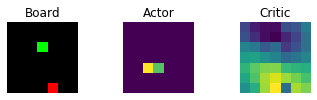

 62%|██████▏   | 620/1000 [58:46<15:27,  2.44s/it]

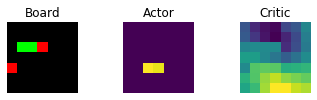

 62%|██████▏   | 621/1000 [58:48<15:20,  2.43s/it]

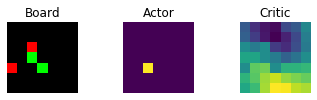

 62%|██████▏   | 622/1000 [58:51<15:53,  2.52s/it]

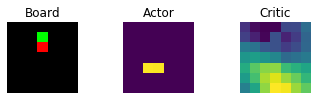

 62%|██████▏   | 623/1000 [58:53<16:18,  2.60s/it]

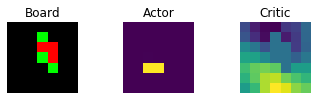

 62%|██████▏   | 624/1000 [58:57<17:14,  2.75s/it]

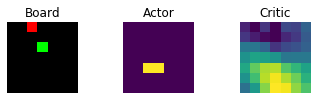

 62%|██████▎   | 625/1000 [59:00<18:29,  2.96s/it]

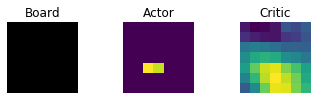

 63%|██████▎   | 626/1000 [59:03<18:46,  3.01s/it]

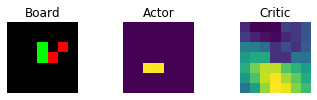

 63%|██████▎   | 627/1000 [59:06<18:07,  2.92s/it]

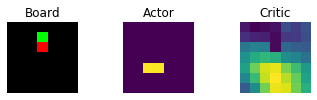

 63%|██████▎   | 628/1000 [59:09<19:17,  3.11s/it]

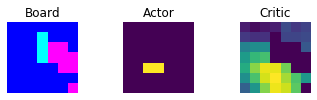

 63%|██████▎   | 629/1000 [59:12<17:50,  2.88s/it]

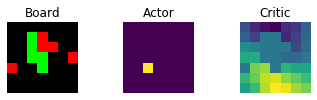

 63%|██████▎   | 630/1000 [59:15<17:33,  2.85s/it]

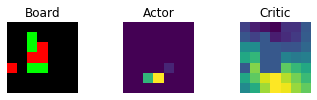

 63%|██████▎   | 631/1000 [59:20<21:45,  3.54s/it]

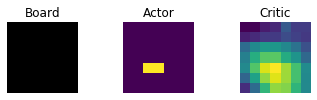

 63%|██████▎   | 632/1000 [59:22<19:36,  3.20s/it]

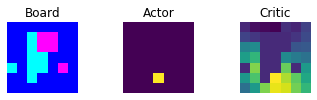

 63%|██████▎   | 633/1000 [59:24<17:57,  2.93s/it]

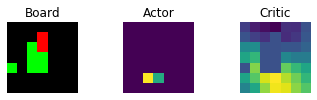

 63%|██████▎   | 634/1000 [59:27<16:47,  2.75s/it]

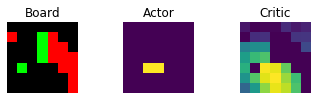

 64%|██████▎   | 635/1000 [59:29<16:00,  2.63s/it]

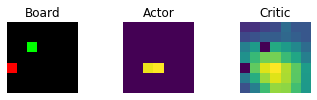

 64%|██████▎   | 636/1000 [59:31<15:27,  2.55s/it]

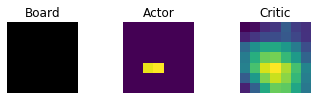

 64%|██████▎   | 637/1000 [59:34<15:50,  2.62s/it]

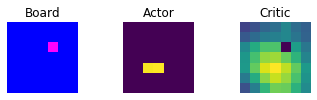

 64%|██████▍   | 638/1000 [59:38<17:26,  2.89s/it]

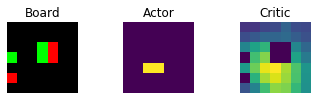

 64%|██████▍   | 639/1000 [59:43<21:01,  3.49s/it]

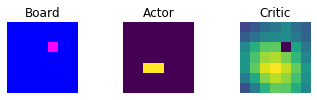

 64%|██████▍   | 640/1000 [59:45<19:36,  3.27s/it]

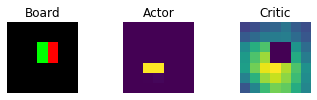

 64%|██████▍   | 641/1000 [59:49<20:18,  3.39s/it]

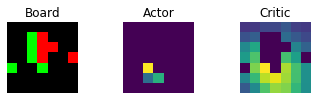

 64%|██████▍   | 642/1000 [59:53<20:28,  3.43s/it]

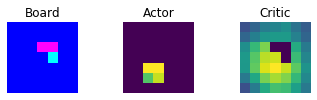

 64%|██████▍   | 643/1000 [59:58<24:18,  4.08s/it]

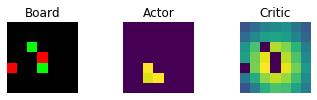

 64%|██████▍   | 644/1000 [1:00:03<24:47,  4.18s/it]

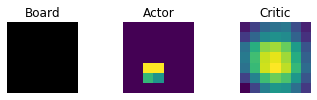

 64%|██████▍   | 645/1000 [1:00:08<26:34,  4.49s/it]

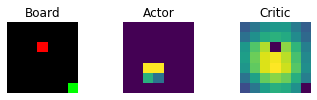

 65%|██████▍   | 646/1000 [1:00:11<24:20,  4.13s/it]

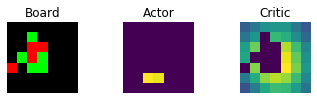

 65%|██████▍   | 647/1000 [1:00:15<24:04,  4.09s/it]

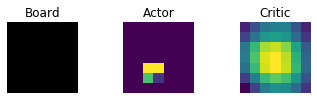

 65%|██████▍   | 648/1000 [1:00:19<23:25,  3.99s/it]

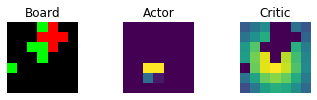

 65%|██████▍   | 649/1000 [1:00:22<21:24,  3.66s/it]

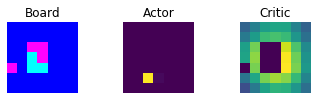

 65%|██████▌   | 650/1000 [1:00:24<19:05,  3.27s/it]

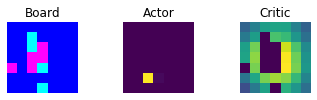

 65%|██████▌   | 651/1000 [1:00:27<17:38,  3.03s/it]

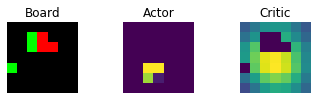

 65%|██████▌   | 652/1000 [1:00:31<19:18,  3.33s/it]

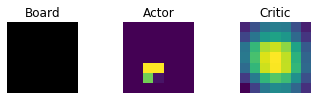

 65%|██████▌   | 653/1000 [1:00:34<19:49,  3.43s/it]

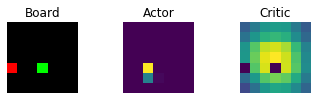

 65%|██████▌   | 654/1000 [1:00:37<18:04,  3.13s/it]

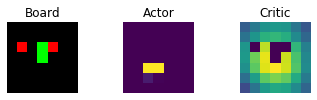

 66%|██████▌   | 655/1000 [1:00:39<16:44,  2.91s/it]

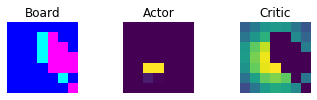

 66%|██████▌   | 656/1000 [1:00:42<15:49,  2.76s/it]

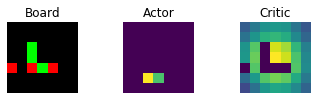

 66%|██████▌   | 657/1000 [1:00:44<15:51,  2.78s/it]

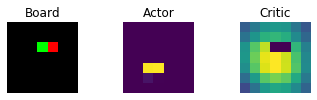

 66%|██████▌   | 658/1000 [1:00:47<15:19,  2.69s/it]

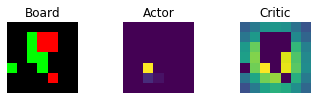

 66%|██████▌   | 659/1000 [1:00:49<14:50,  2.61s/it]

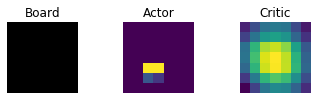

 66%|██████▌   | 660/1000 [1:00:52<14:27,  2.55s/it]

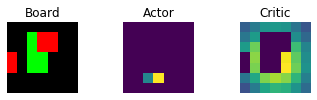

 66%|██████▌   | 661/1000 [1:00:55<16:24,  2.90s/it]

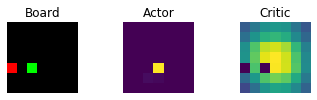

 66%|██████▌   | 662/1000 [1:00:58<16:25,  2.92s/it]

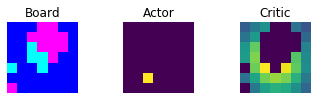

 66%|██████▋   | 663/1000 [1:01:01<15:38,  2.79s/it]

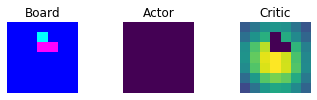

 66%|██████▋   | 664/1000 [1:01:03<14:25,  2.57s/it]

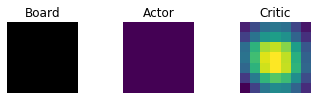

 66%|██████▋   | 665/1000 [1:01:05<13:28,  2.41s/it]

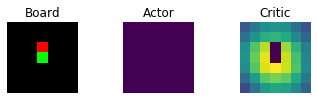

 67%|██████▋   | 666/1000 [1:01:07<13:30,  2.43s/it]

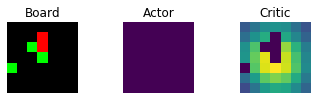

 67%|██████▋   | 667/1000 [1:01:10<13:33,  2.44s/it]

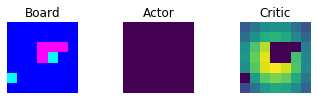

 67%|██████▋   | 668/1000 [1:01:12<12:55,  2.34s/it]

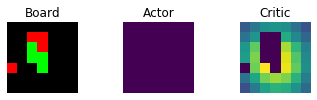

 67%|██████▋   | 669/1000 [1:01:14<12:20,  2.24s/it]

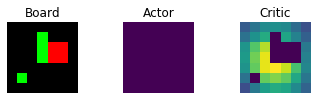

 67%|██████▋   | 670/1000 [1:01:16<12:02,  2.19s/it]

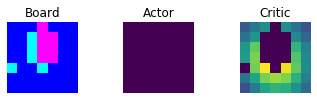

 67%|██████▋   | 671/1000 [1:01:18<11:43,  2.14s/it]

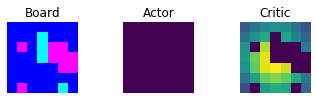

 67%|██████▋   | 672/1000 [1:01:20<11:28,  2.10s/it]

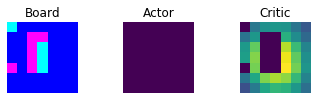

 67%|██████▋   | 673/1000 [1:01:22<11:18,  2.08s/it]

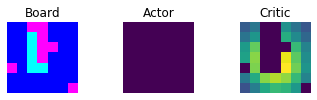

 67%|██████▋   | 674/1000 [1:01:24<11:50,  2.18s/it]

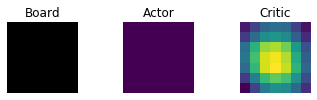

 68%|██████▊   | 675/1000 [1:01:27<11:32,  2.13s/it]

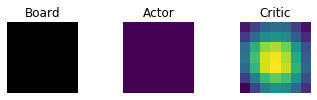

 68%|██████▊   | 676/1000 [1:01:29<11:18,  2.09s/it]

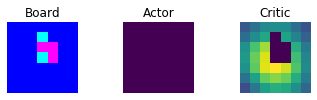

 68%|██████▊   | 677/1000 [1:01:32<13:06,  2.44s/it]

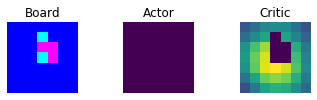

 68%|██████▊   | 678/1000 [1:01:35<15:01,  2.80s/it]

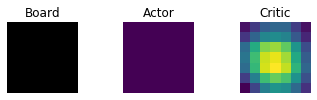

 68%|██████▊   | 679/1000 [1:01:38<13:52,  2.59s/it]

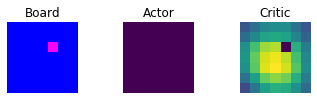

 68%|██████▊   | 680/1000 [1:01:40<12:53,  2.42s/it]

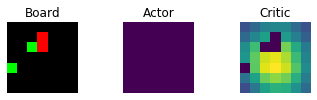

 68%|██████▊   | 681/1000 [1:01:42<12:15,  2.31s/it]

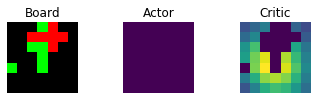

 68%|██████▊   | 682/1000 [1:01:44<11:48,  2.23s/it]

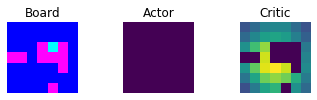

 68%|██████▊   | 683/1000 [1:01:46<12:37,  2.39s/it]

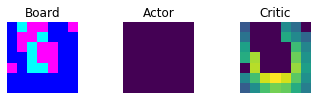

 68%|██████▊   | 684/1000 [1:01:49<12:39,  2.40s/it]

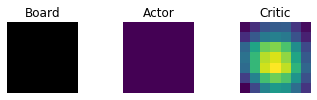

 68%|██████▊   | 685/1000 [1:01:52<13:12,  2.52s/it]

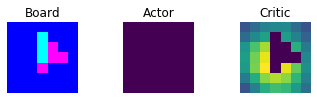

 69%|██████▊   | 686/1000 [1:01:53<11:46,  2.25s/it]

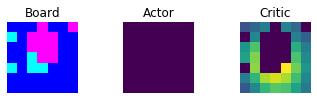

 69%|██████▊   | 687/1000 [1:01:55<11:23,  2.18s/it]

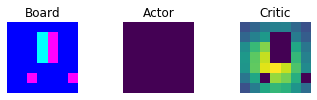

 69%|██████▉   | 688/1000 [1:01:57<11:06,  2.14s/it]

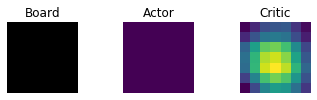

 69%|██████▉   | 689/1000 [1:01:59<10:53,  2.10s/it]

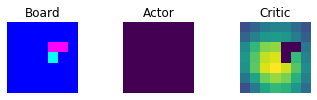

 69%|██████▉   | 690/1000 [1:02:01<10:41,  2.07s/it]

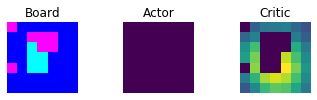

 69%|██████▉   | 691/1000 [1:02:03<10:33,  2.05s/it]

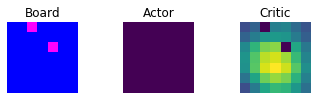

 69%|██████▉   | 692/1000 [1:02:05<10:28,  2.04s/it]

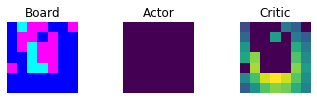

 69%|██████▉   | 693/1000 [1:02:07<10:24,  2.03s/it]

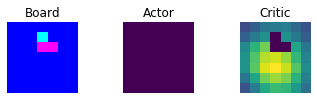

 69%|██████▉   | 694/1000 [1:02:09<10:20,  2.03s/it]

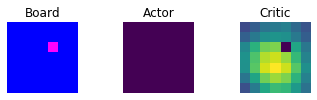

 70%|██████▉   | 695/1000 [1:02:13<12:06,  2.38s/it]

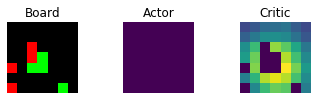

 70%|██████▉   | 696/1000 [1:02:15<11:30,  2.27s/it]

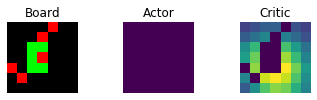

 70%|██████▉   | 697/1000 [1:02:17<11:11,  2.22s/it]

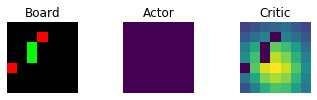

 70%|██████▉   | 698/1000 [1:02:19<10:49,  2.15s/it]

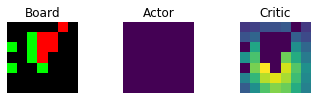

 70%|██████▉   | 699/1000 [1:02:21<10:33,  2.10s/it]

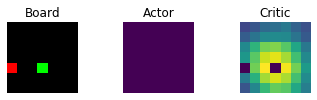

 70%|███████   | 700/1000 [1:02:23<11:32,  2.31s/it]I0708 22:44:33.848453 4554798528 <ipython-input-38-6ec7be6f7e32>:10] Updated opponent


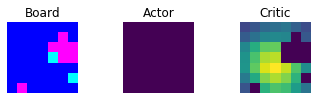

 70%|███████   | 701/1000 [1:02:26<11:14,  2.26s/it]

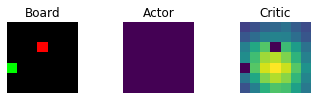

 70%|███████   | 702/1000 [1:02:27<09:39,  1.94s/it]

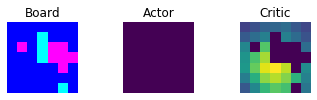

 70%|███████   | 703/1000 [1:02:28<08:32,  1.73s/it]

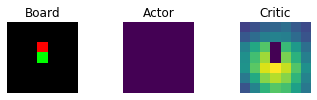

 70%|███████   | 704/1000 [1:02:29<07:46,  1.57s/it]

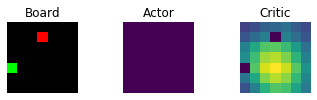

 70%|███████   | 705/1000 [1:02:30<07:13,  1.47s/it]

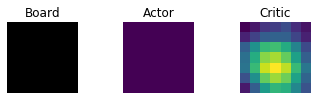

 71%|███████   | 706/1000 [1:02:32<06:49,  1.39s/it]

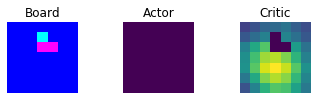

 71%|███████   | 707/1000 [1:02:33<06:32,  1.34s/it]

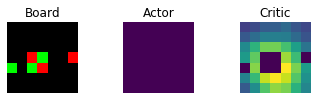

 71%|███████   | 708/1000 [1:02:34<06:21,  1.31s/it]

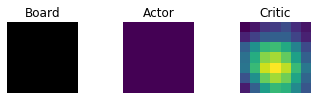

 71%|███████   | 709/1000 [1:02:35<06:12,  1.28s/it]

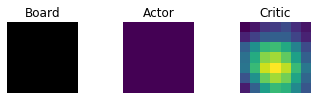

 71%|███████   | 710/1000 [1:02:37<06:06,  1.26s/it]

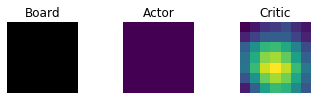

 71%|███████   | 711/1000 [1:02:38<06:01,  1.25s/it]

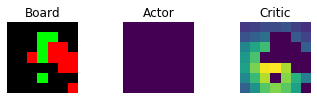

 71%|███████   | 712/1000 [1:02:39<05:59,  1.25s/it]

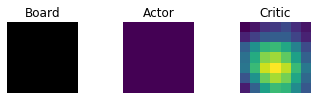

 71%|███████▏  | 713/1000 [1:02:40<05:55,  1.24s/it]

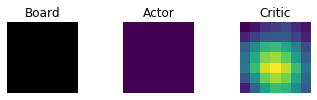

 71%|███████▏  | 714/1000 [1:02:41<05:55,  1.24s/it]

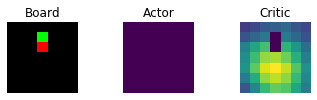

 72%|███████▏  | 715/1000 [1:02:43<05:54,  1.24s/it]

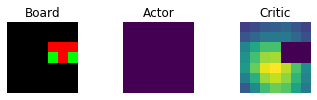

 72%|███████▏  | 716/1000 [1:02:44<05:53,  1.25s/it]

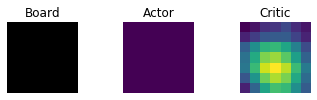

 72%|███████▏  | 717/1000 [1:02:46<06:25,  1.36s/it]

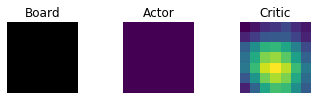

 72%|███████▏  | 718/1000 [1:02:47<06:14,  1.33s/it]

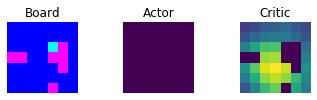

 72%|███████▏  | 719/1000 [1:02:48<06:06,  1.31s/it]

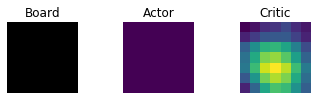

 72%|███████▏  | 720/1000 [1:02:49<05:59,  1.28s/it]

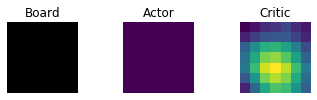

 72%|███████▏  | 721/1000 [1:02:51<06:26,  1.39s/it]

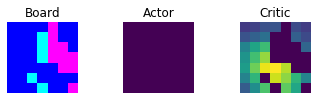

 72%|███████▏  | 722/1000 [1:02:52<06:15,  1.35s/it]

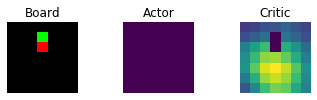

 72%|███████▏  | 723/1000 [1:02:53<06:04,  1.32s/it]

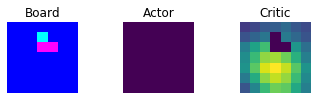

 72%|███████▏  | 724/1000 [1:02:55<05:57,  1.30s/it]

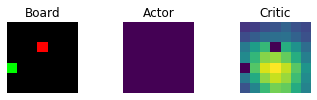

 72%|███████▎  | 725/1000 [1:02:56<05:51,  1.28s/it]

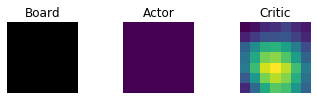

 73%|███████▎  | 726/1000 [1:02:57<05:50,  1.28s/it]

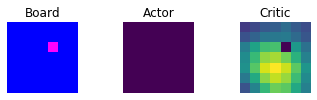

 73%|███████▎  | 727/1000 [1:02:58<05:45,  1.27s/it]

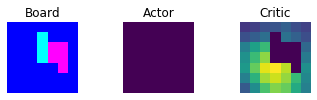

 73%|███████▎  | 728/1000 [1:03:00<05:41,  1.26s/it]

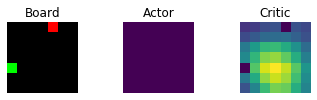

 73%|███████▎  | 729/1000 [1:03:01<05:39,  1.25s/it]

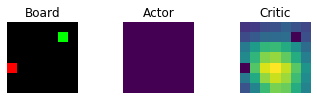

 73%|███████▎  | 730/1000 [1:03:02<05:36,  1.25s/it]

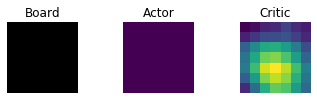

 73%|███████▎  | 731/1000 [1:03:04<06:10,  1.38s/it]

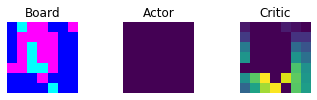

 73%|███████▎  | 732/1000 [1:03:06<07:01,  1.57s/it]

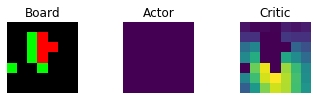

 73%|███████▎  | 733/1000 [1:03:08<07:04,  1.59s/it]

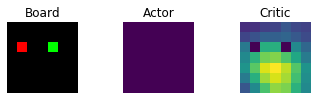

 73%|███████▎  | 734/1000 [1:03:09<06:41,  1.51s/it]

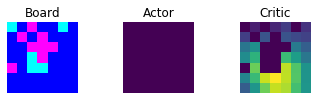

 74%|███████▎  | 735/1000 [1:03:10<06:50,  1.55s/it]

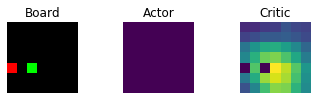

 74%|███████▎  | 736/1000 [1:03:12<06:25,  1.46s/it]

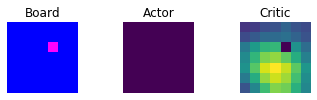

 74%|███████▎  | 737/1000 [1:03:13<06:06,  1.39s/it]

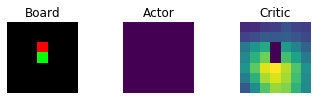

 74%|███████▍  | 738/1000 [1:03:14<05:54,  1.35s/it]

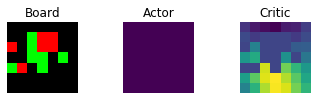

 74%|███████▍  | 739/1000 [1:03:16<06:14,  1.44s/it]

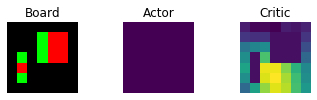

 74%|███████▍  | 740/1000 [1:03:17<05:58,  1.38s/it]

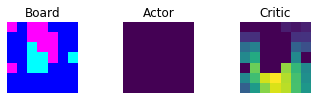

 74%|███████▍  | 741/1000 [1:03:18<05:47,  1.34s/it]

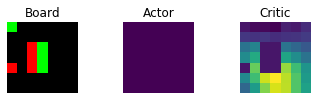

 74%|███████▍  | 742/1000 [1:03:20<05:38,  1.31s/it]

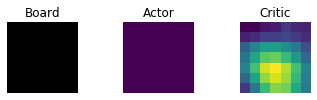

 74%|███████▍  | 743/1000 [1:03:21<05:32,  1.29s/it]

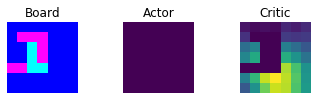

 74%|███████▍  | 744/1000 [1:03:27<11:57,  2.80s/it]

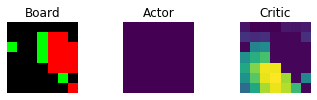

 74%|███████▍  | 745/1000 [1:03:28<09:53,  2.33s/it]

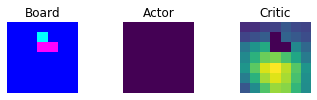

 75%|███████▍  | 746/1000 [1:03:30<08:25,  1.99s/it]

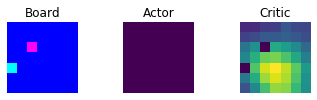

 75%|███████▍  | 747/1000 [1:03:31<07:23,  1.75s/it]

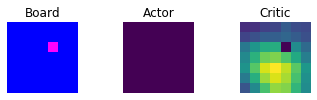

 75%|███████▍  | 748/1000 [1:03:32<06:41,  1.59s/it]

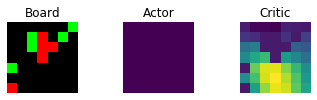

 75%|███████▍  | 749/1000 [1:03:33<06:11,  1.48s/it]

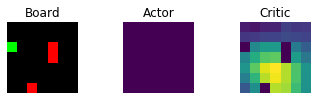

 75%|███████▌  | 750/1000 [1:03:34<05:49,  1.40s/it]

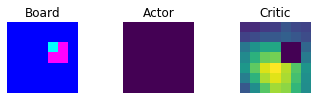

 75%|███████▌  | 751/1000 [1:03:36<05:35,  1.35s/it]

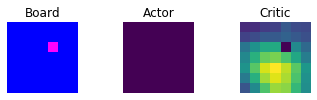

 75%|███████▌  | 752/1000 [1:03:37<05:23,  1.31s/it]

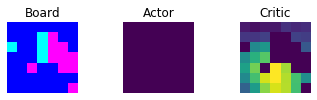

 75%|███████▌  | 753/1000 [1:03:38<05:18,  1.29s/it]

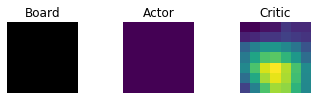

 75%|███████▌  | 754/1000 [1:03:39<05:13,  1.28s/it]

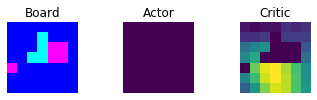

 76%|███████▌  | 755/1000 [1:03:41<05:39,  1.39s/it]

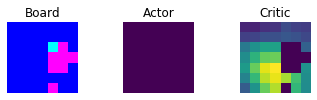

 76%|███████▌  | 756/1000 [1:03:42<05:26,  1.34s/it]

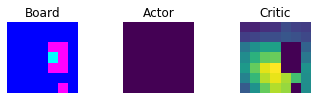

 76%|███████▌  | 757/1000 [1:03:44<05:18,  1.31s/it]

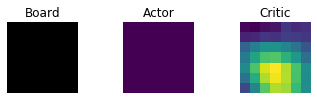

 76%|███████▌  | 758/1000 [1:03:45<05:12,  1.29s/it]

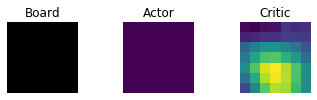

 76%|███████▌  | 759/1000 [1:03:46<05:10,  1.29s/it]

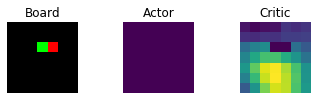

 76%|███████▌  | 760/1000 [1:03:48<05:35,  1.40s/it]

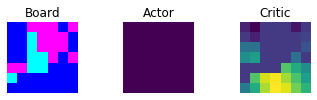

 76%|███████▌  | 761/1000 [1:03:49<05:21,  1.35s/it]

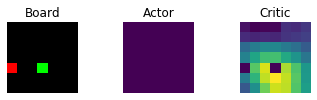

 76%|███████▌  | 762/1000 [1:03:51<05:41,  1.43s/it]

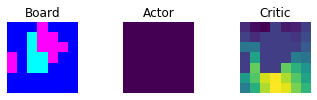

 76%|███████▋  | 763/1000 [1:03:52<05:28,  1.39s/it]

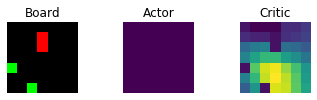

 76%|███████▋  | 764/1000 [1:03:53<05:18,  1.35s/it]

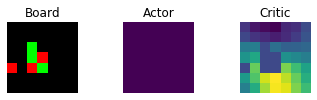

 76%|███████▋  | 765/1000 [1:03:54<05:10,  1.32s/it]

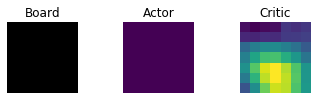

 77%|███████▋  | 766/1000 [1:03:56<05:03,  1.30s/it]

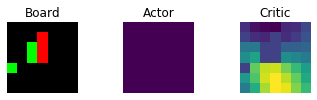

 77%|███████▋  | 767/1000 [1:03:57<04:59,  1.28s/it]

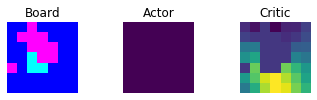

 77%|███████▋  | 768/1000 [1:03:58<04:55,  1.27s/it]

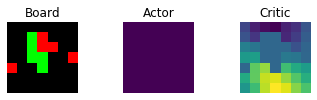

 77%|███████▋  | 769/1000 [1:03:59<04:53,  1.27s/it]

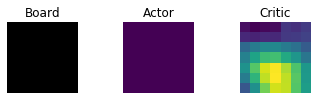

 77%|███████▋  | 770/1000 [1:04:01<04:51,  1.27s/it]

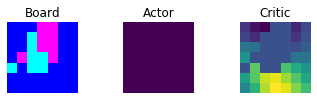

 77%|███████▋  | 771/1000 [1:04:02<04:49,  1.27s/it]

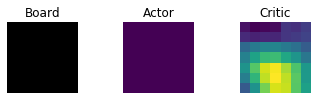

 77%|███████▋  | 772/1000 [1:04:04<05:15,  1.38s/it]

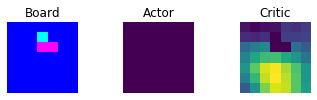

 77%|███████▋  | 773/1000 [1:04:05<05:05,  1.35s/it]

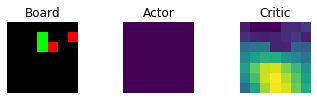

 77%|███████▋  | 774/1000 [1:04:06<04:58,  1.32s/it]

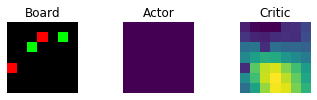

 78%|███████▊  | 775/1000 [1:04:07<04:53,  1.30s/it]

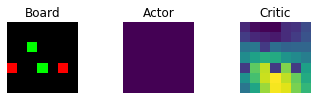

 78%|███████▊  | 776/1000 [1:04:09<05:14,  1.41s/it]

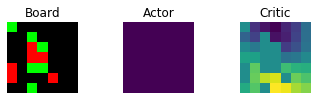

 78%|███████▊  | 777/1000 [1:04:10<05:04,  1.36s/it]

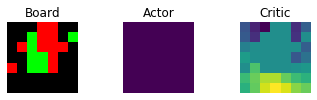

 78%|███████▊  | 778/1000 [1:04:11<04:55,  1.33s/it]

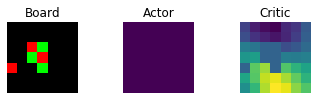

 78%|███████▊  | 779/1000 [1:04:14<05:44,  1.56s/it]

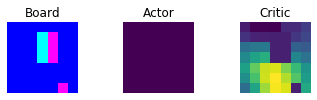

 78%|███████▊  | 780/1000 [1:04:15<05:24,  1.47s/it]

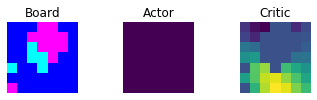

 78%|███████▊  | 781/1000 [1:04:16<05:09,  1.41s/it]

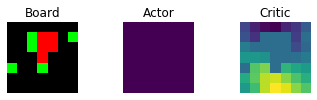

 78%|███████▊  | 782/1000 [1:04:17<05:04,  1.40s/it]

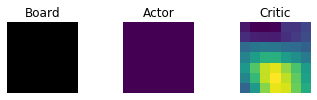

 78%|███████▊  | 783/1000 [1:04:19<04:55,  1.36s/it]

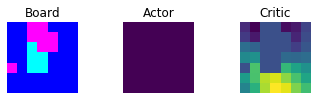

 78%|███████▊  | 784/1000 [1:04:20<04:49,  1.34s/it]

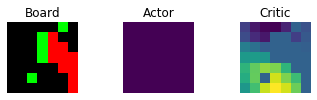

 78%|███████▊  | 785/1000 [1:04:21<04:44,  1.32s/it]

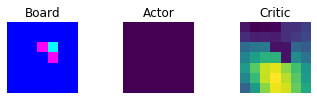

 79%|███████▊  | 786/1000 [1:04:23<04:39,  1.31s/it]

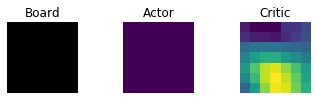

 79%|███████▊  | 787/1000 [1:04:24<04:36,  1.30s/it]

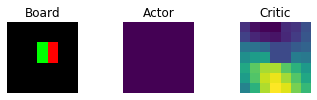

 79%|███████▉  | 788/1000 [1:04:25<04:33,  1.29s/it]

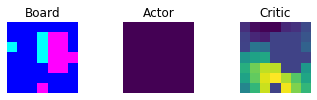

 79%|███████▉  | 789/1000 [1:04:26<04:31,  1.29s/it]

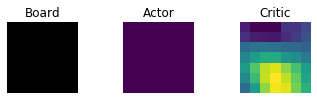

 79%|███████▉  | 790/1000 [1:04:28<04:29,  1.28s/it]

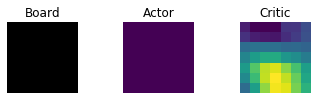

 79%|███████▉  | 791/1000 [1:04:29<04:27,  1.28s/it]

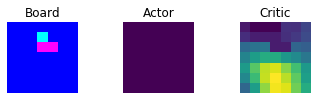

 79%|███████▉  | 792/1000 [1:04:30<04:25,  1.28s/it]

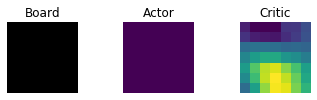

 79%|███████▉  | 793/1000 [1:04:32<04:23,  1.27s/it]

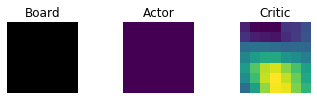

 79%|███████▉  | 794/1000 [1:04:33<04:22,  1.27s/it]

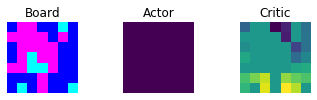

 80%|███████▉  | 795/1000 [1:04:34<04:45,  1.39s/it]

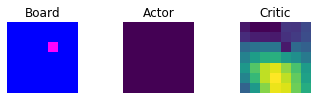

 80%|███████▉  | 796/1000 [1:04:36<04:38,  1.36s/it]

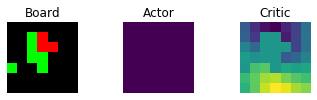

 80%|███████▉  | 797/1000 [1:04:37<04:32,  1.34s/it]

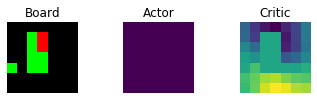

 80%|███████▉  | 798/1000 [1:04:38<04:27,  1.32s/it]

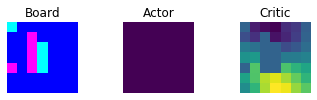

 80%|███████▉  | 799/1000 [1:04:40<04:24,  1.31s/it]

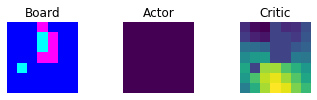

 80%|████████  | 800/1000 [1:04:41<04:22,  1.31s/it]I0708 22:46:51.337071 4554798528 <ipython-input-38-6ec7be6f7e32>:10] Updated opponent


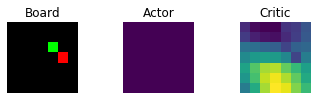

 80%|████████  | 801/1000 [1:04:43<05:08,  1.55s/it]

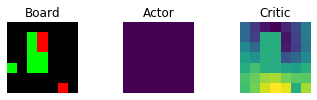

 80%|████████  | 802/1000 [1:04:45<05:15,  1.59s/it]

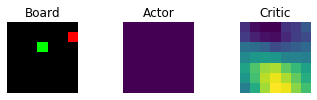

 80%|████████  | 803/1000 [1:04:46<05:20,  1.63s/it]

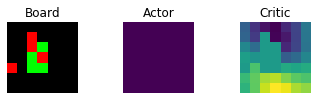

 80%|████████  | 804/1000 [1:04:48<04:58,  1.53s/it]

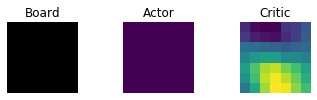

 80%|████████  | 805/1000 [1:04:49<04:43,  1.45s/it]

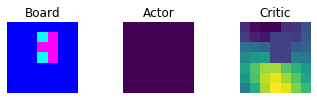

 81%|████████  | 806/1000 [1:04:50<04:31,  1.40s/it]

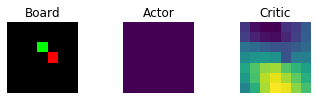

 81%|████████  | 807/1000 [1:04:52<04:23,  1.37s/it]

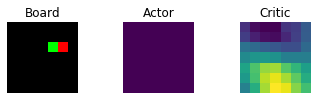

 81%|████████  | 808/1000 [1:04:53<04:18,  1.35s/it]

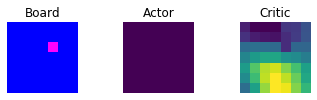

 81%|████████  | 809/1000 [1:04:55<04:36,  1.45s/it]

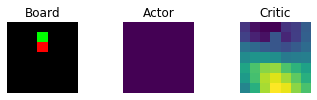

 81%|████████  | 810/1000 [1:04:56<04:26,  1.40s/it]

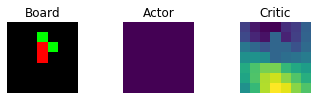

 81%|████████  | 811/1000 [1:04:57<04:19,  1.38s/it]

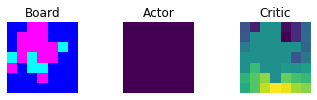

 81%|████████  | 812/1000 [1:04:58<04:15,  1.36s/it]

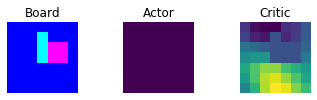

 81%|████████▏ | 813/1000 [1:05:00<04:09,  1.33s/it]

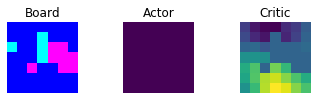

 81%|████████▏ | 814/1000 [1:05:01<04:04,  1.32s/it]

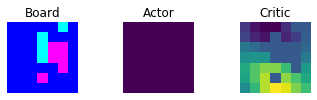

 82%|████████▏ | 815/1000 [1:05:02<04:00,  1.30s/it]

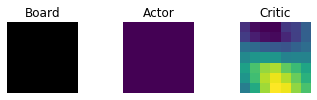

 82%|████████▏ | 816/1000 [1:05:04<03:58,  1.29s/it]

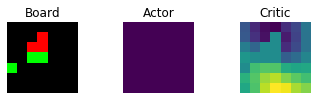

 82%|████████▏ | 817/1000 [1:05:06<04:41,  1.54s/it]

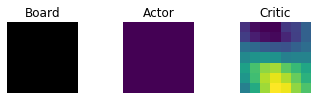

 82%|████████▏ | 818/1000 [1:05:07<04:25,  1.46s/it]

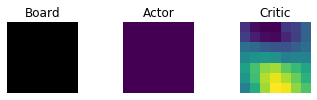

 82%|████████▏ | 819/1000 [1:05:08<04:14,  1.41s/it]

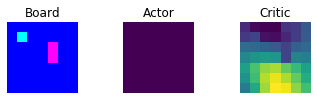

 82%|████████▏ | 820/1000 [1:05:10<04:06,  1.37s/it]

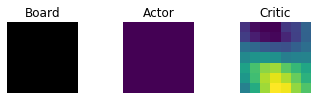

 82%|████████▏ | 821/1000 [1:05:11<04:00,  1.35s/it]

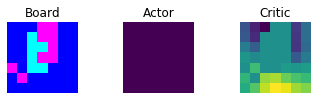

 82%|████████▏ | 822/1000 [1:05:12<03:56,  1.33s/it]

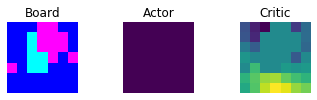

 82%|████████▏ | 823/1000 [1:05:13<03:52,  1.32s/it]

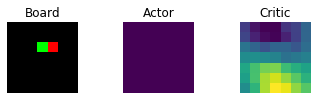

 82%|████████▏ | 824/1000 [1:05:15<03:49,  1.31s/it]

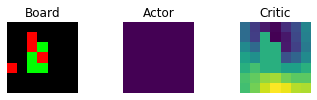

 82%|████████▎ | 825/1000 [1:05:16<03:47,  1.30s/it]

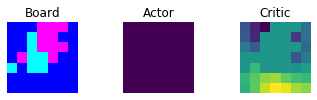

 83%|████████▎ | 826/1000 [1:05:17<03:45,  1.29s/it]

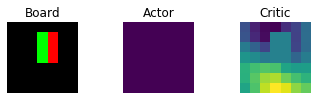

 83%|████████▎ | 827/1000 [1:05:19<04:04,  1.41s/it]

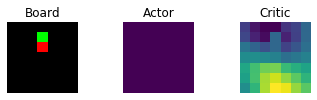

 83%|████████▎ | 828/1000 [1:05:20<03:56,  1.38s/it]

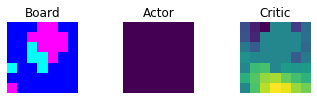

 83%|████████▎ | 829/1000 [1:05:22<03:51,  1.35s/it]

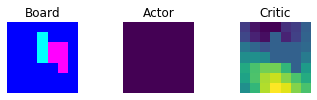

 83%|████████▎ | 830/1000 [1:05:23<03:46,  1.33s/it]

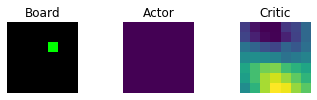

 83%|████████▎ | 831/1000 [1:05:24<03:43,  1.32s/it]

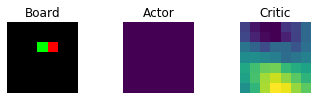

 83%|████████▎ | 832/1000 [1:05:25<03:40,  1.31s/it]

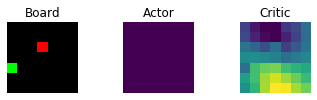

 83%|████████▎ | 833/1000 [1:05:27<03:38,  1.31s/it]

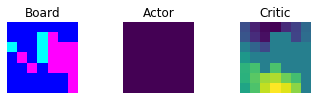

 83%|████████▎ | 834/1000 [1:05:28<03:36,  1.30s/it]

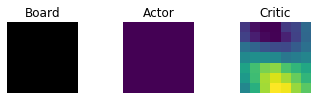

 84%|████████▎ | 835/1000 [1:05:29<03:33,  1.30s/it]

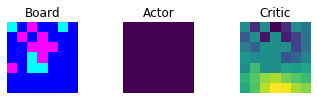

 84%|████████▎ | 836/1000 [1:05:31<03:32,  1.29s/it]

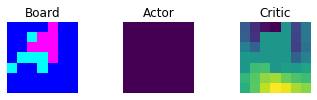

 84%|████████▎ | 837/1000 [1:05:32<03:29,  1.29s/it]

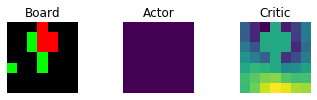

 84%|████████▍ | 838/1000 [1:05:33<03:29,  1.29s/it]

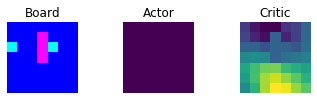

 84%|████████▍ | 839/1000 [1:05:34<03:27,  1.29s/it]

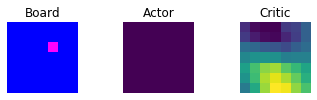

 84%|████████▍ | 840/1000 [1:05:36<03:27,  1.30s/it]

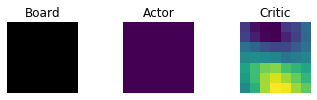

 84%|████████▍ | 841/1000 [1:05:37<03:26,  1.30s/it]

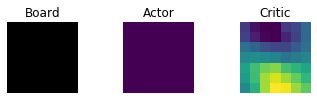

 84%|████████▍ | 842/1000 [1:05:38<03:21,  1.28s/it]

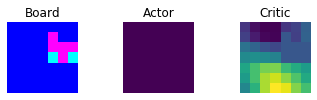

 84%|████████▍ | 843/1000 [1:05:40<03:19,  1.27s/it]

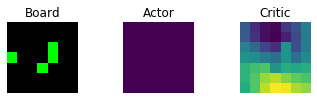

 84%|████████▍ | 844/1000 [1:05:41<03:20,  1.28s/it]

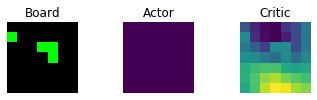

 84%|████████▍ | 845/1000 [1:05:42<03:20,  1.29s/it]

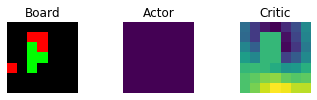

 85%|████████▍ | 846/1000 [1:05:43<03:19,  1.30s/it]

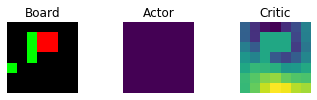

 85%|████████▍ | 847/1000 [1:05:45<03:18,  1.30s/it]

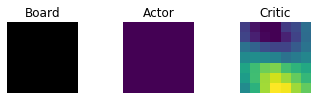

 85%|████████▍ | 848/1000 [1:05:46<03:19,  1.31s/it]

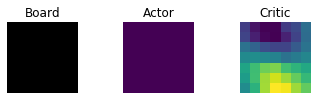

 85%|████████▍ | 849/1000 [1:05:47<03:18,  1.31s/it]

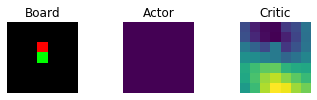

 85%|████████▌ | 850/1000 [1:05:49<03:16,  1.31s/it]

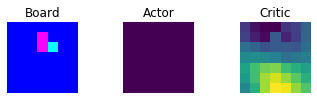

 85%|████████▌ | 851/1000 [1:05:50<03:15,  1.31s/it]

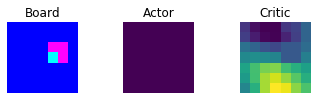

 85%|████████▌ | 852/1000 [1:05:51<03:13,  1.31s/it]

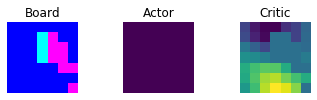

 85%|████████▌ | 853/1000 [1:05:53<03:11,  1.31s/it]

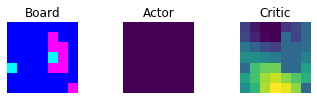

 85%|████████▌ | 854/1000 [1:05:54<03:10,  1.31s/it]

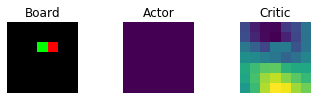

 86%|████████▌ | 855/1000 [1:05:55<03:09,  1.30s/it]

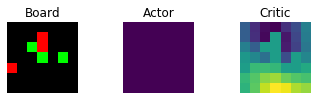

 86%|████████▌ | 856/1000 [1:05:57<03:41,  1.54s/it]

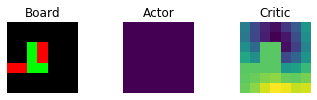

 86%|████████▌ | 857/1000 [1:05:59<03:30,  1.47s/it]

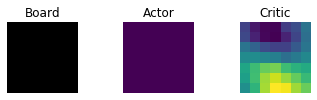

 86%|████████▌ | 858/1000 [1:06:00<03:21,  1.42s/it]

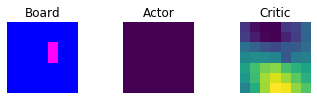

 86%|████████▌ | 859/1000 [1:06:01<03:15,  1.39s/it]

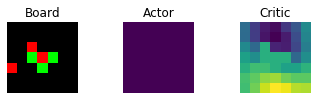

 86%|████████▌ | 860/1000 [1:06:03<03:10,  1.36s/it]

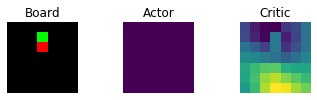

 86%|████████▌ | 861/1000 [1:06:04<03:06,  1.35s/it]

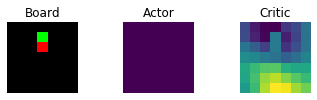

 86%|████████▌ | 862/1000 [1:06:05<03:04,  1.33s/it]

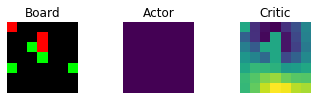

 86%|████████▋ | 863/1000 [1:06:06<03:03,  1.34s/it]

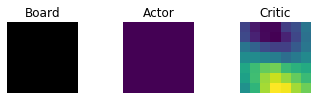

 86%|████████▋ | 864/1000 [1:06:08<03:00,  1.33s/it]

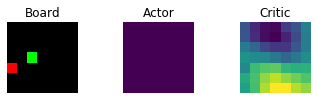

 86%|████████▋ | 865/1000 [1:06:09<02:58,  1.32s/it]

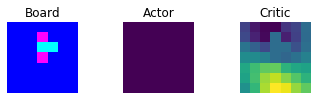

 87%|████████▋ | 866/1000 [1:06:10<02:56,  1.32s/it]

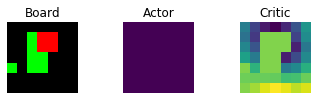

 87%|████████▋ | 867/1000 [1:06:12<02:55,  1.32s/it]

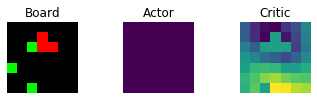

 87%|████████▋ | 868/1000 [1:06:13<02:53,  1.32s/it]

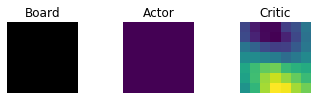

 87%|████████▋ | 869/1000 [1:06:14<02:52,  1.32s/it]

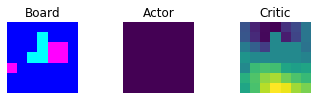

 87%|████████▋ | 870/1000 [1:06:16<02:50,  1.31s/it]

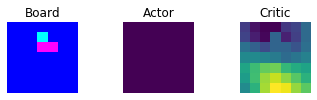

 87%|████████▋ | 871/1000 [1:06:17<02:49,  1.31s/it]

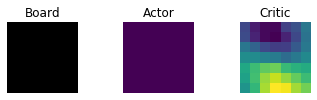

 87%|████████▋ | 872/1000 [1:06:19<03:05,  1.45s/it]

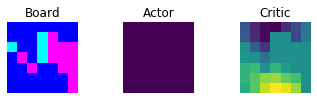

 87%|████████▋ | 873/1000 [1:06:20<02:59,  1.41s/it]

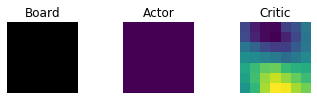

 87%|████████▋ | 874/1000 [1:06:21<02:54,  1.38s/it]

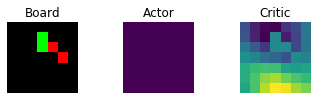

 88%|████████▊ | 875/1000 [1:06:23<03:05,  1.49s/it]

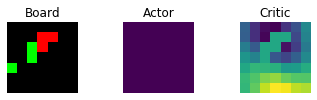

 88%|████████▊ | 876/1000 [1:06:24<02:57,  1.43s/it]

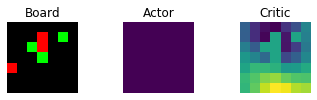

 88%|████████▊ | 877/1000 [1:06:26<03:06,  1.52s/it]

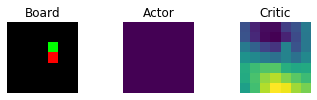

 88%|████████▊ | 878/1000 [1:06:27<02:57,  1.46s/it]

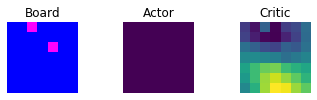

 88%|████████▊ | 879/1000 [1:06:29<02:51,  1.42s/it]

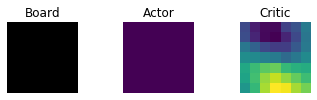

 88%|████████▊ | 880/1000 [1:06:30<02:46,  1.39s/it]

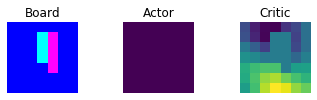

 88%|████████▊ | 881/1000 [1:06:31<02:42,  1.37s/it]

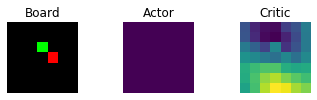

 88%|████████▊ | 882/1000 [1:06:33<02:39,  1.35s/it]

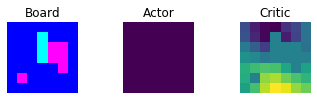

 88%|████████▊ | 883/1000 [1:06:34<02:37,  1.34s/it]

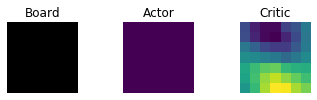

 88%|████████▊ | 884/1000 [1:06:35<02:35,  1.34s/it]

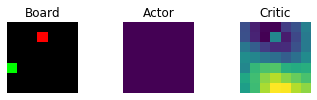

 88%|████████▊ | 885/1000 [1:06:37<02:46,  1.45s/it]

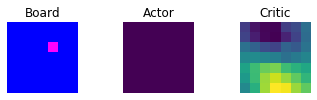

 89%|████████▊ | 886/1000 [1:06:39<02:54,  1.53s/it]

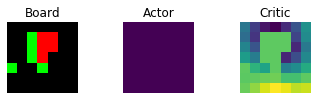

 89%|████████▊ | 887/1000 [1:06:41<03:12,  1.70s/it]

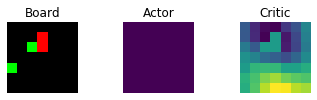

 89%|████████▉ | 888/1000 [1:06:42<02:57,  1.58s/it]

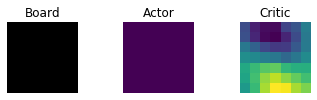

 89%|████████▉ | 889/1000 [1:06:44<03:00,  1.63s/it]

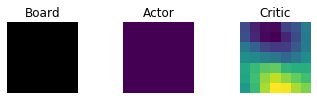

 89%|████████▉ | 890/1000 [1:06:45<02:49,  1.54s/it]

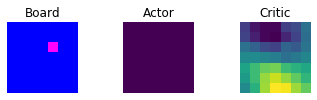

 89%|████████▉ | 891/1000 [1:06:47<02:41,  1.48s/it]

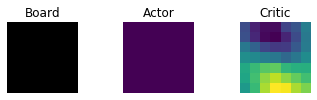

 89%|████████▉ | 892/1000 [1:06:48<02:34,  1.43s/it]

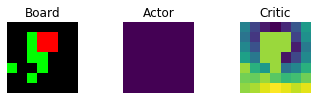

 89%|████████▉ | 893/1000 [1:06:49<02:29,  1.40s/it]

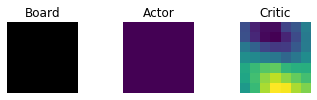

 89%|████████▉ | 894/1000 [1:06:51<02:26,  1.38s/it]

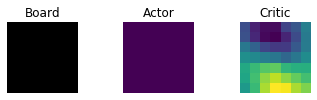

 90%|████████▉ | 895/1000 [1:06:52<02:23,  1.36s/it]

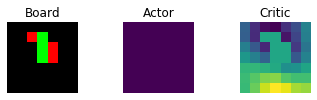

 90%|████████▉ | 896/1000 [1:06:53<02:20,  1.35s/it]

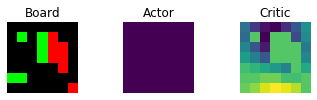

 90%|████████▉ | 897/1000 [1:06:55<02:18,  1.34s/it]

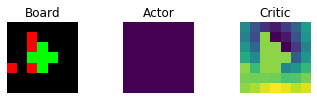

 90%|████████▉ | 898/1000 [1:07:02<05:37,  3.31s/it]

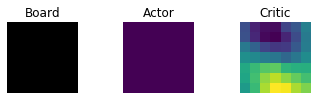

 90%|████████▉ | 899/1000 [1:07:04<04:37,  2.75s/it]

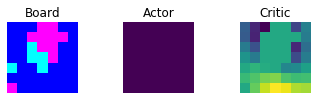

 90%|█████████ | 900/1000 [1:07:05<03:55,  2.36s/it]I0708 22:49:16.016921 4554798528 <ipython-input-38-6ec7be6f7e32>:10] Updated opponent


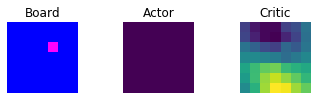

 90%|█████████ | 901/1000 [1:07:08<03:55,  2.37s/it]

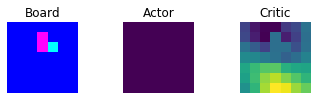

 90%|█████████ | 902/1000 [1:07:09<03:23,  2.07s/it]

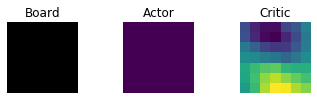

 90%|█████████ | 903/1000 [1:07:11<03:12,  1.98s/it]

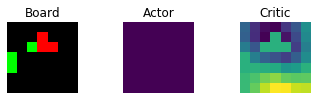

 90%|█████████ | 904/1000 [1:07:12<02:52,  1.80s/it]

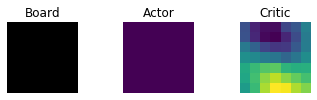

 90%|█████████ | 905/1000 [1:07:14<02:39,  1.68s/it]

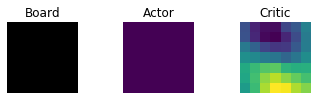

 91%|█████████ | 906/1000 [1:07:15<02:29,  1.60s/it]

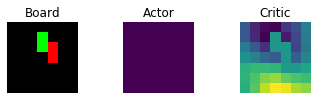

 91%|█████████ | 907/1000 [1:07:17<02:36,  1.68s/it]

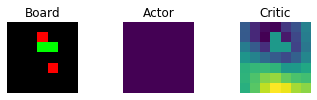

 91%|█████████ | 908/1000 [1:07:19<02:52,  1.87s/it]

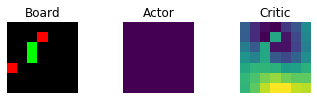

 91%|█████████ | 909/1000 [1:07:21<02:37,  1.74s/it]

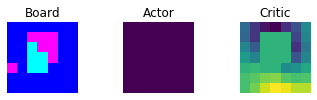

 91%|█████████ | 910/1000 [1:07:22<02:26,  1.63s/it]

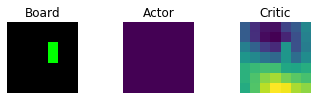

 91%|█████████ | 911/1000 [1:07:24<02:20,  1.58s/it]

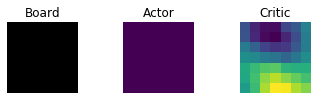

 91%|█████████ | 912/1000 [1:07:25<02:13,  1.52s/it]

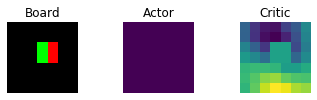

 91%|█████████▏| 913/1000 [1:07:26<02:07,  1.47s/it]

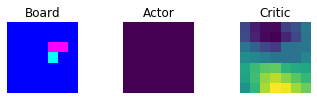

 91%|█████████▏| 914/1000 [1:07:28<02:06,  1.47s/it]

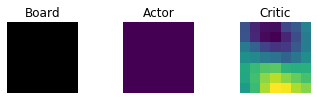

 92%|█████████▏| 915/1000 [1:07:29<02:04,  1.46s/it]

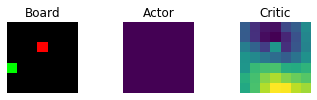

 92%|█████████▏| 916/1000 [1:07:31<02:03,  1.47s/it]

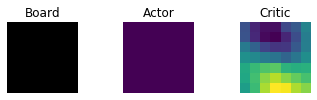

 92%|█████████▏| 917/1000 [1:07:32<02:09,  1.57s/it]

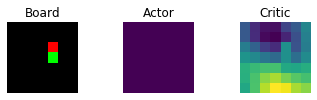

 92%|█████████▏| 918/1000 [1:07:34<02:03,  1.51s/it]

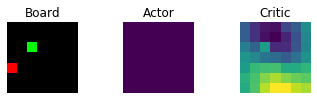

 92%|█████████▏| 919/1000 [1:07:35<01:58,  1.47s/it]

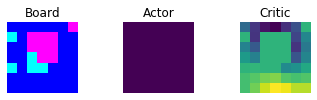

 92%|█████████▏| 920/1000 [1:07:37<01:54,  1.43s/it]

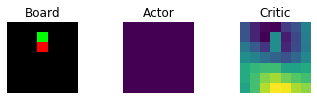

 92%|█████████▏| 921/1000 [1:07:38<01:53,  1.44s/it]

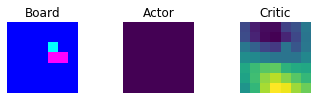

 92%|█████████▏| 922/1000 [1:07:39<01:52,  1.44s/it]

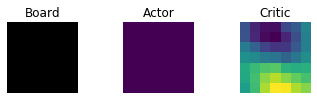

 92%|█████████▏| 923/1000 [1:07:41<01:54,  1.49s/it]

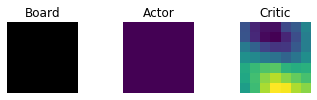

 92%|█████████▏| 924/1000 [1:07:43<01:52,  1.49s/it]

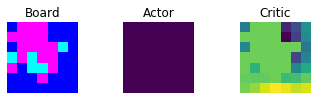

 92%|█████████▎| 925/1000 [1:07:44<01:48,  1.45s/it]

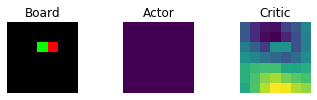

 93%|█████████▎| 926/1000 [1:07:45<01:48,  1.46s/it]

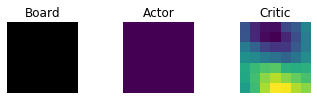

 93%|█████████▎| 927/1000 [1:07:47<01:50,  1.51s/it]

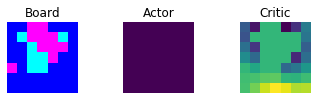

 93%|█████████▎| 928/1000 [1:07:48<01:45,  1.47s/it]

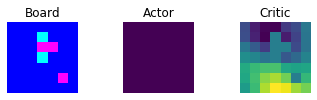

 93%|█████████▎| 929/1000 [1:07:50<01:42,  1.44s/it]

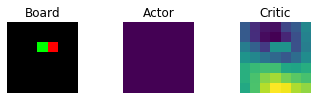

 93%|█████████▎| 930/1000 [1:07:51<01:40,  1.44s/it]

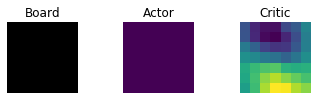

 93%|█████████▎| 931/1000 [1:07:53<01:38,  1.43s/it]

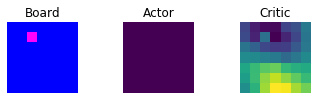

 93%|█████████▎| 932/1000 [1:07:54<01:35,  1.41s/it]

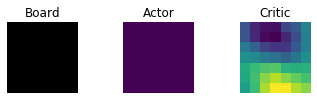

 93%|█████████▎| 933/1000 [1:07:55<01:33,  1.39s/it]

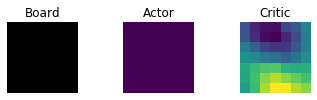

 93%|█████████▎| 934/1000 [1:07:57<01:30,  1.38s/it]

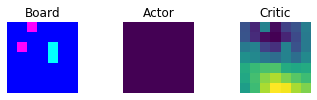

 94%|█████████▎| 935/1000 [1:07:58<01:30,  1.39s/it]

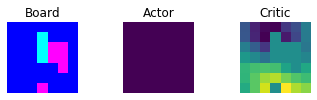

 94%|█████████▎| 936/1000 [1:08:00<01:30,  1.41s/it]

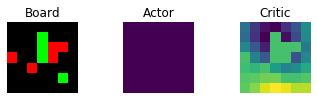

 94%|█████████▎| 937/1000 [1:08:01<01:30,  1.43s/it]

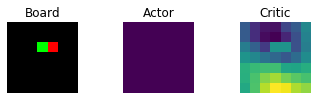

 94%|█████████▍| 938/1000 [1:08:02<01:28,  1.42s/it]

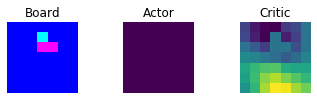

 94%|█████████▍| 939/1000 [1:08:04<01:27,  1.44s/it]

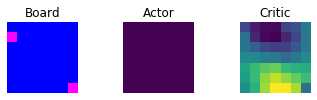

 94%|█████████▍| 940/1000 [1:08:05<01:26,  1.45s/it]

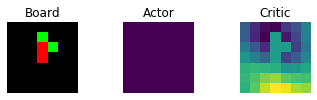

 94%|█████████▍| 941/1000 [1:08:07<01:26,  1.47s/it]

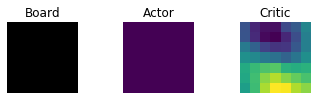

 94%|█████████▍| 942/1000 [1:08:08<01:25,  1.48s/it]

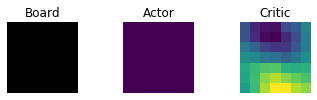

 94%|█████████▍| 943/1000 [1:08:10<01:25,  1.49s/it]

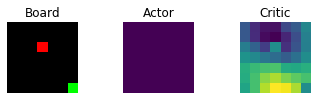

 94%|█████████▍| 944/1000 [1:08:12<01:28,  1.57s/it]

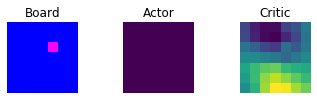

 94%|█████████▍| 945/1000 [1:08:13<01:22,  1.51s/it]

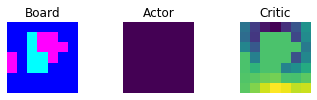

 95%|█████████▍| 946/1000 [1:08:14<01:19,  1.46s/it]

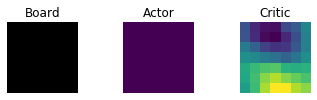

 95%|█████████▍| 947/1000 [1:08:16<01:16,  1.45s/it]

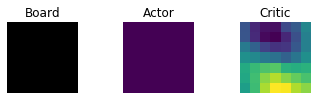

 95%|█████████▍| 948/1000 [1:08:17<01:15,  1.46s/it]

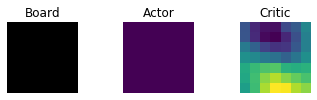

 95%|█████████▍| 949/1000 [1:08:19<01:16,  1.50s/it]

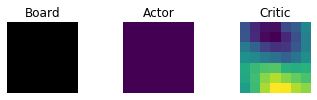

 95%|█████████▌| 950/1000 [1:08:21<01:21,  1.62s/it]

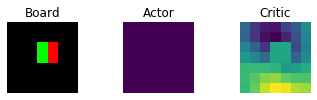

 95%|█████████▌| 951/1000 [1:08:22<01:17,  1.58s/it]

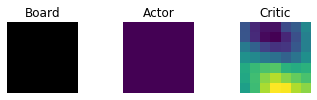

 95%|█████████▌| 952/1000 [1:08:24<01:21,  1.69s/it]

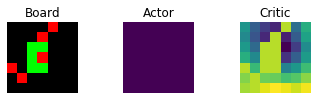

 95%|█████████▌| 953/1000 [1:08:26<01:18,  1.67s/it]

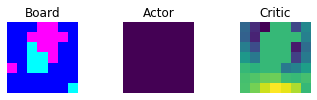

 95%|█████████▌| 954/1000 [1:08:27<01:15,  1.65s/it]

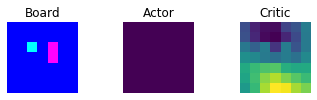

 96%|█████████▌| 955/1000 [1:08:29<01:13,  1.62s/it]

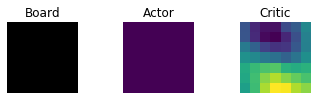

 96%|█████████▌| 956/1000 [1:08:31<01:09,  1.59s/it]

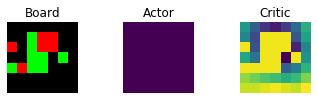

 96%|█████████▌| 957/1000 [1:08:32<01:11,  1.66s/it]

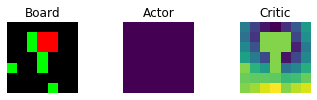

 96%|█████████▌| 958/1000 [1:08:34<01:08,  1.63s/it]

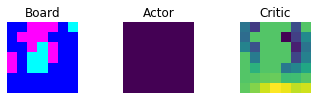

 96%|█████████▌| 959/1000 [1:08:36<01:06,  1.63s/it]

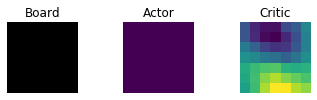

 96%|█████████▌| 960/1000 [1:08:37<01:03,  1.58s/it]

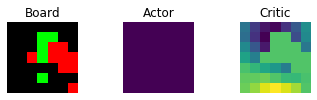

 96%|█████████▌| 961/1000 [1:08:39<01:01,  1.57s/it]

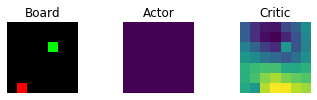

 96%|█████████▌| 962/1000 [1:08:40<01:02,  1.65s/it]

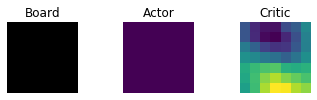

 96%|█████████▋| 963/1000 [1:08:42<00:58,  1.57s/it]

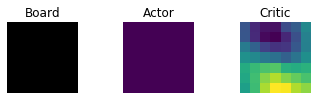

 96%|█████████▋| 964/1000 [1:08:43<00:54,  1.52s/it]

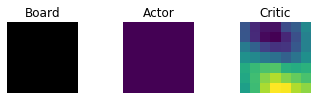

 96%|█████████▋| 965/1000 [1:08:45<00:55,  1.59s/it]

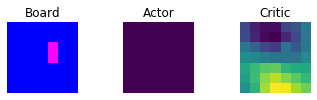

 97%|█████████▋| 966/1000 [1:08:46<00:52,  1.53s/it]

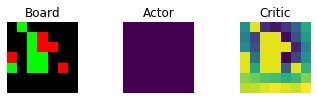

 97%|█████████▋| 967/1000 [1:08:48<00:50,  1.52s/it]

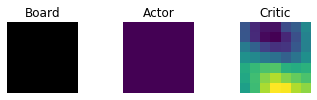

 97%|█████████▋| 968/1000 [1:08:49<00:48,  1.51s/it]

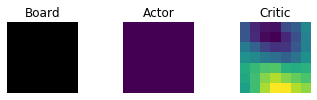

 97%|█████████▋| 969/1000 [1:08:51<00:50,  1.62s/it]

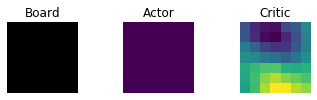

 97%|█████████▋| 970/1000 [1:08:53<00:47,  1.57s/it]

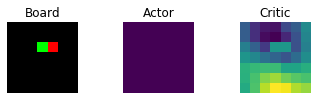

 97%|█████████▋| 971/1000 [1:08:54<00:44,  1.53s/it]

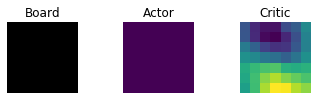

 97%|█████████▋| 972/1000 [1:08:55<00:41,  1.49s/it]

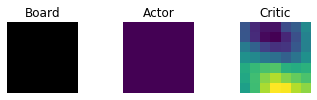

 97%|█████████▋| 973/1000 [1:08:57<00:39,  1.47s/it]

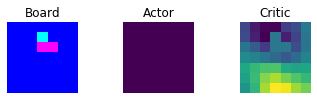

 97%|█████████▋| 974/1000 [1:08:58<00:38,  1.48s/it]

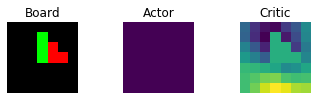

 98%|█████████▊| 975/1000 [1:09:00<00:37,  1.49s/it]

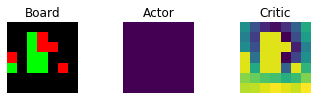

 98%|█████████▊| 976/1000 [1:09:01<00:35,  1.49s/it]

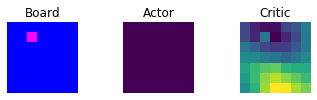

 98%|█████████▊| 977/1000 [1:09:03<00:35,  1.53s/it]

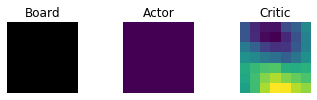

 98%|█████████▊| 978/1000 [1:09:05<00:33,  1.54s/it]

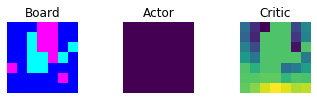

 98%|█████████▊| 979/1000 [1:09:06<00:32,  1.54s/it]

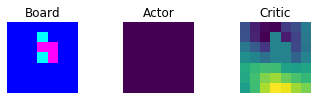

 98%|█████████▊| 980/1000 [1:09:08<00:31,  1.59s/it]

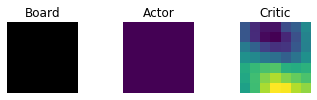

 98%|█████████▊| 981/1000 [1:09:09<00:29,  1.56s/it]

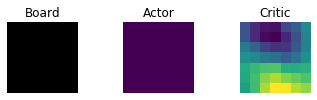

 98%|█████████▊| 982/1000 [1:09:11<00:27,  1.52s/it]

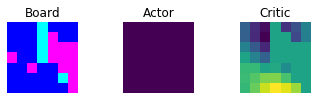

 98%|█████████▊| 983/1000 [1:09:12<00:25,  1.49s/it]

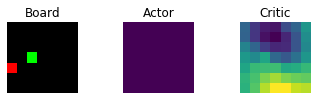

 98%|█████████▊| 984/1000 [1:09:14<00:23,  1.45s/it]

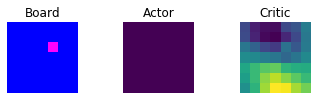

 98%|█████████▊| 985/1000 [1:09:15<00:21,  1.43s/it]

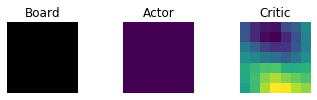

 99%|█████████▊| 986/1000 [1:09:16<00:19,  1.42s/it]

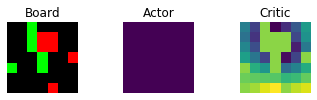

 99%|█████████▊| 987/1000 [1:09:18<00:18,  1.41s/it]

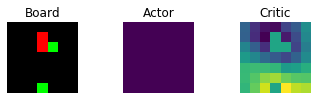

 99%|█████████▉| 988/1000 [1:09:19<00:18,  1.52s/it]

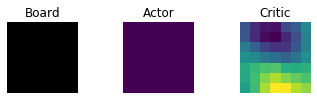

 99%|█████████▉| 989/1000 [1:09:21<00:17,  1.60s/it]

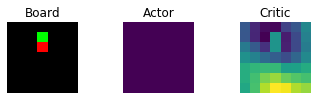

 99%|█████████▉| 990/1000 [1:09:23<00:15,  1.54s/it]

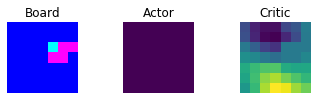

 99%|█████████▉| 991/1000 [1:09:24<00:13,  1.50s/it]

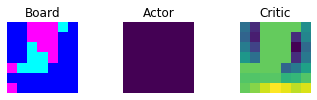

 99%|█████████▉| 992/1000 [1:09:26<00:12,  1.59s/it]

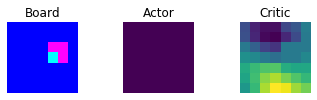

 99%|█████████▉| 993/1000 [1:40:41<1:05:45, 563.67s/it]

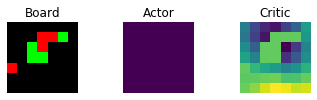

 99%|█████████▉| 994/1000 [1:40:43<39:30, 395.03s/it]  

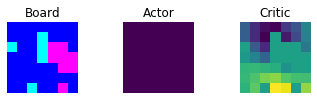

100%|█████████▉| 995/1000 [1:40:44<23:04, 276.93s/it]

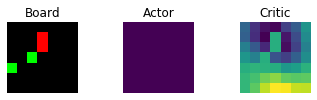

100%|█████████▉| 996/1000 [1:40:45<12:57, 194.26s/it]

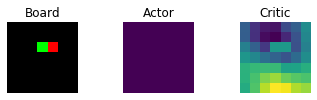

100%|█████████▉| 997/1000 [1:40:47<06:49, 136.64s/it]

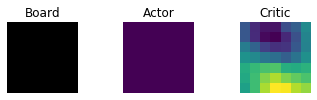

100%|█████████▉| 998/1000 [1:40:49<03:12, 96.06s/it] 

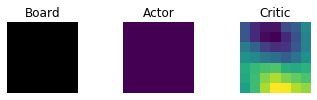

100%|█████████▉| 999/1000 [1:40:50<01:07, 67.66s/it]

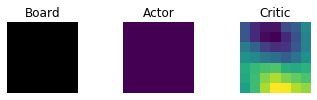

100%|██████████| 1000/1000 [1:41:00<00:00, 50.42s/it]


In [38]:
for episode in tqdm(range(NUM_EPISODES)):
    # Reset all metrics
    for metric in actor_metrics.values():
        metric.reset_states()
    for metric in critic_metrics.values():
        metric.reset_states()
    
    if episode % OPPONENT_UPDATE == 0:
        opponent = copy_actor_critic(actor, 'actor')
        logging.info("Updated opponent")
        
    if episode % TARGET_UPDATE == 0:
        target_critic = copy_actor_critic(critic, 'critic')

    num_turns, rewards = train(episode)
    
    # Plot samples of states and actor, critic heatmaps
    num_samples = 1
    states, _, _, _,_ = get_batch_obs(num_samples)
    board_prob_distrs, pass_probs = actor(states)
    board_val_distrs, pass_vals = critic(states)
    plt.figure(figsize=(5,1.5))
    for i in range(num_samples):
        plt.subplot(num_samples,3,3*i+1+0)
        plt.axis('off')
        plt.title('Board')
        plt.imshow(states[i][:,:,[0,1,3]].astype(np.float))
        plt.subplot(num_samples,3,3*i+1+1)
        plt.axis('off')
        plt.title('Actor')
        plt.ylabel('Pass Prob: {:.4f}'.format(pass_probs[i][0]))
        plt.imshow(board_prob_distrs[i])
        plt.subplot(num_samples,3,3*i+1+2)
        plt.axis('off')
        plt.title('Critic')
        plt.ylabel('Max Board Val {:.4f}\nPass Val: {:.4f}'
                  .format(np.max(board_val_distrs), pass_vals[i][0]))
        plt.imshow(board_val_distrs[i])
        
    plt.tight_layout()
    plt.show()
    
    # log results
    with summary_writers['main'].as_default():
        tf.summary.scalar('last rewards', rewards[-1], step=episode)
        tf.summary.scalar('rewards sum', sum(rewards), step=episode)
        tf.summary.scalar('number of moves', num_turns, step=episode)
        tf.summary.scalar('critic loss', critic_metrics['loss'].result(), step=episode)
        tf.summary.scalar('actor loss', actor_metrics['loss'].result(), step=episode)
        tf.summary.scalar('epsilon', EPSILON, step=episode)
        

In [39]:
actor.save_weights('tmp/actor.h5')
critic.save_weights('tmp/critic.h5')

# Evaluate

Test against a pretrained AI

In [40]:
# TODO

Play against our AI

In [ ]:
go_env = gym.make('gym_go:go-v0', size='S')

state = go_env.reset()

done = False
while not done:
    go_env.render()
    
    # Actor's move
    action = get_action(actor, state, 0)
    
    state, reward, done, info = go_env.step(action)
    
    go_env.render()
    
    # Player's move
    player_moved = False
    while not player_moved:
        coords = input("Enter coordinates separated by space (`q` to quit)\n")
        if coords == 'q':
            done = True
            break
        coords = coords.split()
        try:
            row = int(coords[0])
            col = int(coords[1])
            print(row, col)
            state, reward, done, info = go_env.step((row, col))
            player_moved = True
        except Exception as e:
            print(e)

    0   1   2   3   4   5   6
  -----------------------------
0 |   |   |   |   |   |   |   |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 |   |   |   |   |   |   |   |
  -----------------------------
5 |   |   |   |   |   |   |   |
  -----------------------------
6 |   |   |   |   |   |   |   |
  -----------------------------

    0   1   2   3   4   5   6
  -----------------------------
0 |   |   |   |   |   |   |   |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 |   |   |   |   | B |   |   |
  -----------------------------
5 |   |   |   |   |   |   |   |
  -----------------------------
6 |   |   |   |   |   |   |   |
  ---------